In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [10]:
# load the image files
bead_date =20201007
bead_number = 1
dataset = "/Shaking/Shaking345/"
FOI = "NoShakingNoSpin0_"
filename = "/data/new_trap/" + str(bead_date) + "/Bead%s/" %bead_number +dataset + "Pictures_0/" + FOI
data = load_npy_files(path=filename+"*",max_files=10000)

/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_0.npy 0
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_1.npy 1
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_2.npy 2
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_6.npy 3
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_7.npy 4
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_8.npy 5
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_9.npy 6
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_10.npy 7
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_11.npy 8
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_12.npy 9
/data/new_trap/20201007/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin0_13.npy 10
/data/new_trap/20201007/Bead1//Shaking/Shaking345

In [3]:
pixel_size_cal = 0.512 # obtained from attractor calibration data February2020, but cross checked during Wilson itself
attractor_0 = 162 # 0 position of attractor as extrapolated from image analysis of z=50 and z=27. Obtained from Wilson attractor screening.

(650.0, 720.0)

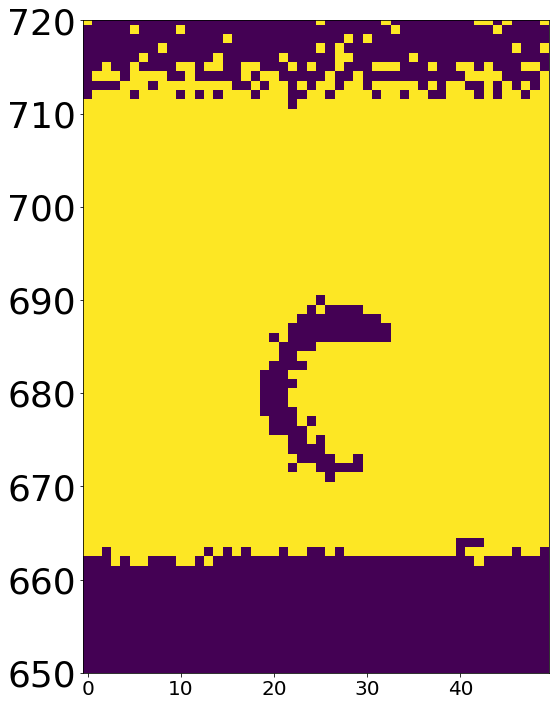

In [4]:
ret,thresh = cv2.threshold(data[-1],135,255,0)
plt.imshow(thresh[::,600:650])
plt.ylim(650,720)

In [5]:
def from_shadow_image_to_height(image,threshold,area_low_limits=[670,730],area_widths=[40,70],flb=460,fub=510,area_max=3000,width_max=7,plot=False):
    thresh = threshold_image(image.copy(),threshold,256)
    img = thresh.transpose()
    z1 = np.mean(img[area_low_limits[0]:area_low_limits[0]+area_widths[0]],axis=0)
    z2 = np.mean(img[area_low_limits[1]:area_low_limits[1]+area_widths[1]],axis=0)
    fit_img = z1-z2
    m = gaussian_fit_shadow_height(fit_img,low_y_lim=flb,up_y_lim=fub,upper_area=area_max,up_lim_width=width_max,img_type="Diff_Projection",)   
    if(plot==True):
        plt.plot(fit_img)
        plt.plot(range(1024),gaussian(range(1024),params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]),label="fit")
        plt.xlim(m.values["mean"]-100,m.values["mean"]+100)
    # height =  pixel_to_height(m.values["mean"],calibration=calibration)        
    return m.values["mean"],m # in pixels


In [6]:
def imp_from_shadow_image_to_height(image,threshold,area_low_limits=[670,730],area_widths=[40,70],flb=460,fub=510,area_max=3000,width_max=5,plot=False):
    thresh = threshold_image(image.copy(),threshold,256)
    img = thresh.transpose()
    z1 = np.mean(img[area_low_limits[0]:area_low_limits[0]+area_widths[0]],axis=0)
    z2 = np.mean(img[area_low_limits[1]:area_low_limits[1]+area_widths[1]],axis=0)
    fit_img_raw = z1-z2
    fit_img = []
    for elements in fit_img_raw: 
        if(elements<0): value=elements 
        else: value=0
        fit_img.append(value)
    m = gaussian_fit_shadow_height(fit_img,low_y_lim=flb,up_y_lim=fub,upper_area=area_max,up_lim_width=width_max,img_type="Diff_Projection",)   
    if(plot==True):
        plt.plot(fit_img)
        plt.plot(range(1024),gaussian(range(1024),params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]),label="fit")
        plt.xlim(m.values["mean"]-100,m.values["mean"]+100)
    # height =  pixel_to_height(m.values["mean"],calibration=calibration)        
    return m.values["mean"],m # in pixels


In [7]:
def gaussian_fit_shadow_height(img,low_x_lim=670,up_x_lim=710,low_y_lim=400,up_y_lim=750,upper_area=3000,up_lim_width=7,img_type="Image"):    
    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)    
    def chisquare_gaussian(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
        
    fit_range_low = low_y_lim
    fit_range_high = up_y_lim
        
    if(img_type=="Image"):
        img2 = img.transpose()
        data_x = np.arange(fit_range_low,fit_range_high,1)
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0)[fit_range_low:fit_range_high] # give y data 
        constant=255
    if(img_type=="Projection"): 
        data_x = np.arange(fit_range_low,fit_range_high,1)
        data_y = img[fit_range_low:fit_range_high]
        constant=255
    if(img_type=="Diff_Projection"): 
        data_x = range(len(img)) # give x data
        data_y = img
        constant = 0
        

    data_y_error = np.sqrt(np.abs(data_y))+1 # give y uncertainty
    low_lim_mean = low_y_lim
    up_lim_mean = up_y_lim

    m=Minuit(chisquare_gaussian, 
             area = -1000, # set start parameter
             error_area = 1,
             limit_area= (-upper_area,0), # if you want to limit things
             #fix_area = "False", # you can also fix it
             mean = (low_y_lim+up_y_lim)/2,
             error_mean = 1,
             #fix_mean = "True",
             limit_mean = (low_lim_mean,up_lim_mean),
             sigma = 4,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant = constant,
             error_constant = 1,
             fix_constant="True",
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    #print(np.median(data_y))
    return m



  0%|          | 0/152 [00:00<?, ?it/s]

180


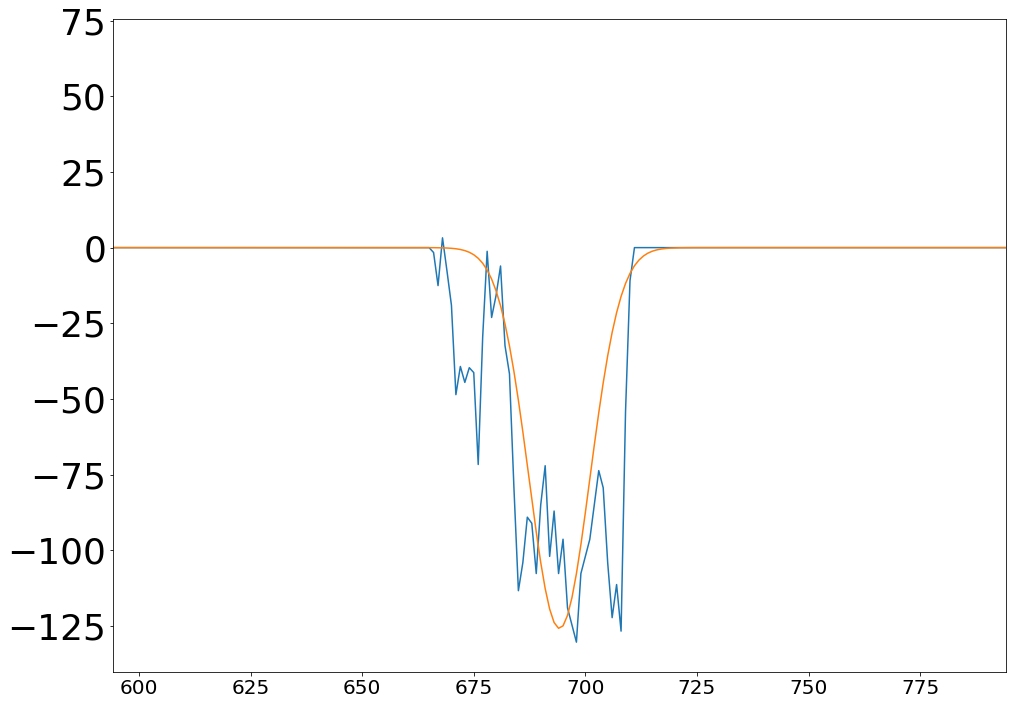

  1%|          | 1/152 [00:00<00:22,  6.85it/s]

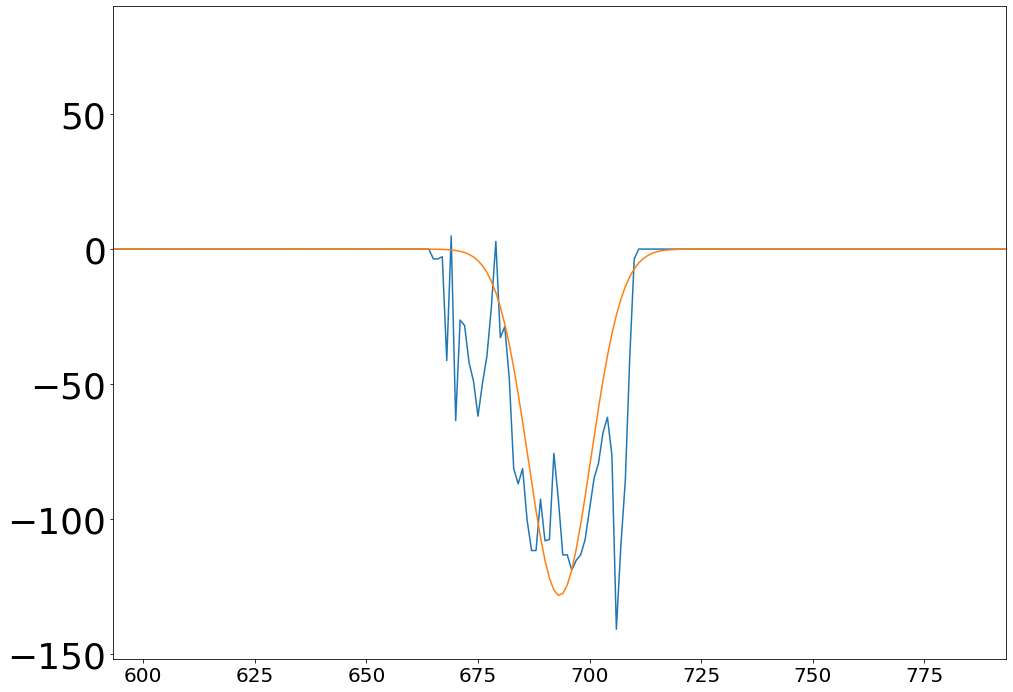

  1%|▏         | 2/152 [00:00<00:21,  6.98it/s]

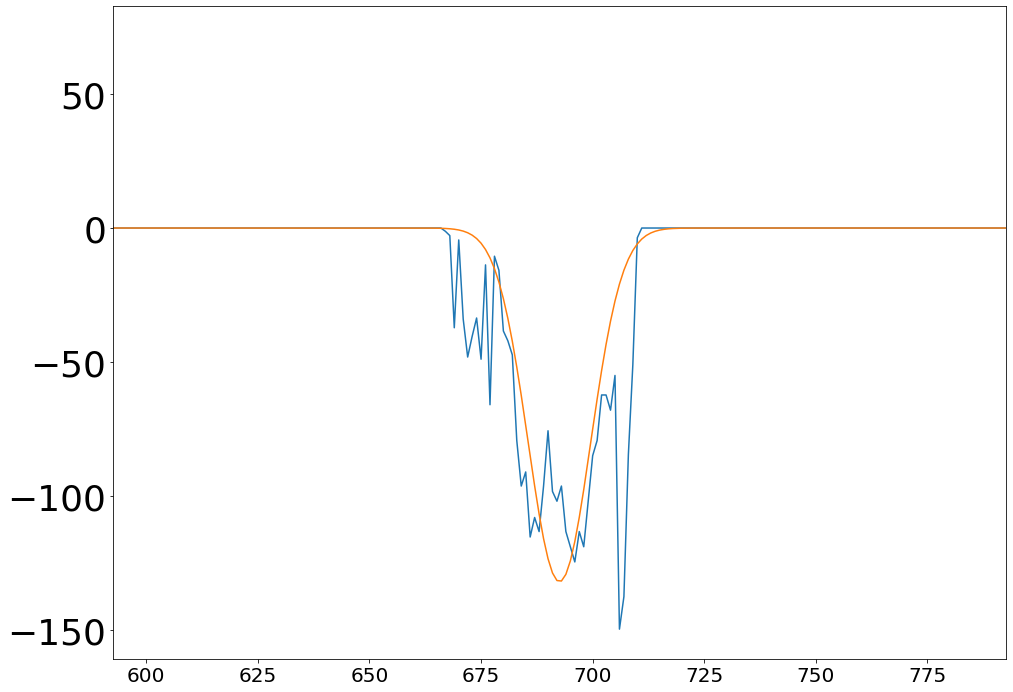

  2%|▏         | 3/152 [00:00<00:20,  7.15it/s]

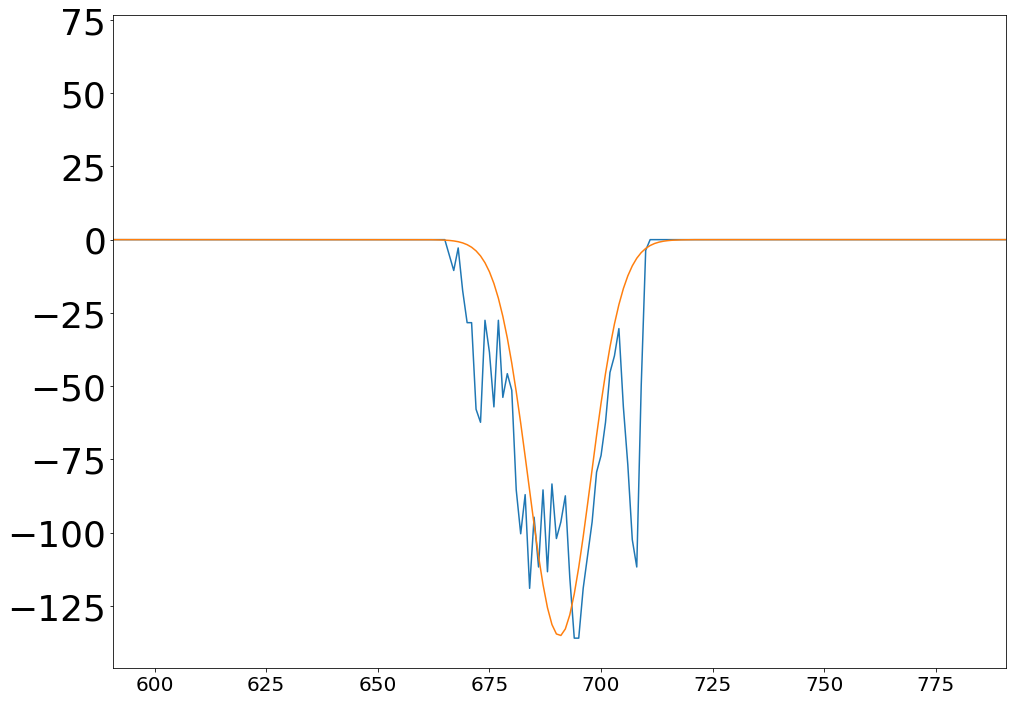

  3%|▎         | 4/152 [00:00<00:21,  7.01it/s]

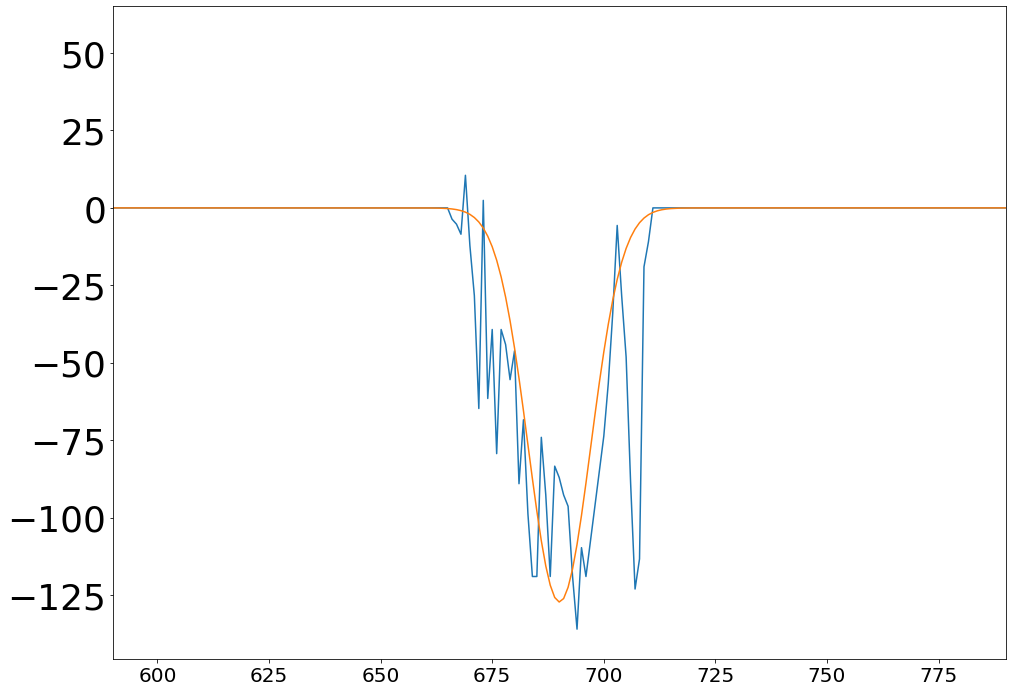

  3%|▎         | 5/152 [00:00<00:21,  6.99it/s]

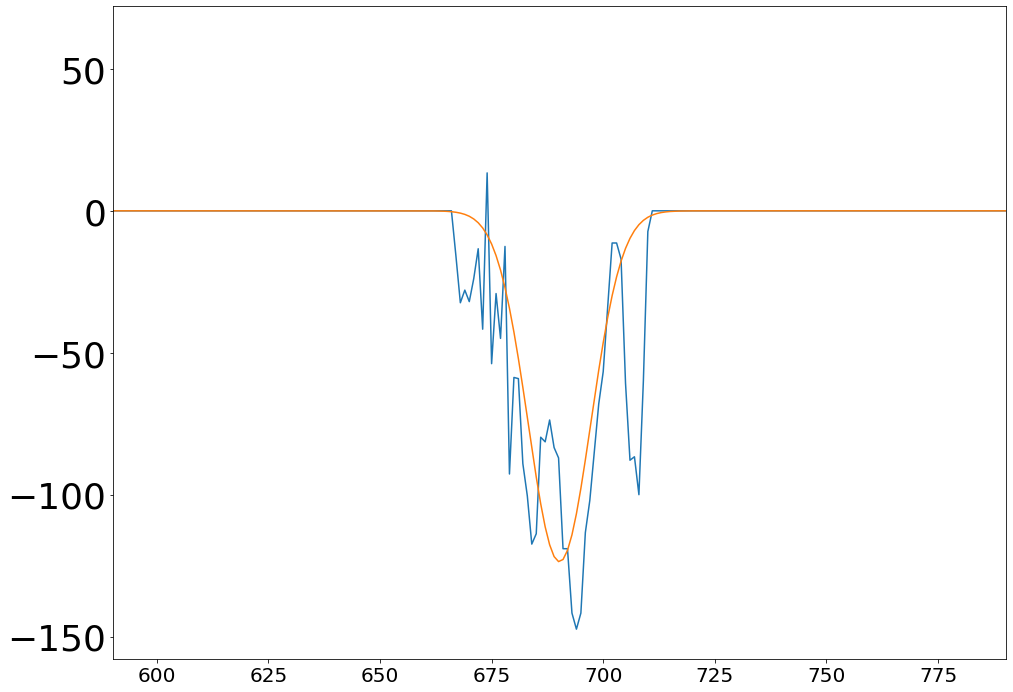

  4%|▍         | 6/152 [00:00<00:20,  7.05it/s]

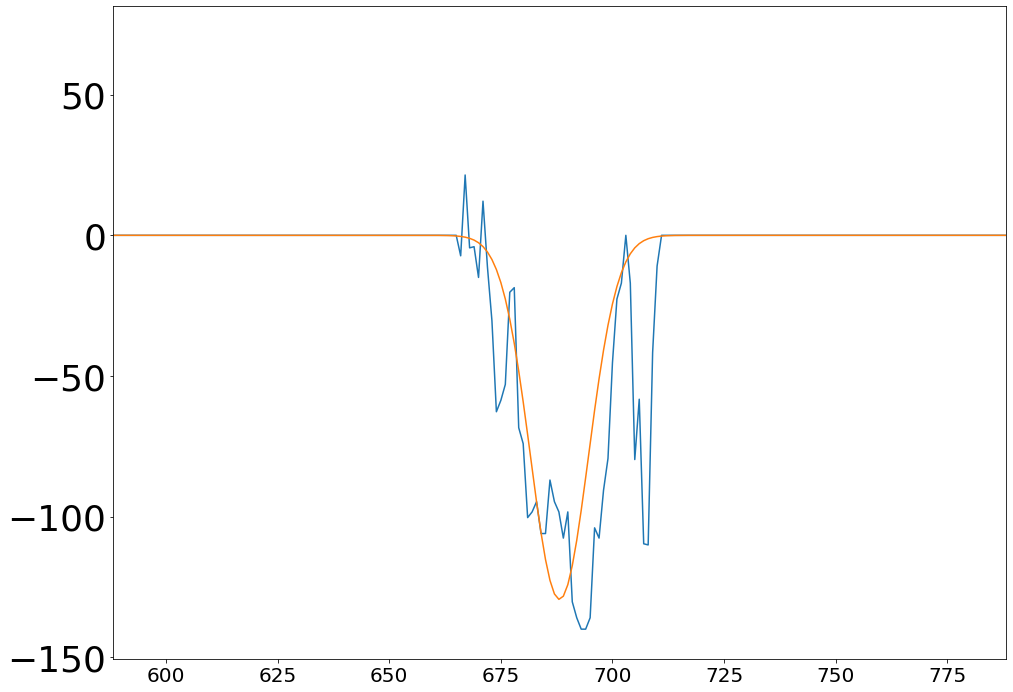

  5%|▍         | 7/152 [00:00<00:20,  7.10it/s]

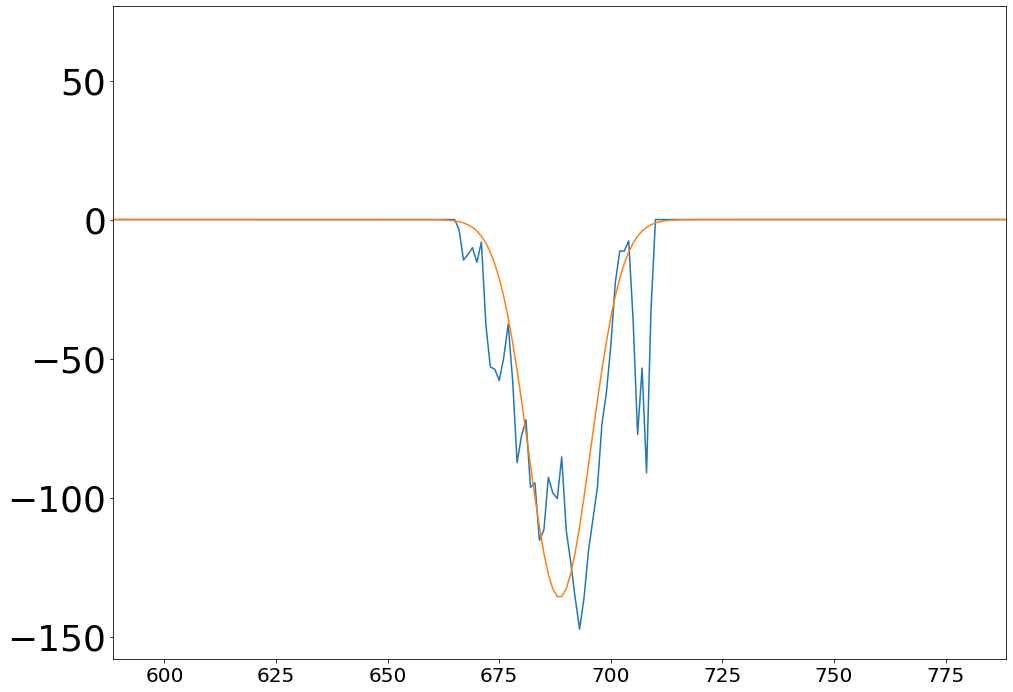

  5%|▌         | 8/152 [00:01<00:19,  7.21it/s]

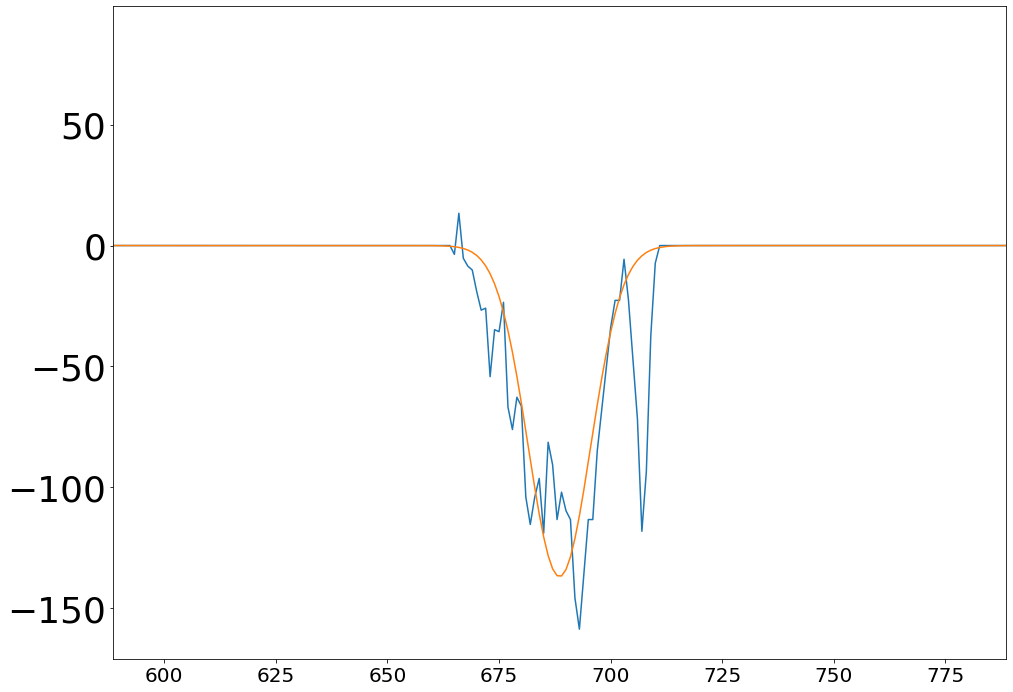

  6%|▌         | 9/152 [00:01<00:19,  7.25it/s]

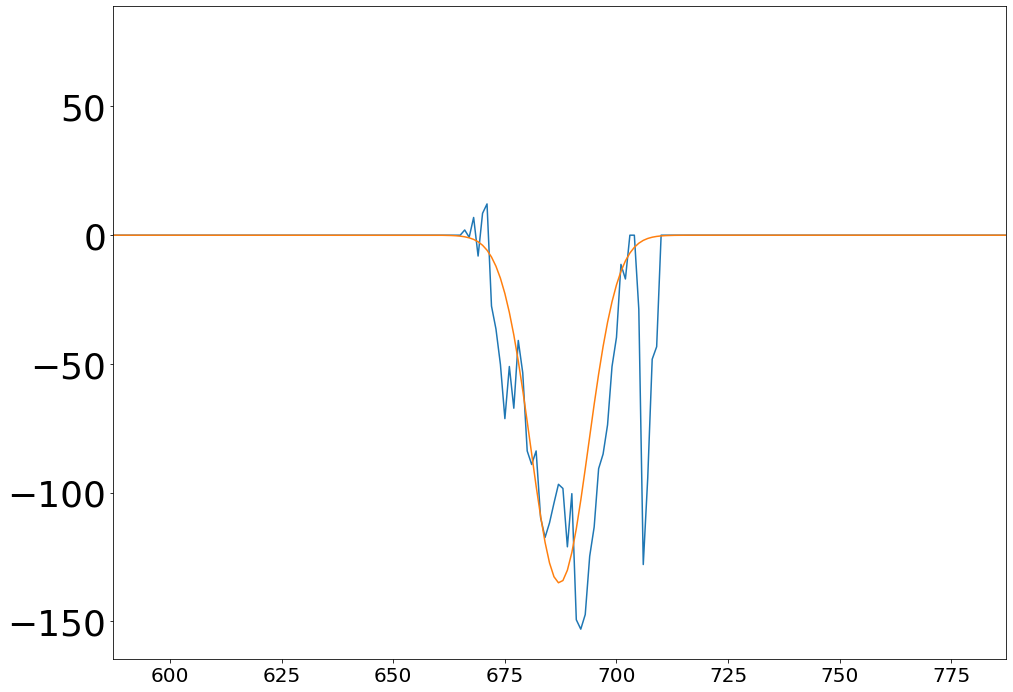

  7%|▋         | 10/152 [00:01<00:22,  6.35it/s]

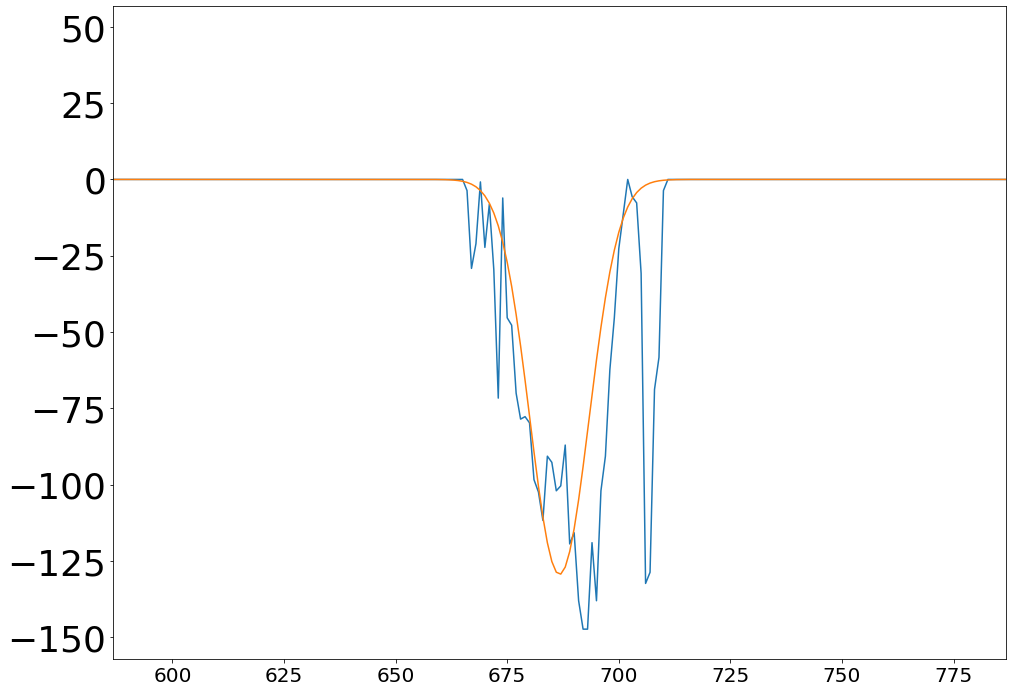

  7%|▋         | 11/152 [00:01<00:21,  6.47it/s]

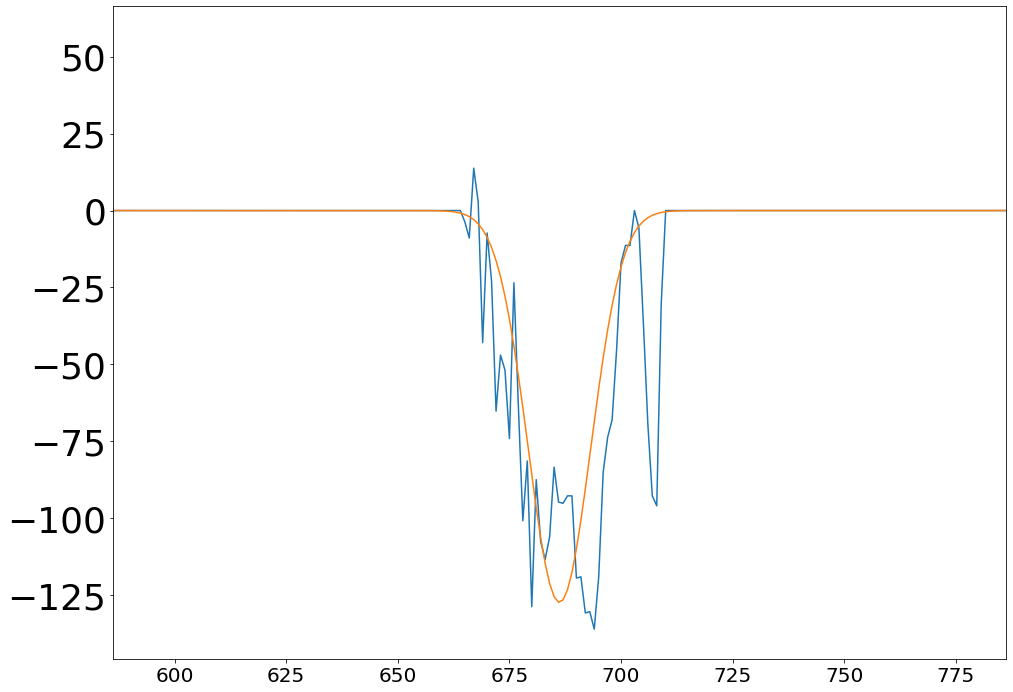

  8%|▊         | 12/152 [00:01<00:21,  6.50it/s]

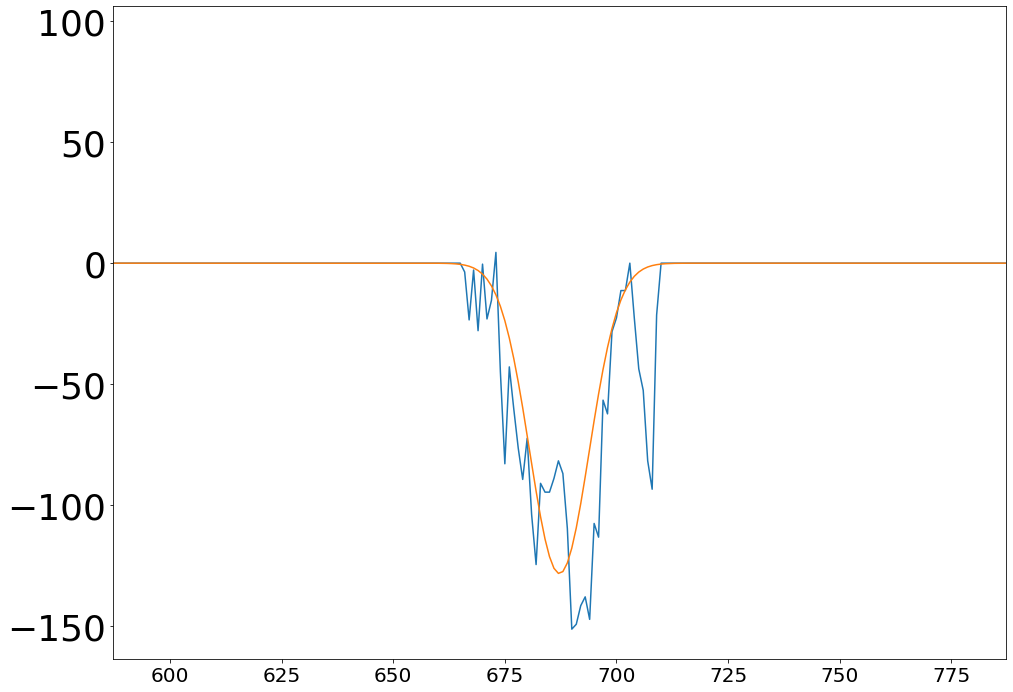

  9%|▊         | 13/152 [00:01<00:20,  6.72it/s]

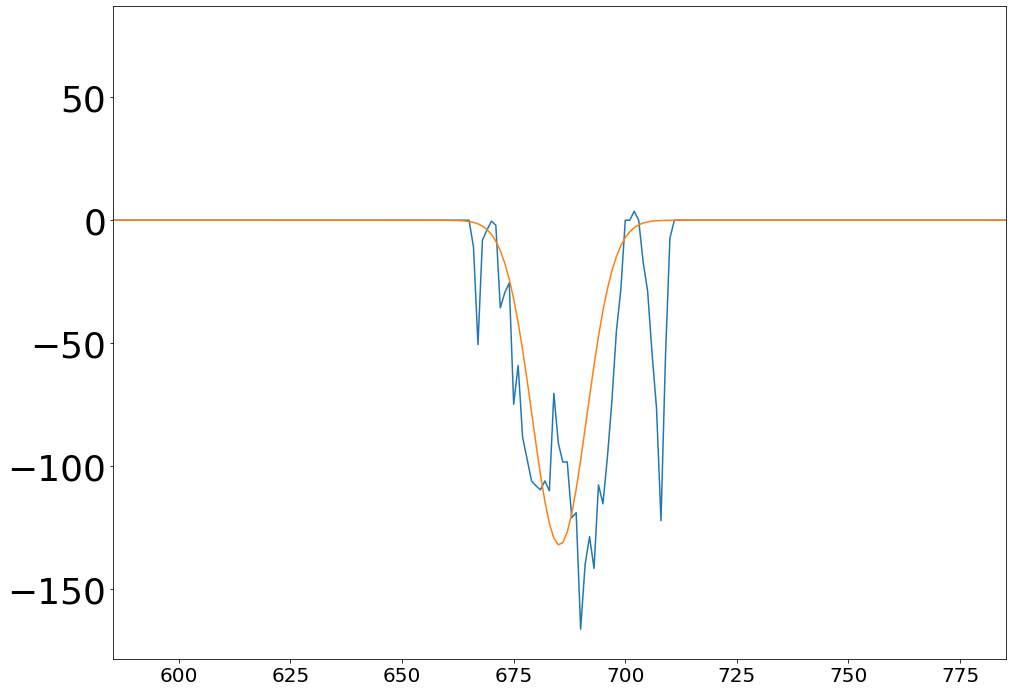

  9%|▉         | 14/152 [00:02<00:19,  6.99it/s]

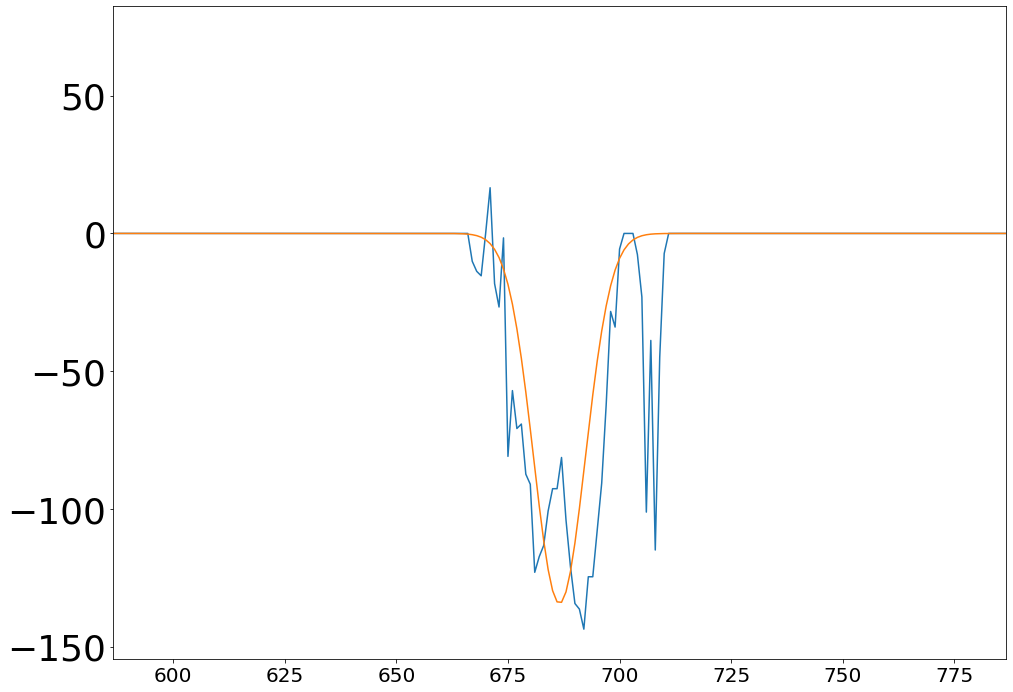

 10%|▉         | 15/152 [00:02<00:19,  7.00it/s]

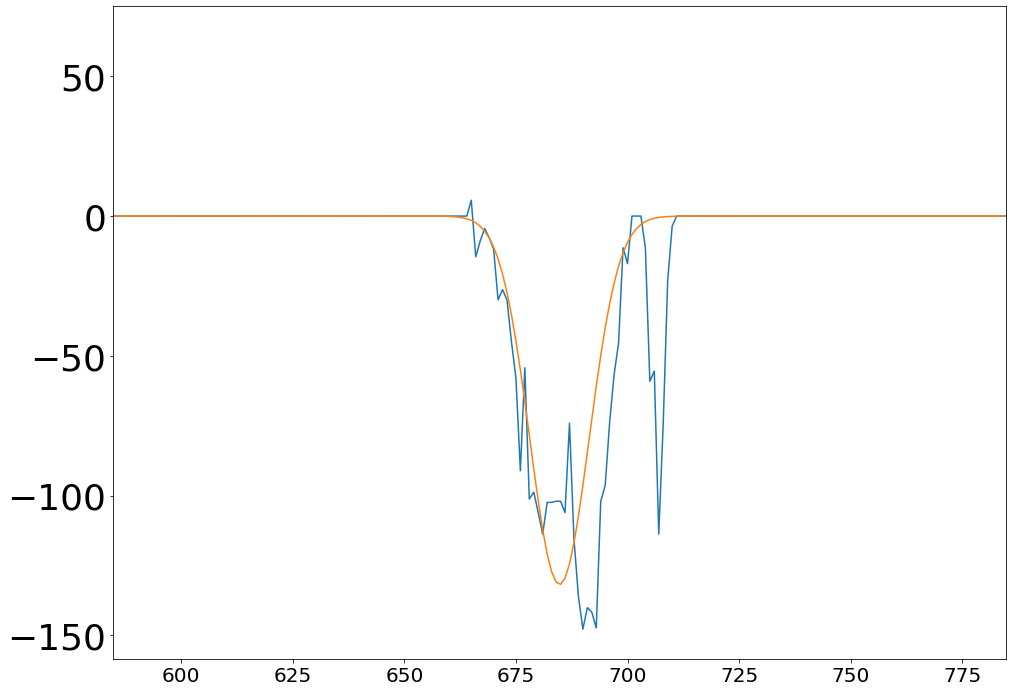

 11%|█         | 16/152 [00:02<00:19,  7.04it/s]

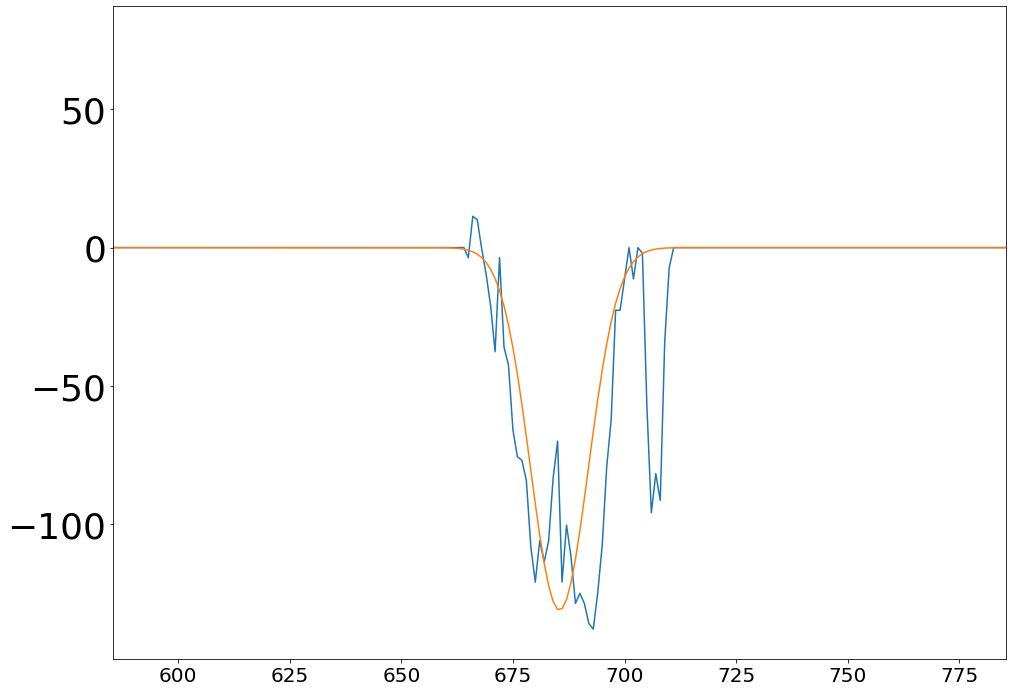

 11%|█         | 17/152 [00:02<00:18,  7.15it/s]

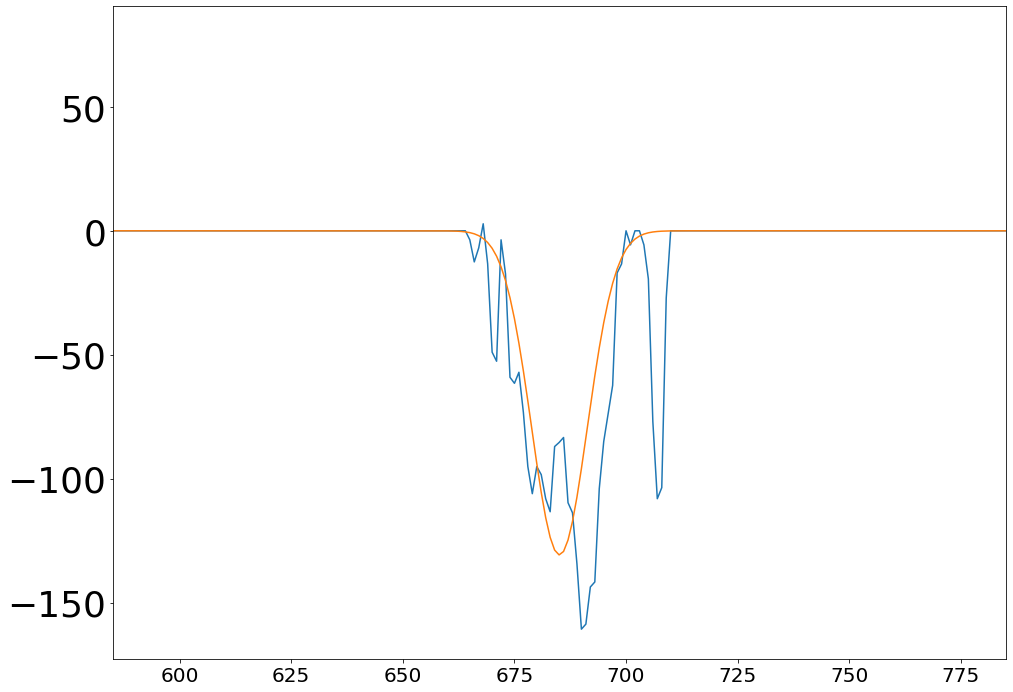

 12%|█▏        | 18/152 [00:02<00:18,  7.21it/s]

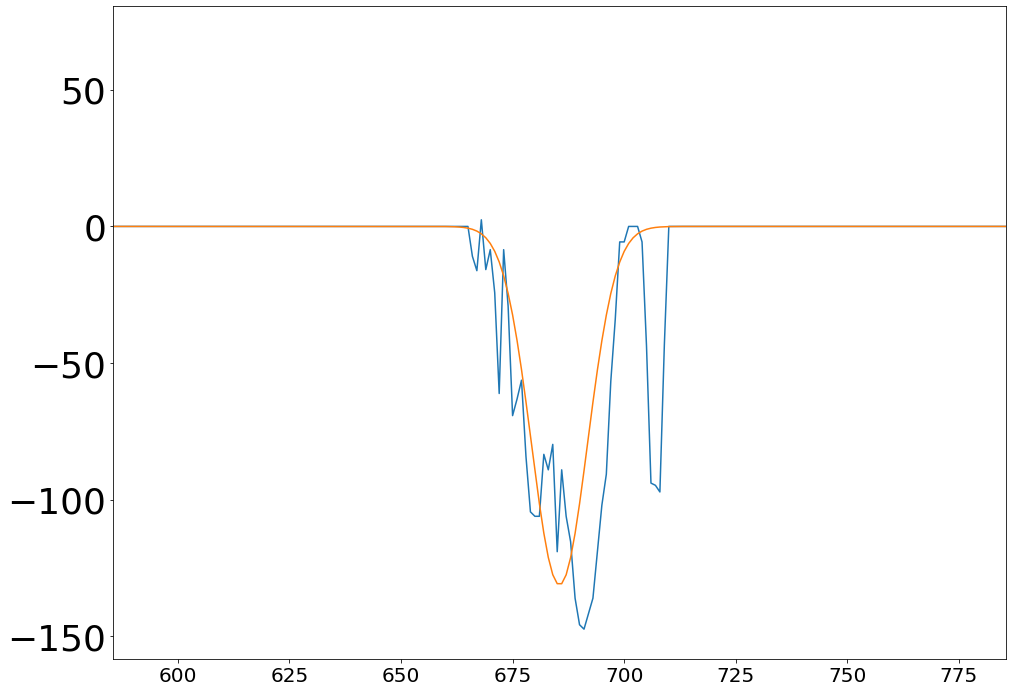

 12%|█▎        | 19/152 [00:02<00:18,  7.33it/s]

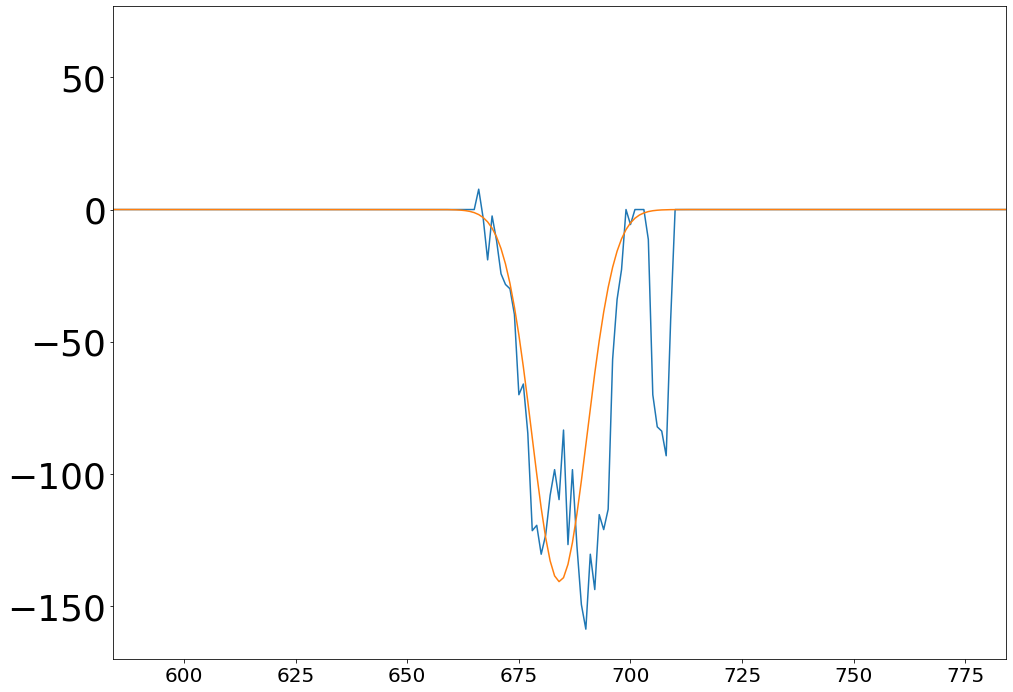

 13%|█▎        | 20/152 [00:02<00:18,  7.32it/s]

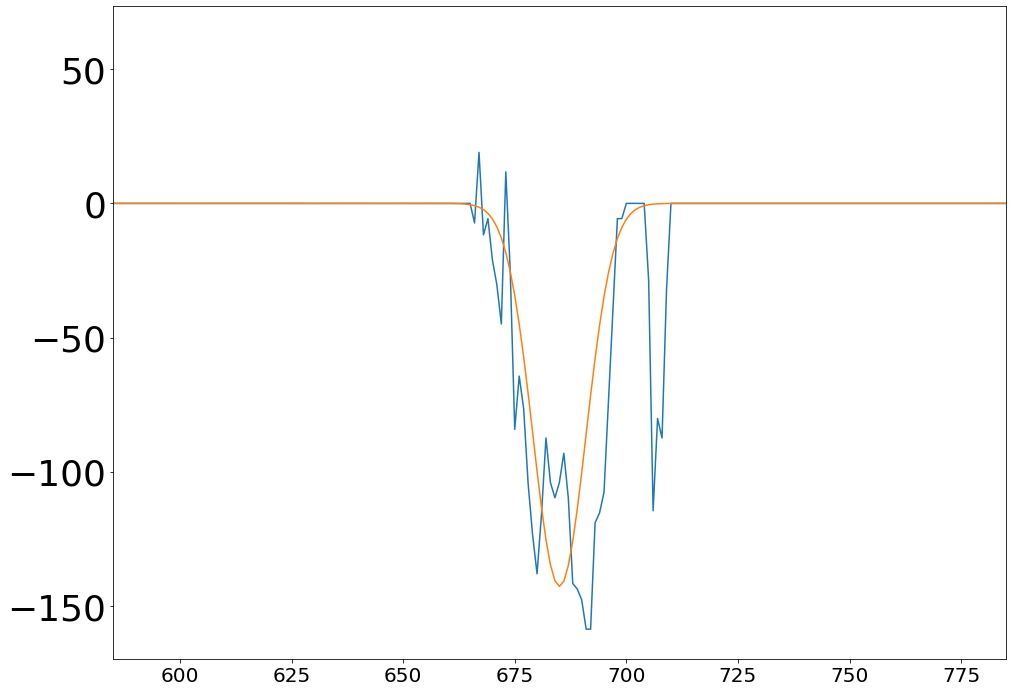

 14%|█▍        | 21/152 [00:02<00:17,  7.35it/s]

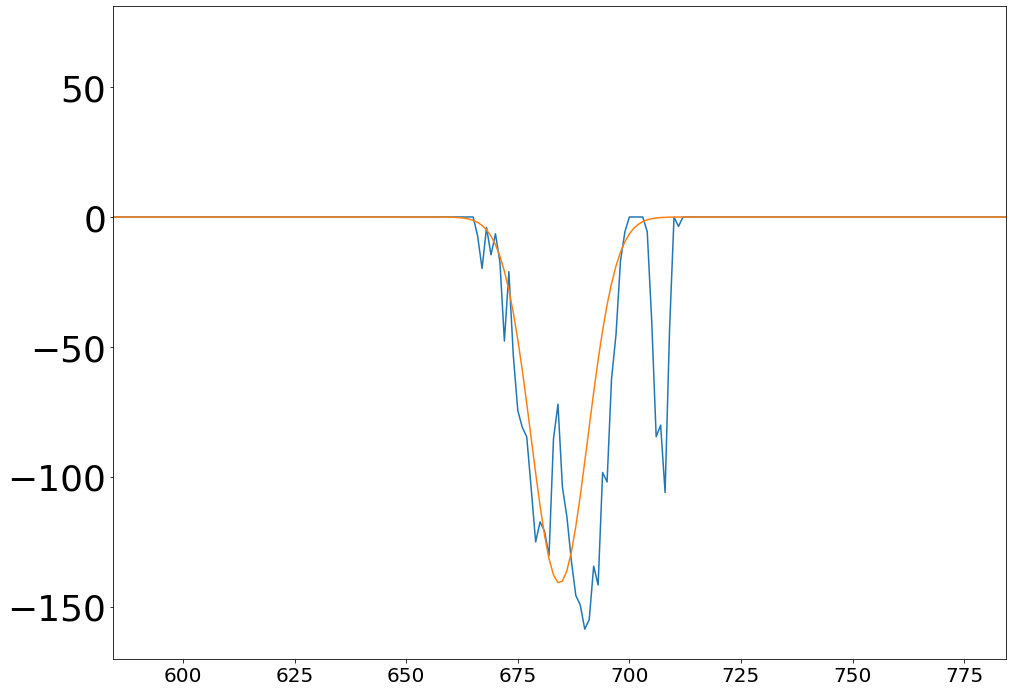

 14%|█▍        | 22/152 [00:03<00:17,  7.36it/s]

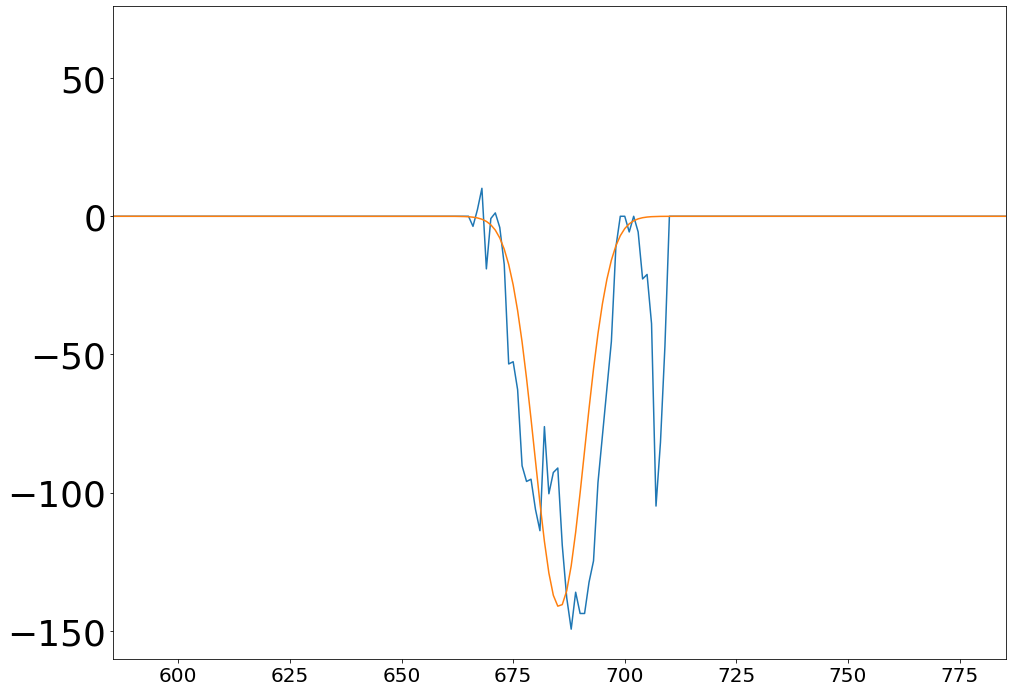

 15%|█▌        | 23/152 [00:03<00:19,  6.64it/s]

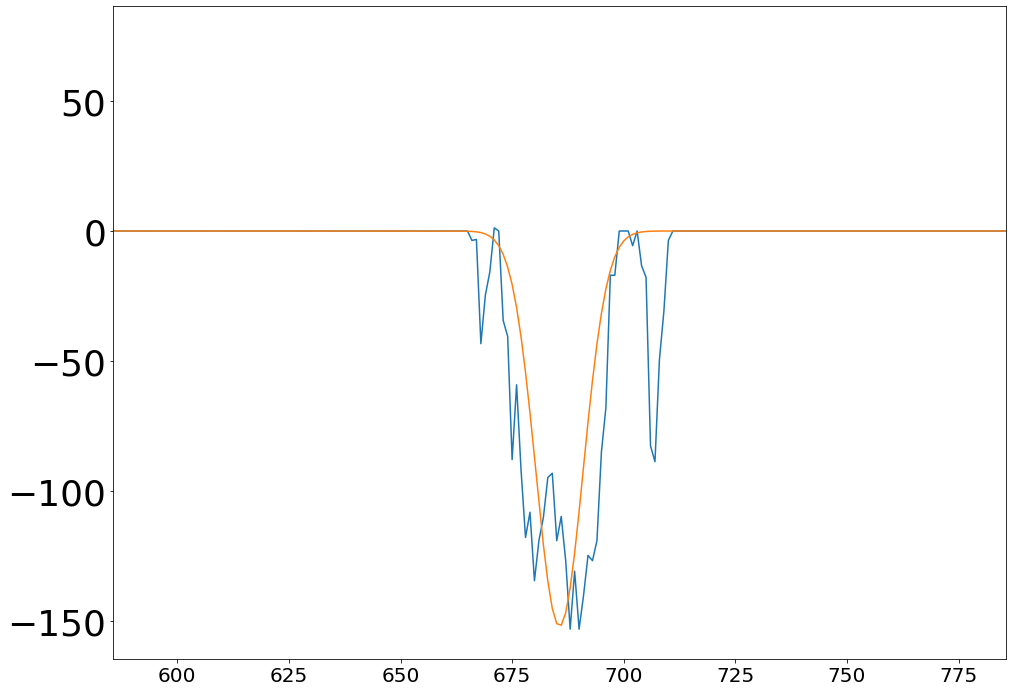

 16%|█▌        | 24/152 [00:03<00:18,  6.83it/s]

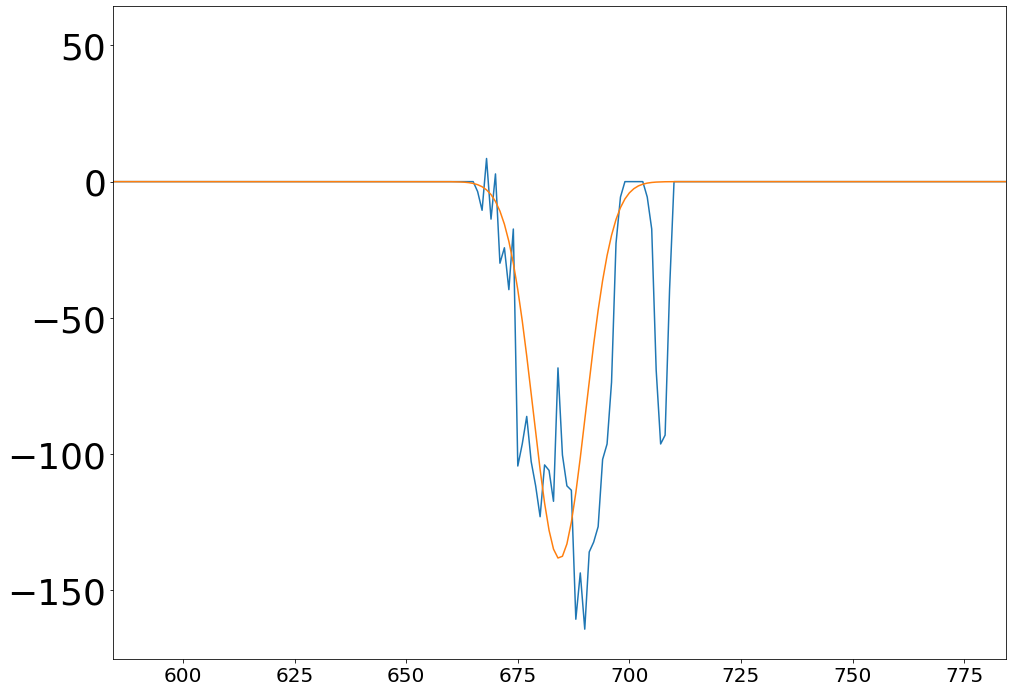

 16%|█▋        | 25/152 [00:03<00:18,  6.99it/s]

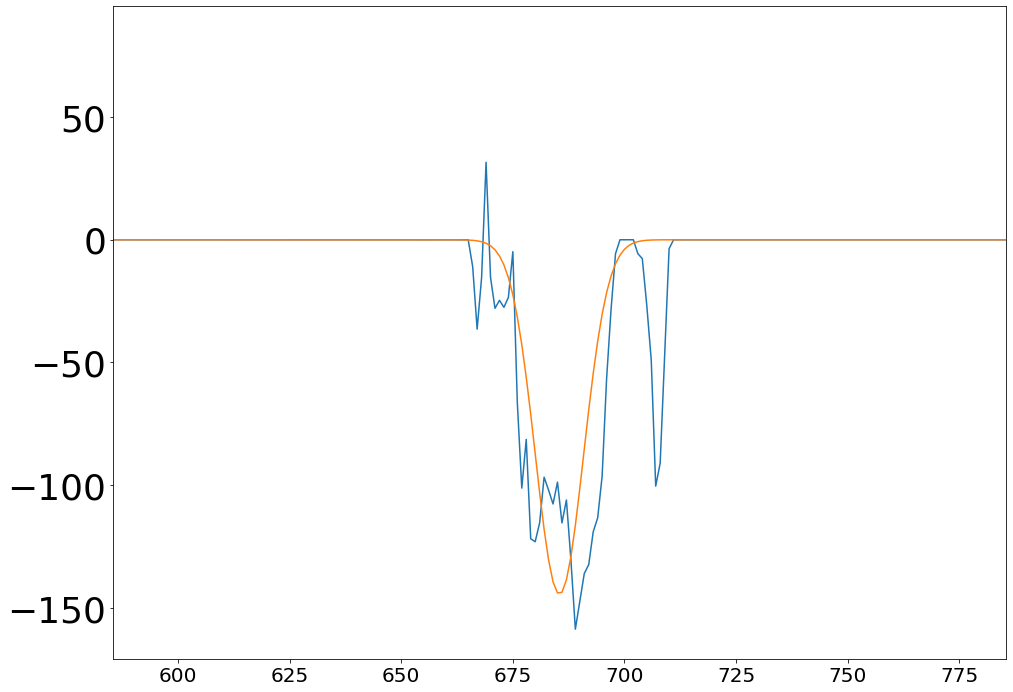

 17%|█▋        | 26/152 [00:03<00:17,  7.13it/s]

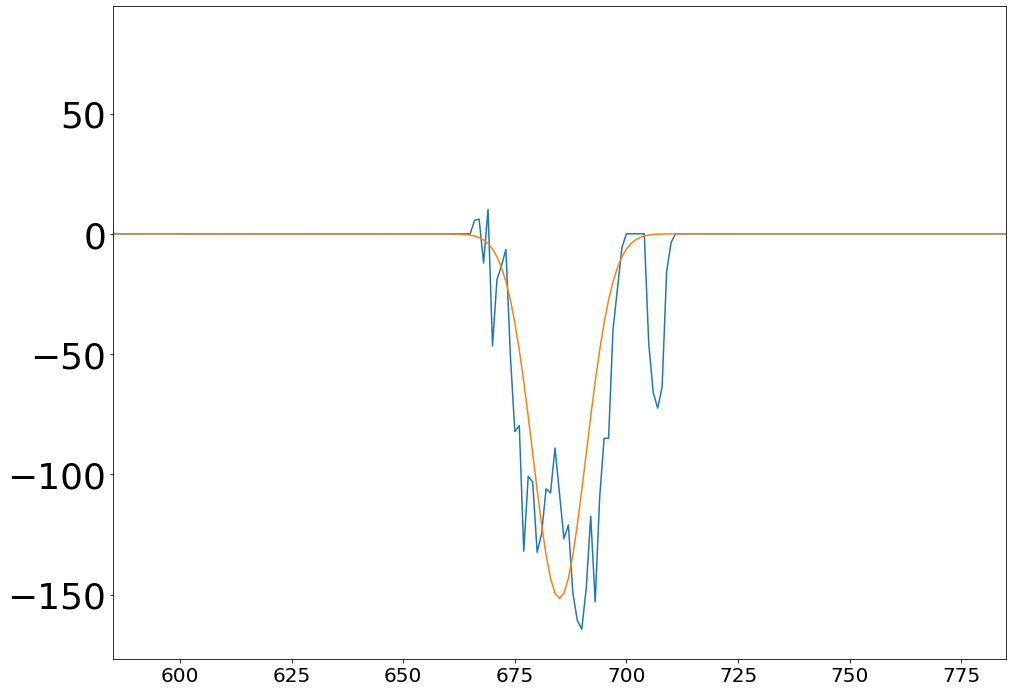

 18%|█▊        | 27/152 [00:03<00:17,  7.34it/s]

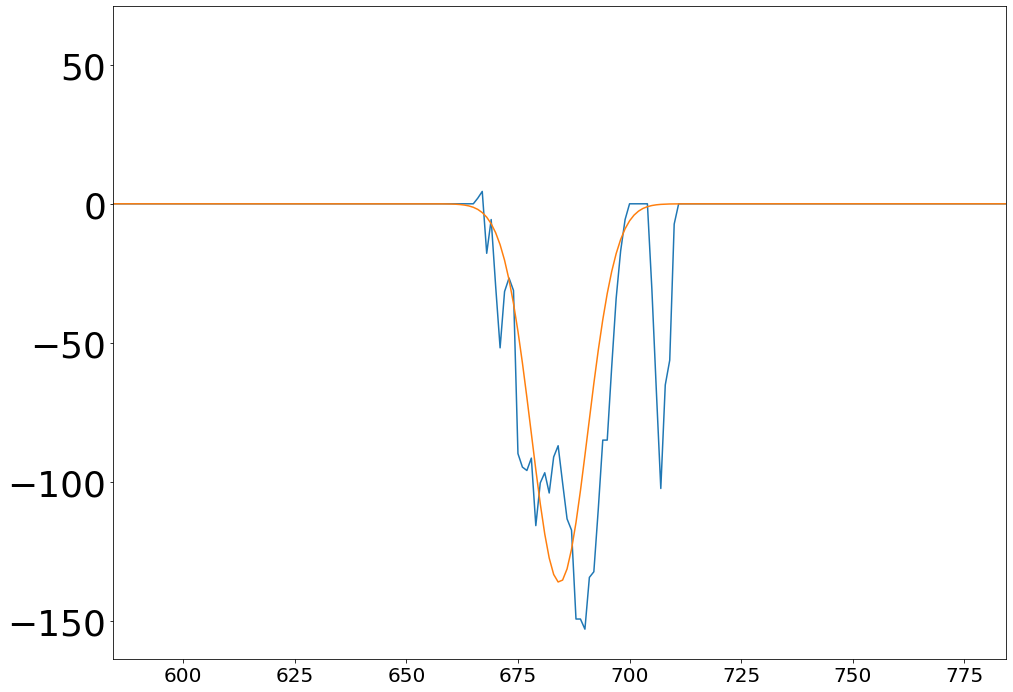

 18%|█▊        | 28/152 [00:03<00:16,  7.44it/s]

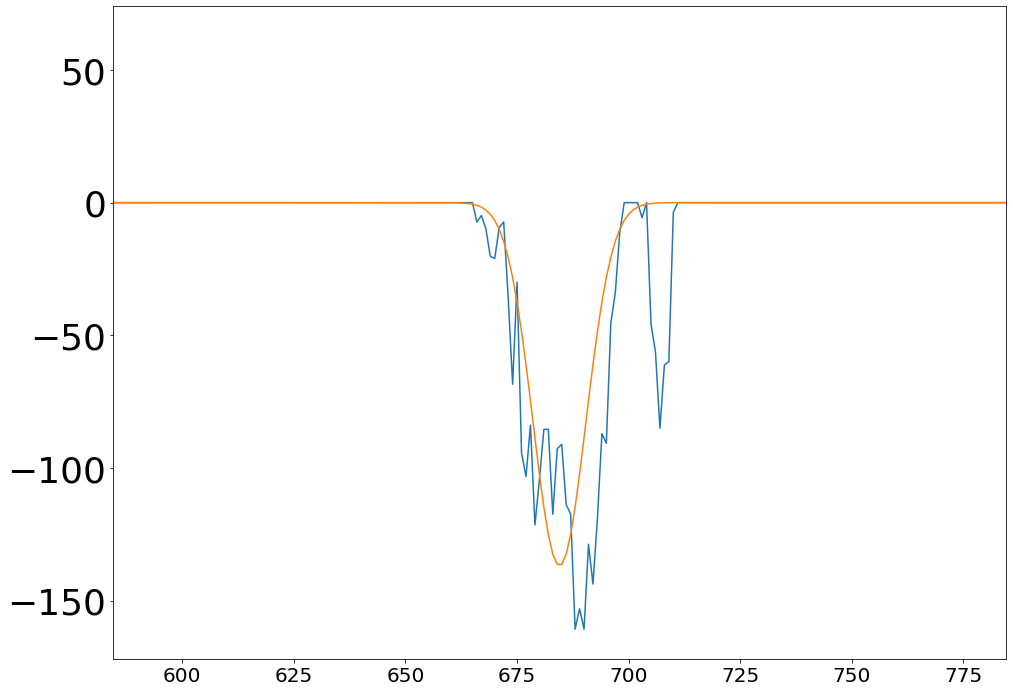

 19%|█▉        | 29/152 [00:04<00:16,  7.44it/s]

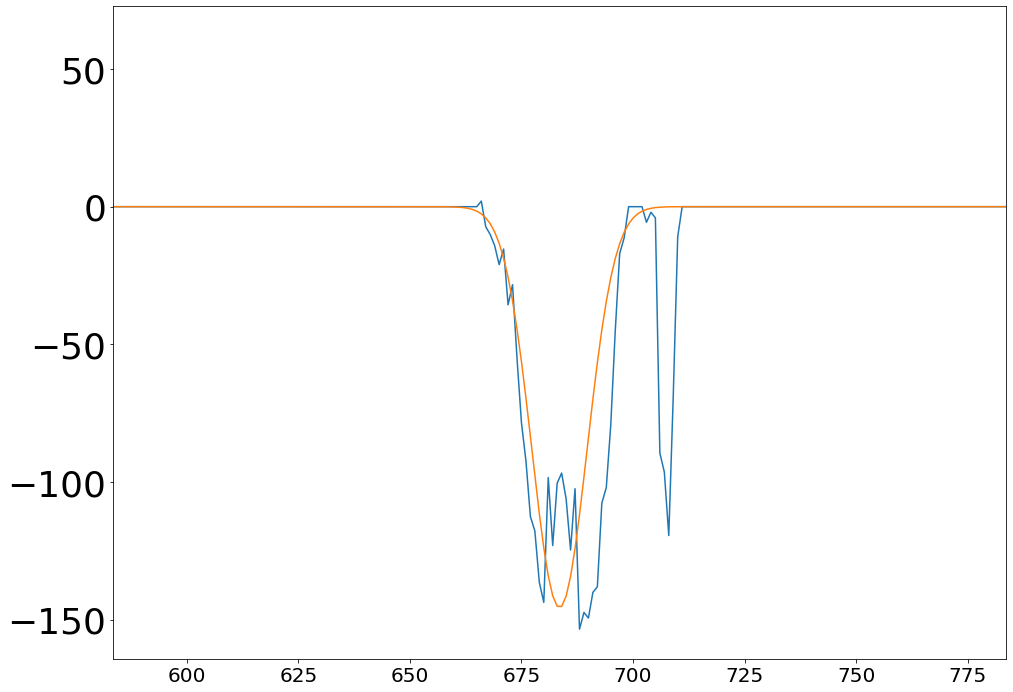

 20%|█▉        | 30/152 [00:04<00:16,  7.44it/s]

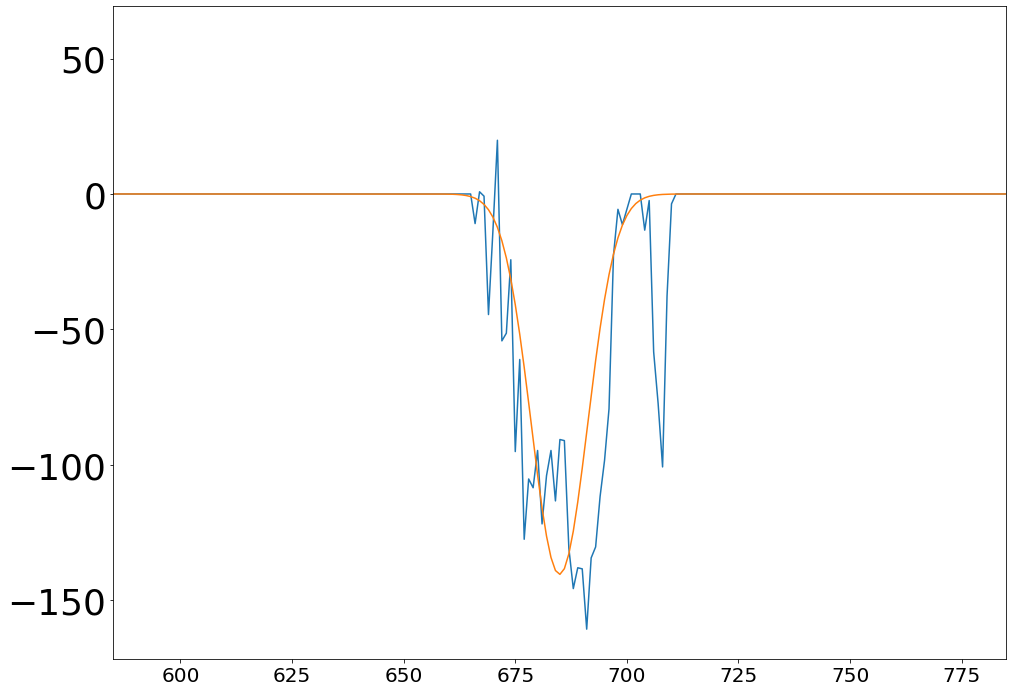

 20%|██        | 31/152 [00:04<00:16,  7.45it/s]

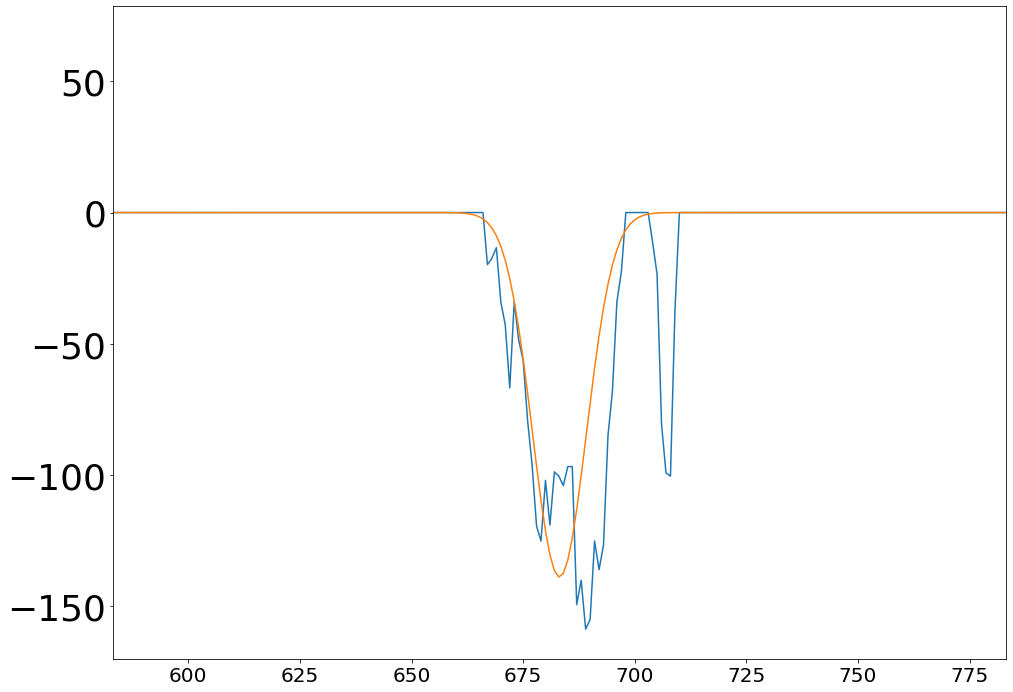

 21%|██        | 32/152 [00:04<00:16,  7.39it/s]

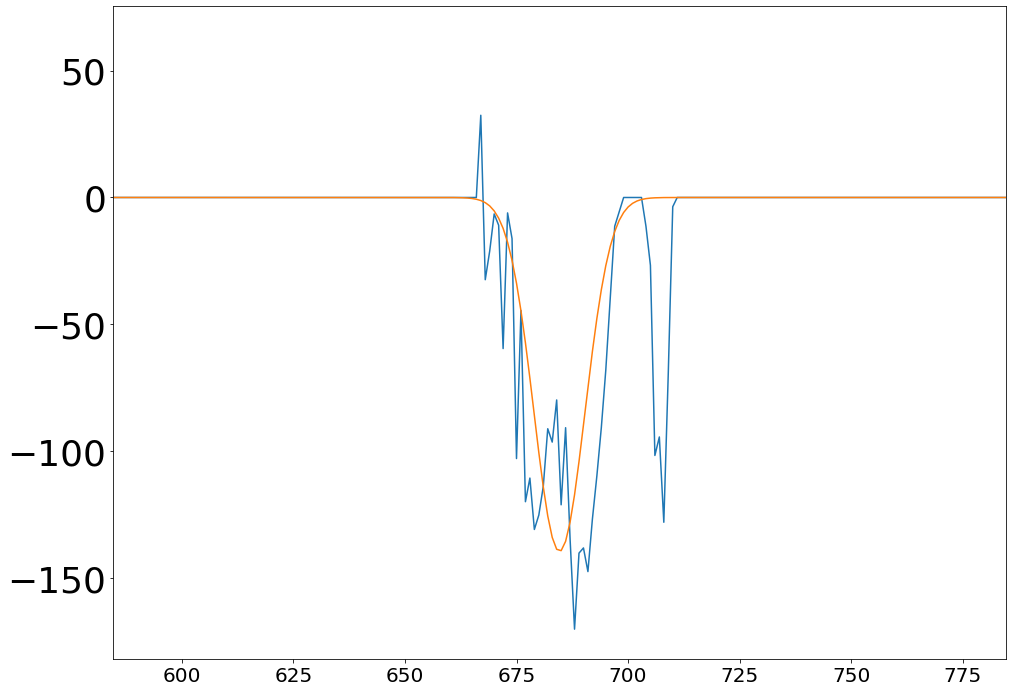

 22%|██▏       | 33/152 [00:04<00:16,  7.36it/s]

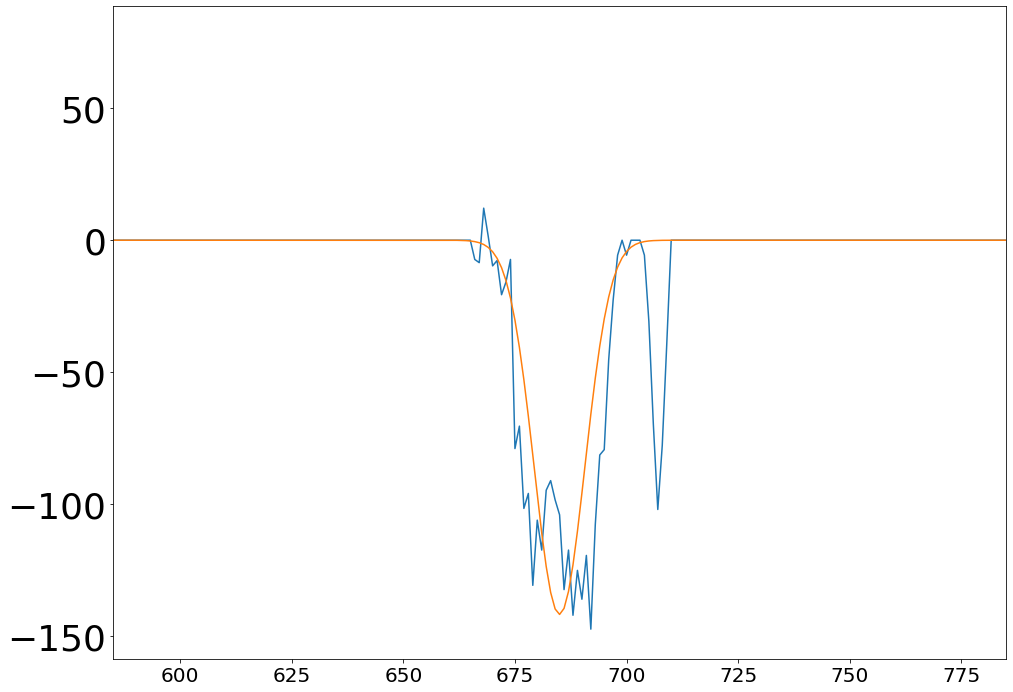

 22%|██▏       | 34/152 [00:04<00:15,  7.41it/s]

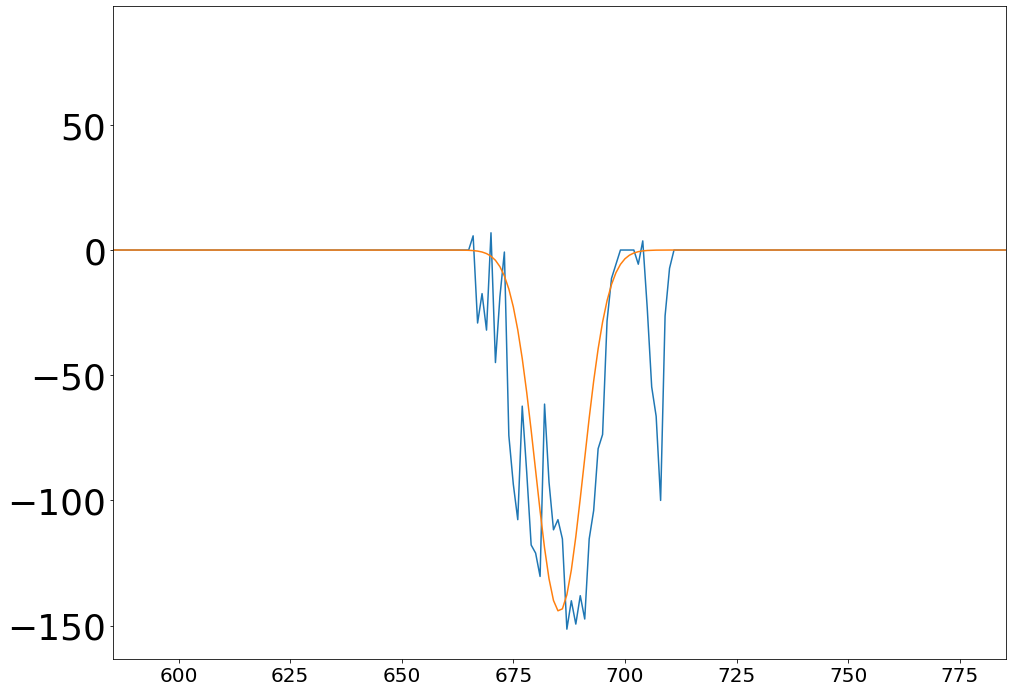

 23%|██▎       | 35/152 [00:04<00:15,  7.53it/s]

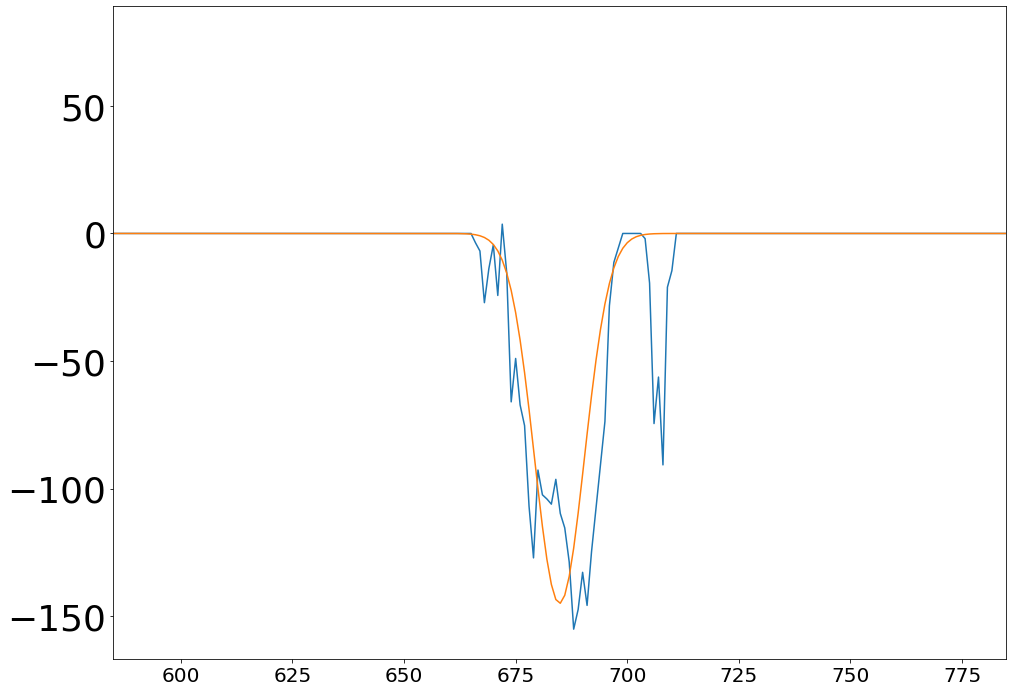

 24%|██▎       | 36/152 [00:05<00:15,  7.61it/s]

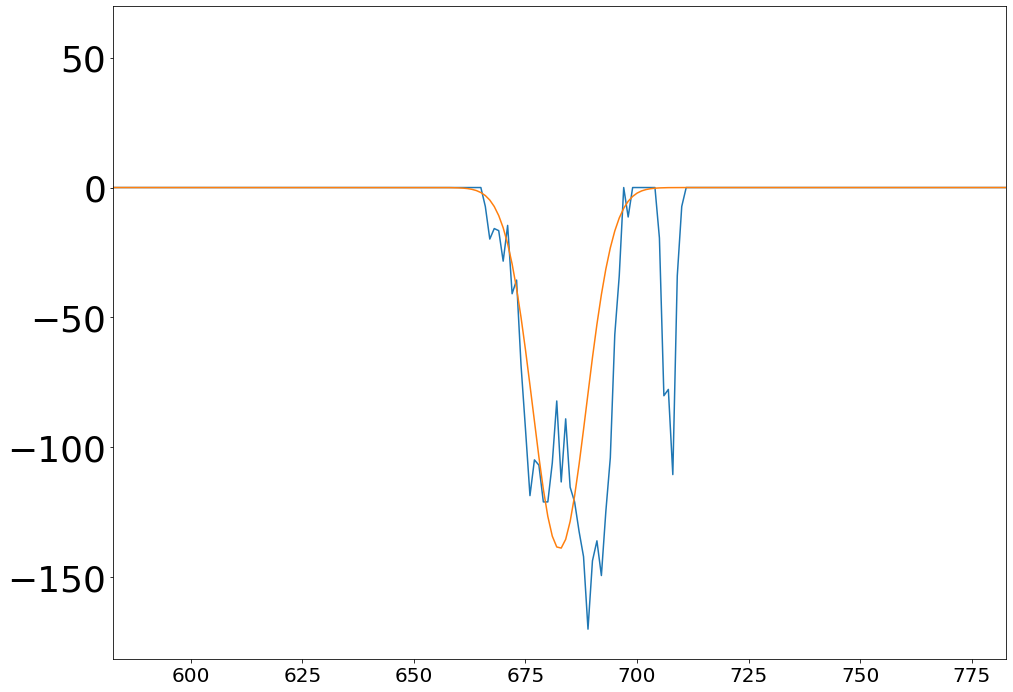

 24%|██▍       | 37/152 [00:05<00:17,  6.74it/s]

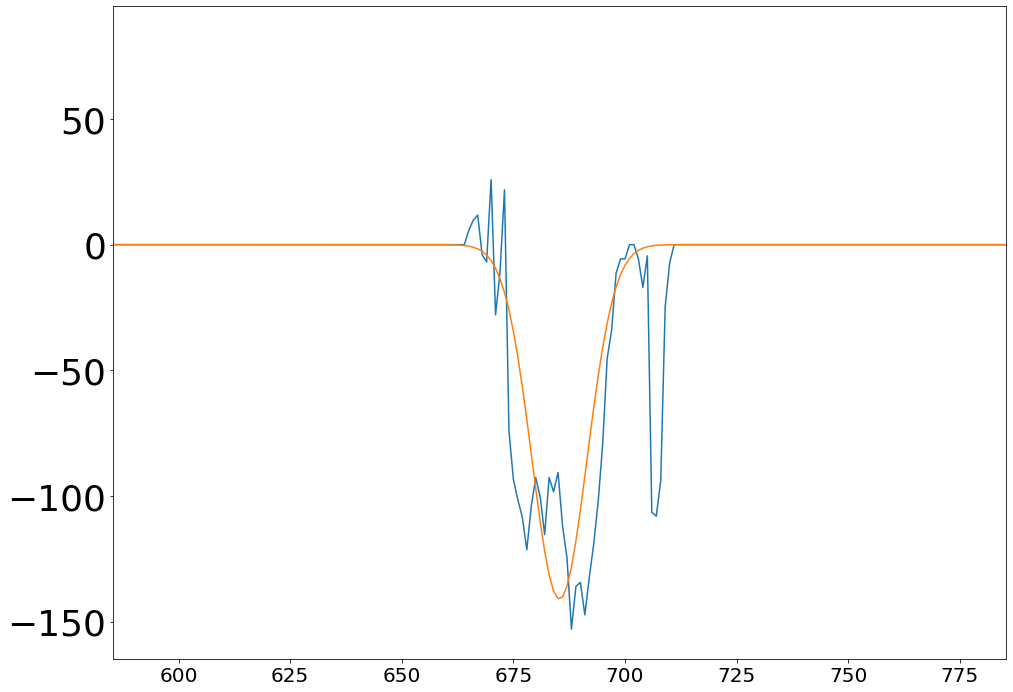

 25%|██▌       | 38/152 [00:05<00:16,  7.00it/s]

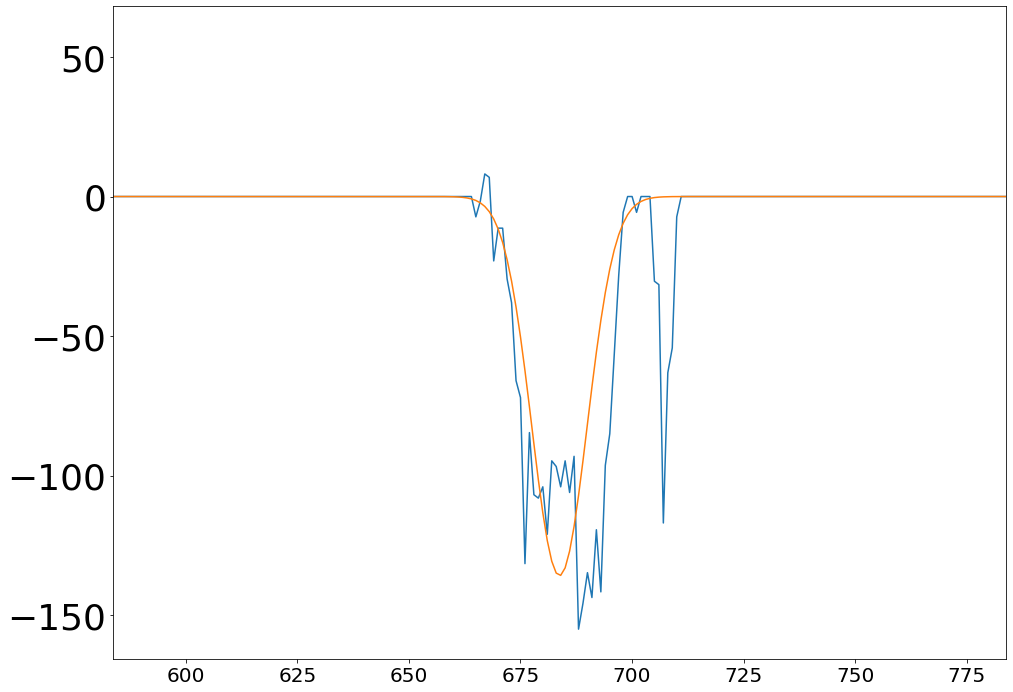

 26%|██▌       | 39/152 [00:05<00:15,  7.11it/s]

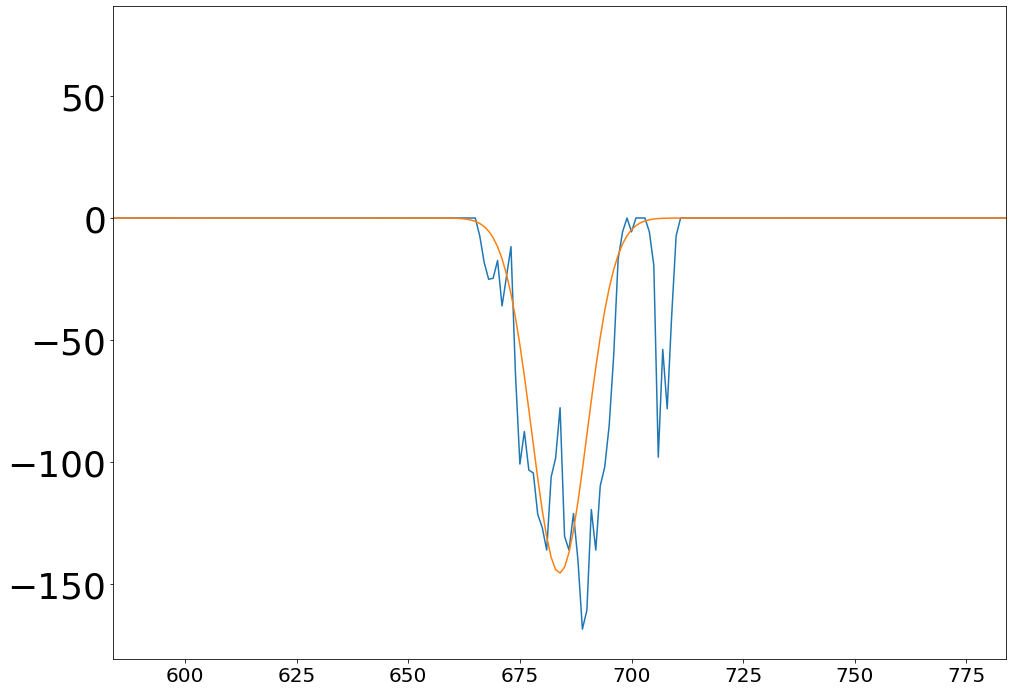

 26%|██▋       | 40/152 [00:05<00:15,  7.27it/s]

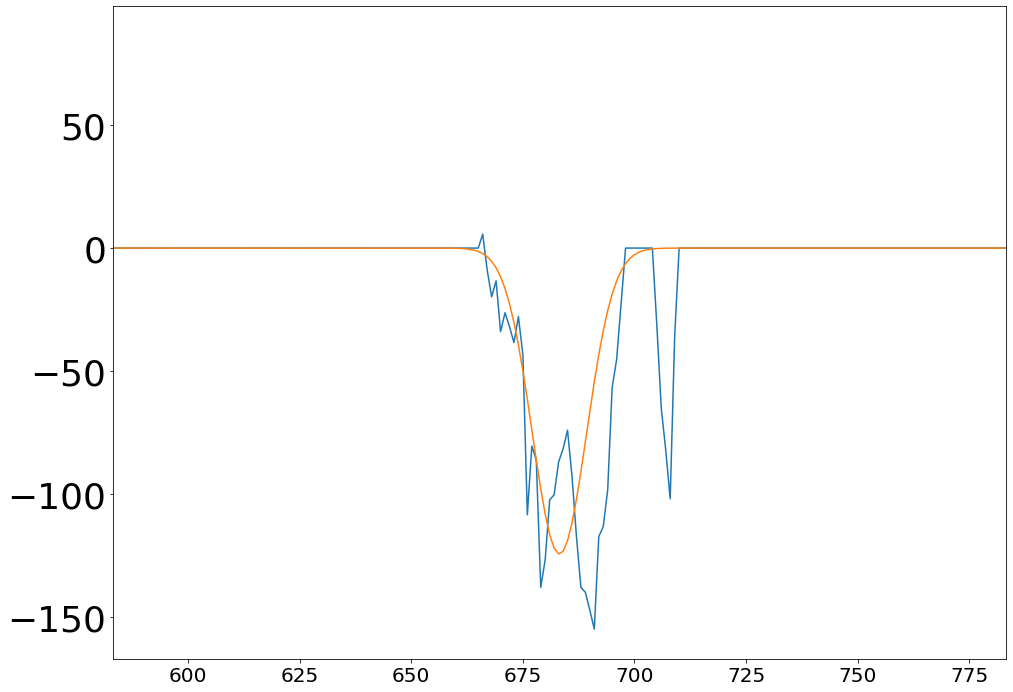

 27%|██▋       | 41/152 [00:05<00:15,  7.29it/s]

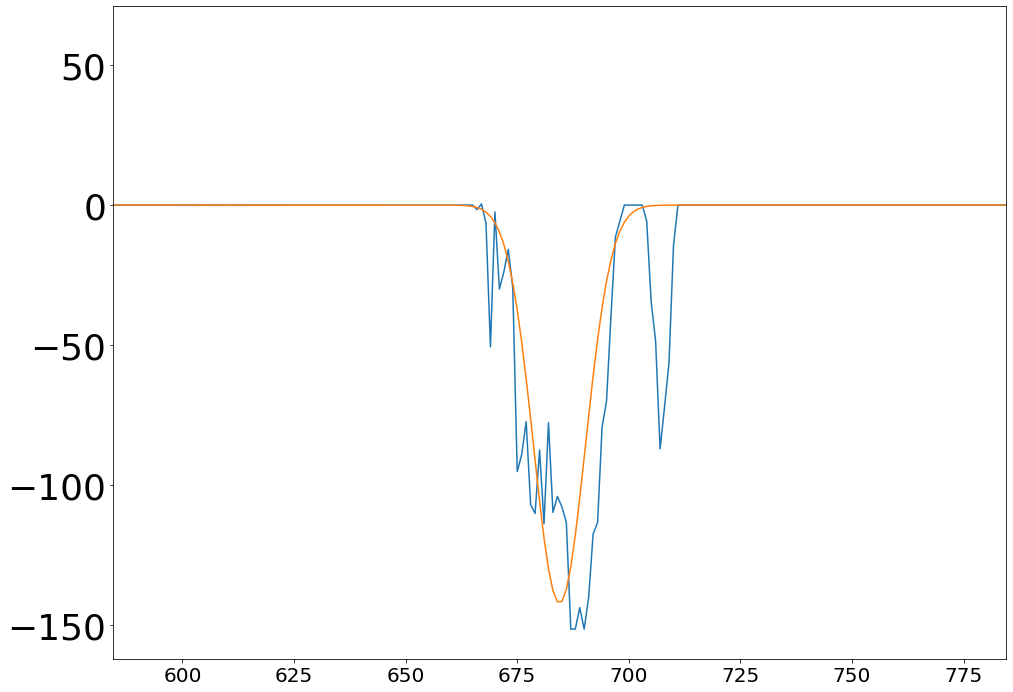

 28%|██▊       | 42/152 [00:05<00:14,  7.39it/s]

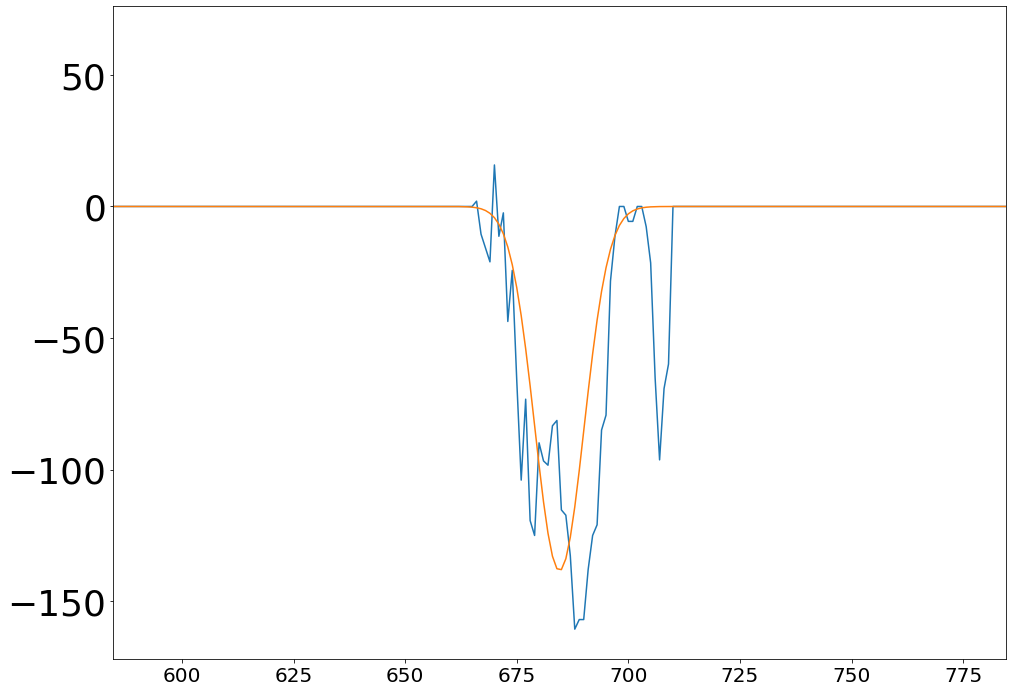

 28%|██▊       | 43/152 [00:06<00:14,  7.43it/s]

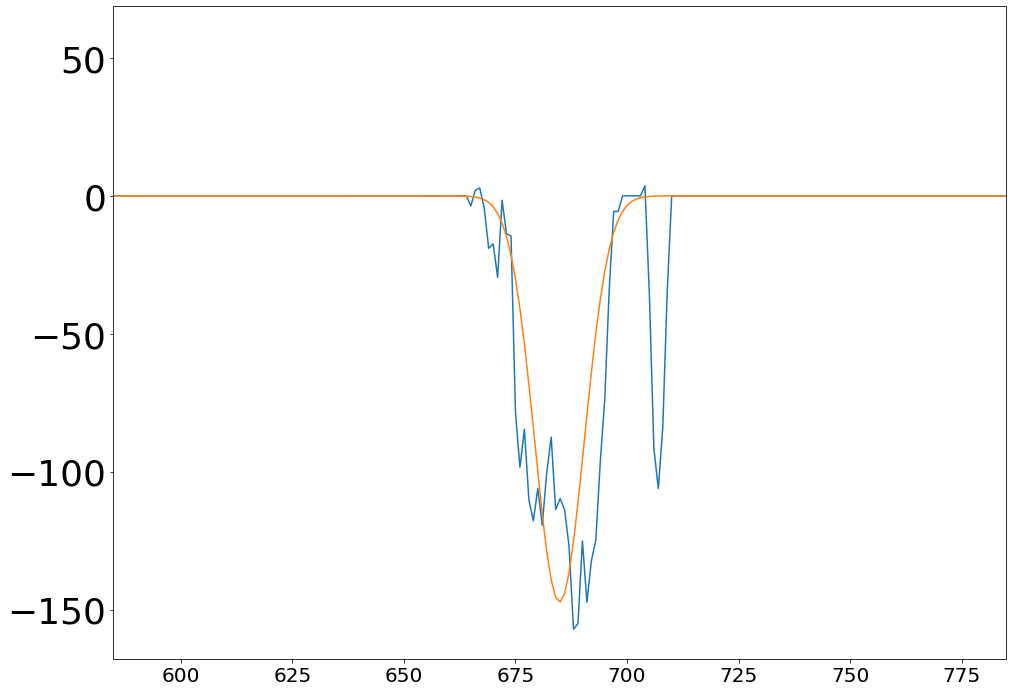

 29%|██▉       | 44/152 [00:06<00:14,  7.49it/s]

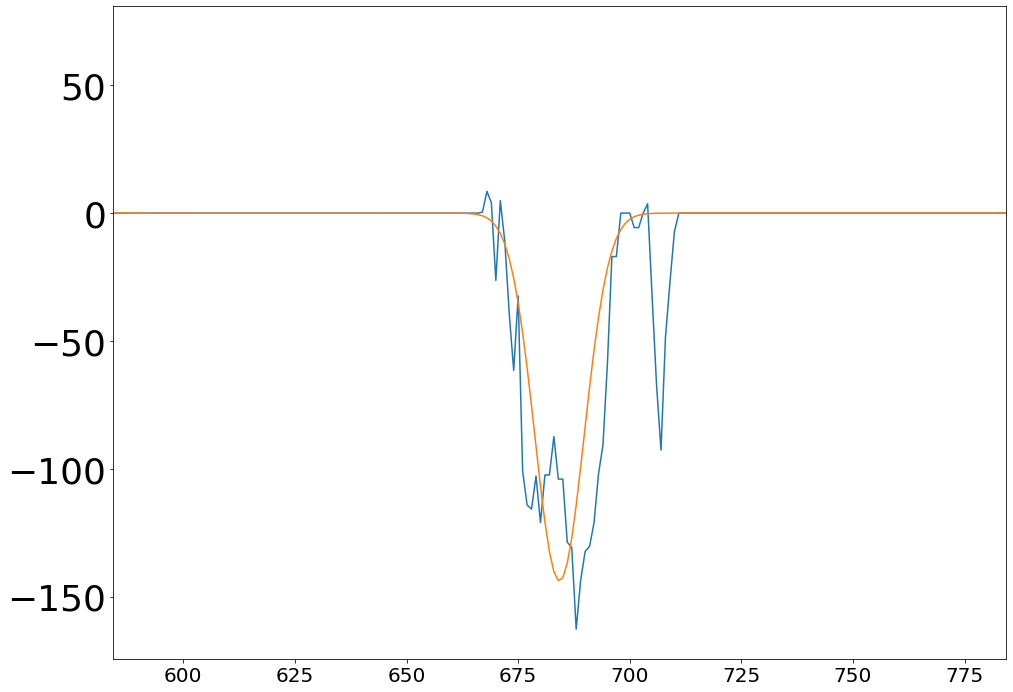

 30%|██▉       | 45/152 [00:06<00:14,  7.48it/s]

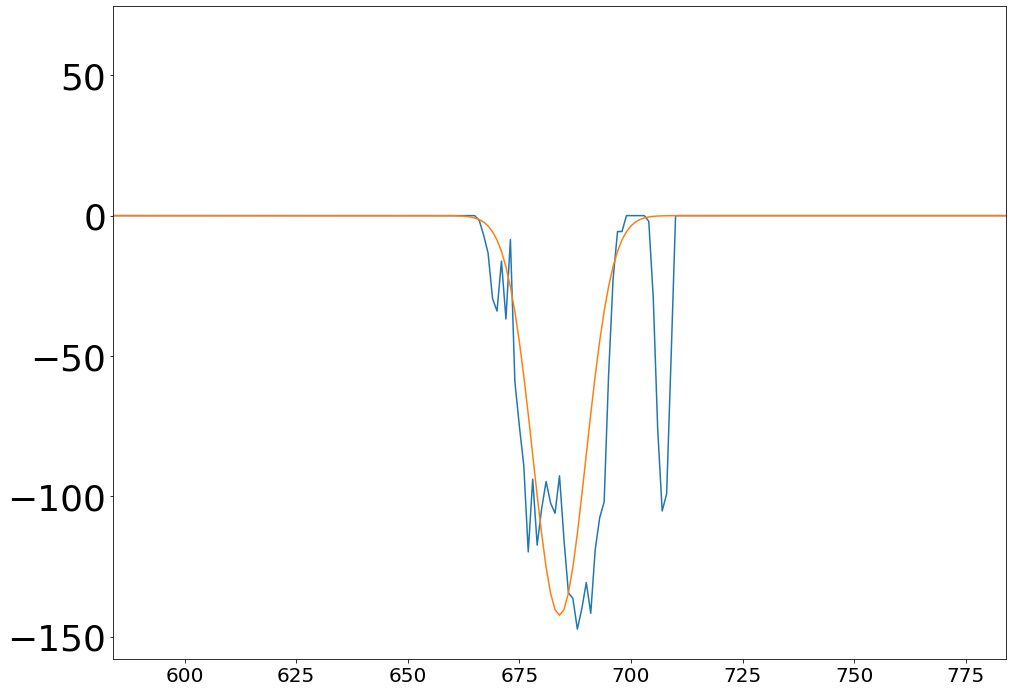

 30%|███       | 46/152 [00:06<00:14,  7.51it/s]

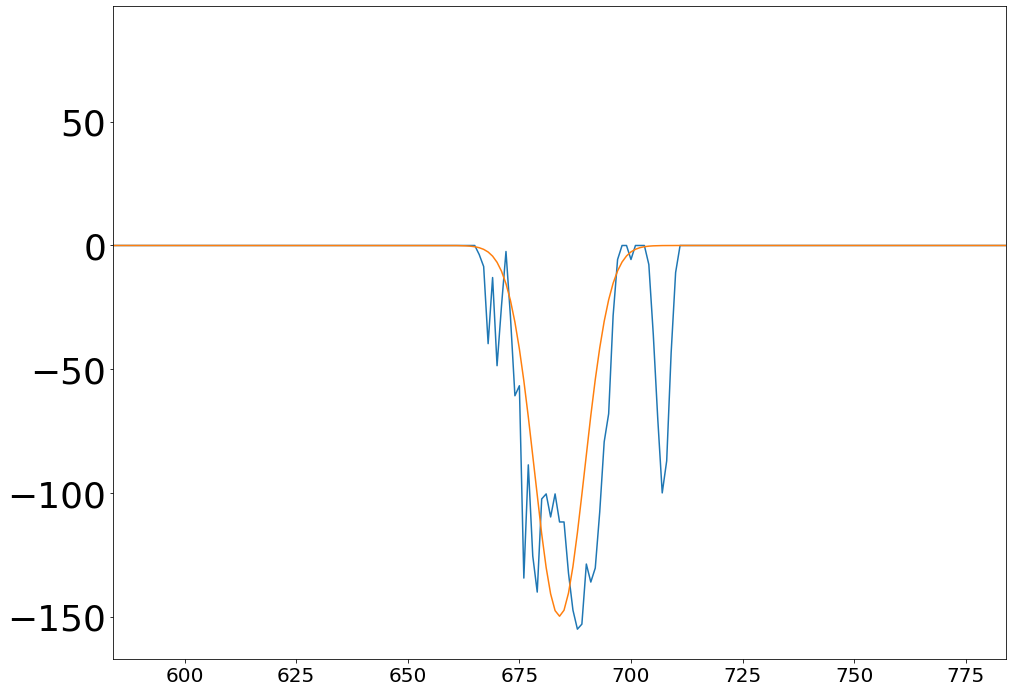

 31%|███       | 47/152 [00:06<00:13,  7.57it/s]

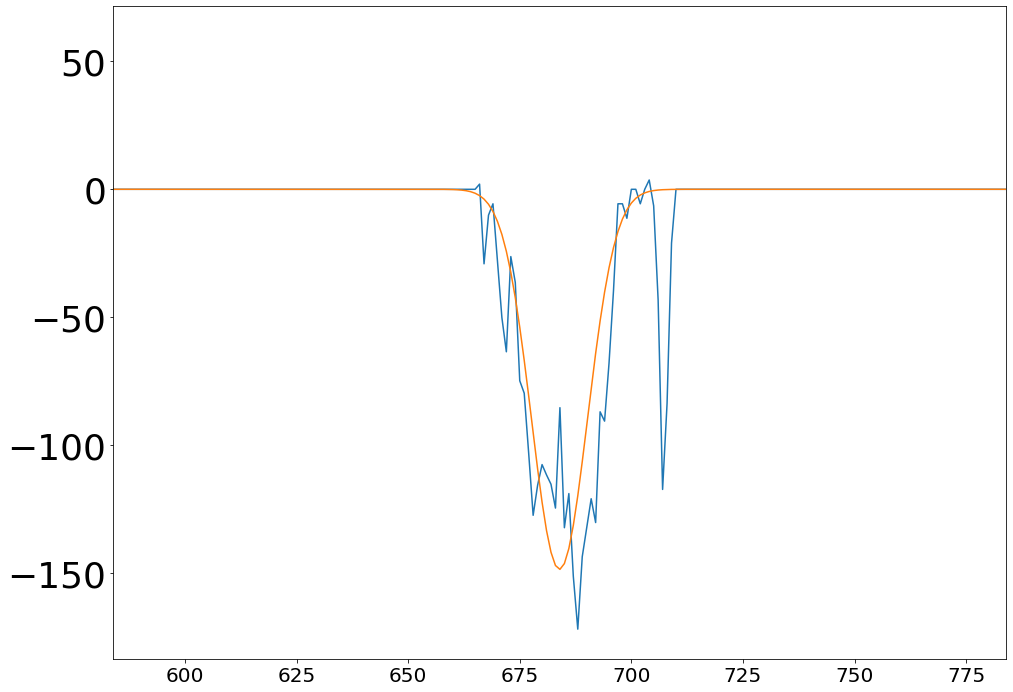

 32%|███▏      | 48/152 [00:06<00:13,  7.52it/s]

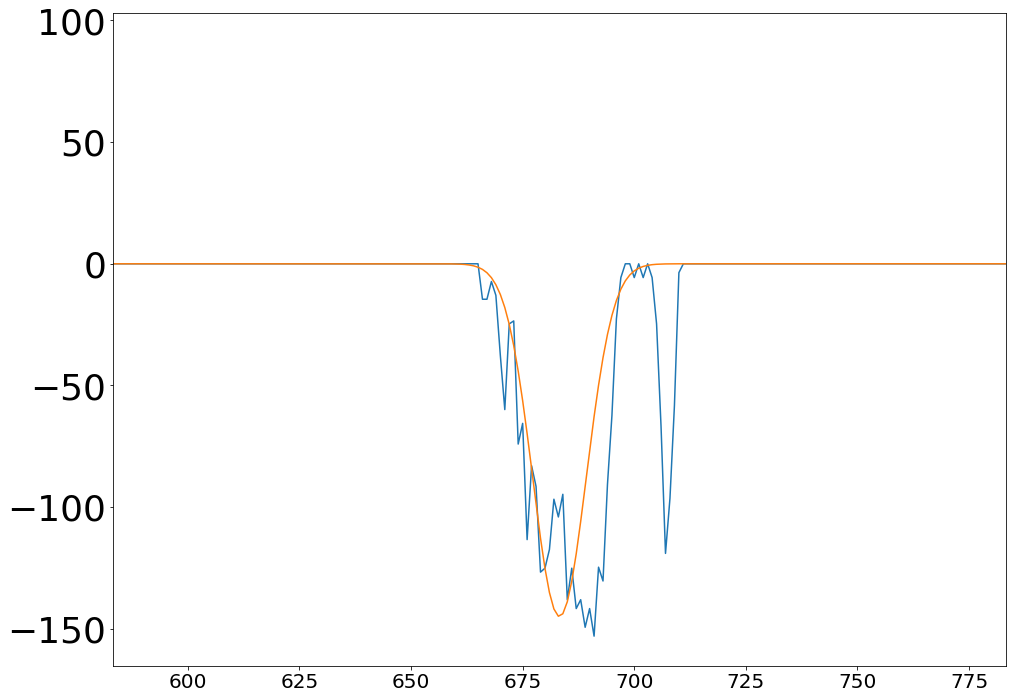

 32%|███▏      | 49/152 [00:06<00:13,  7.46it/s]

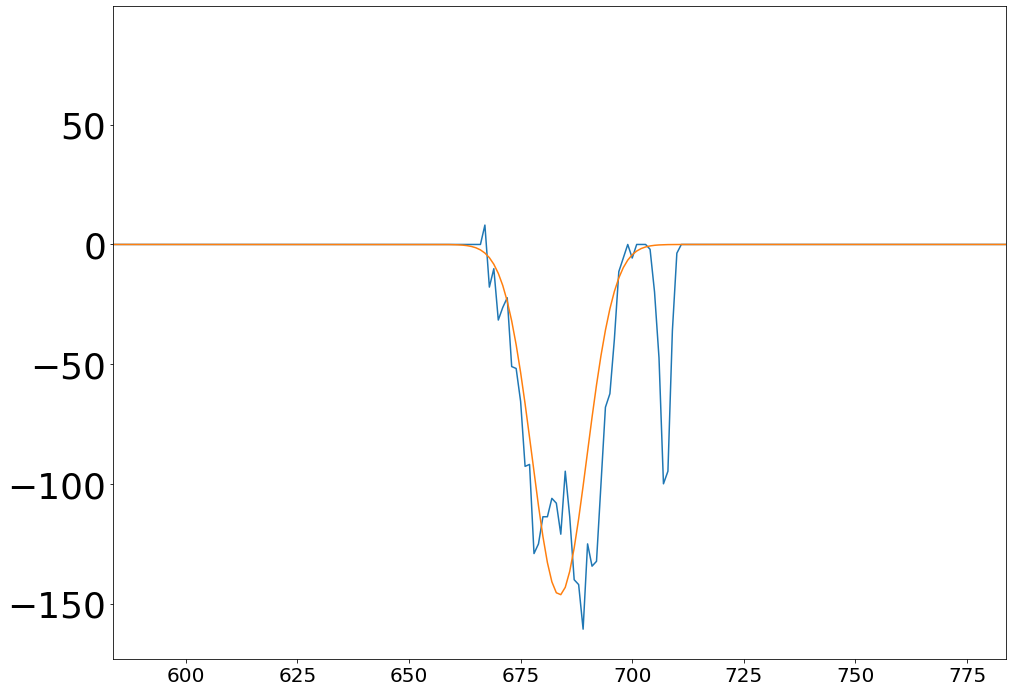

 33%|███▎      | 50/152 [00:06<00:13,  7.45it/s]

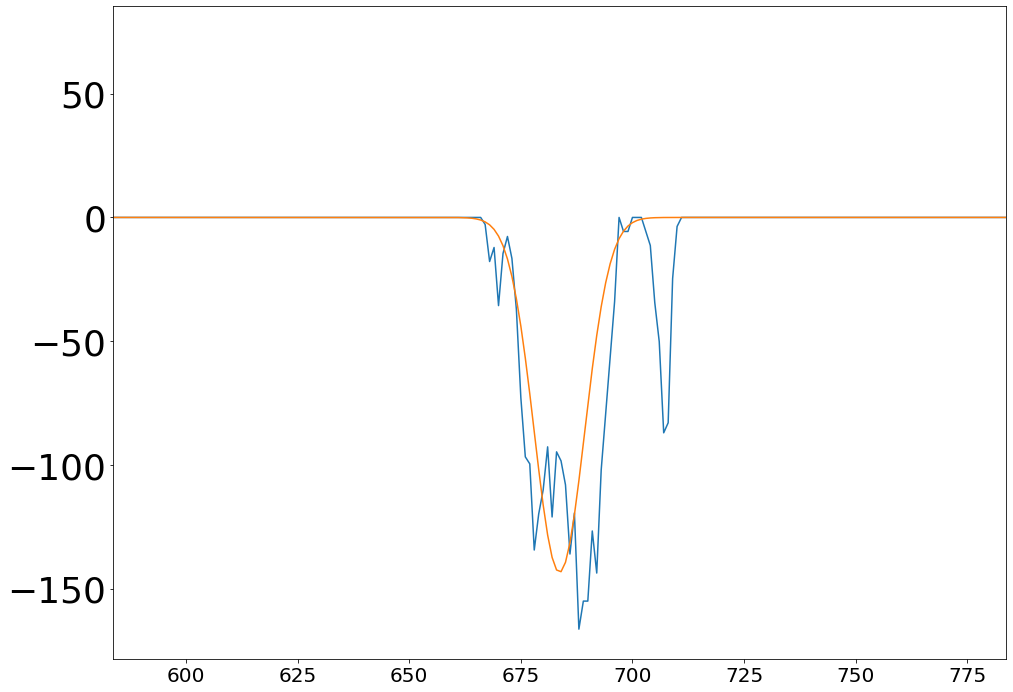

 34%|███▎      | 51/152 [00:07<00:14,  6.78it/s]

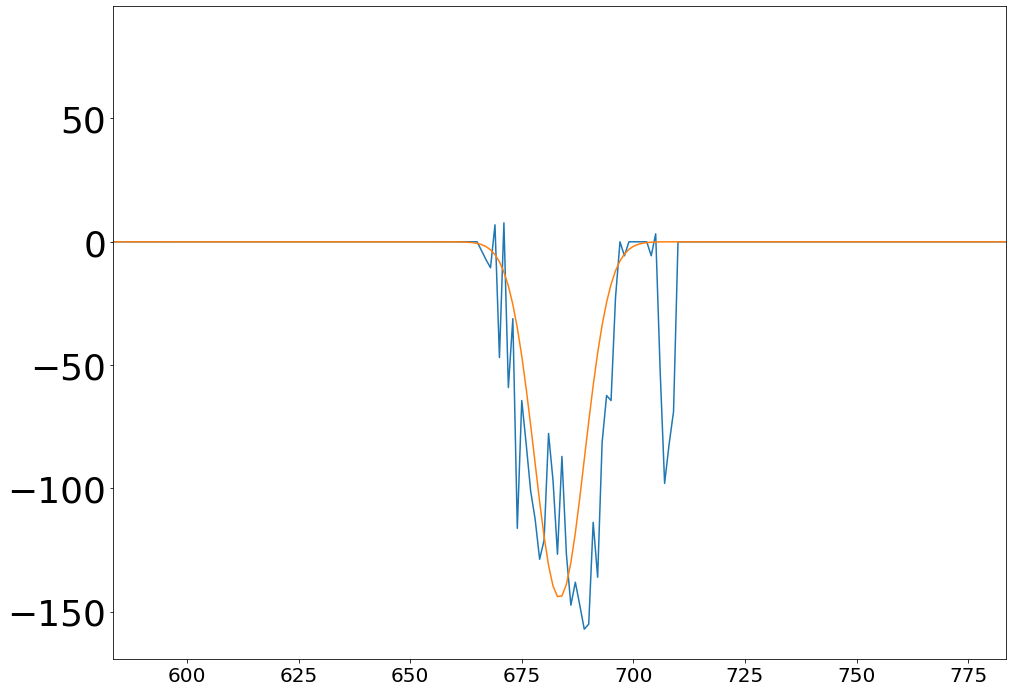

 34%|███▍      | 52/152 [00:07<00:14,  6.99it/s]

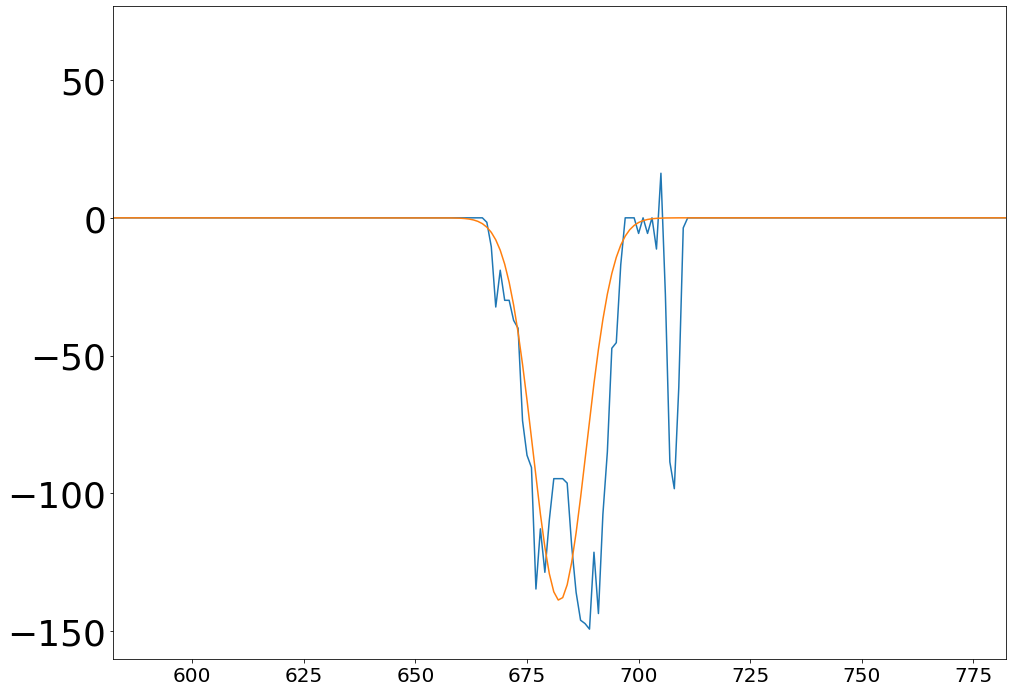

 35%|███▍      | 53/152 [00:07<00:13,  7.11it/s]

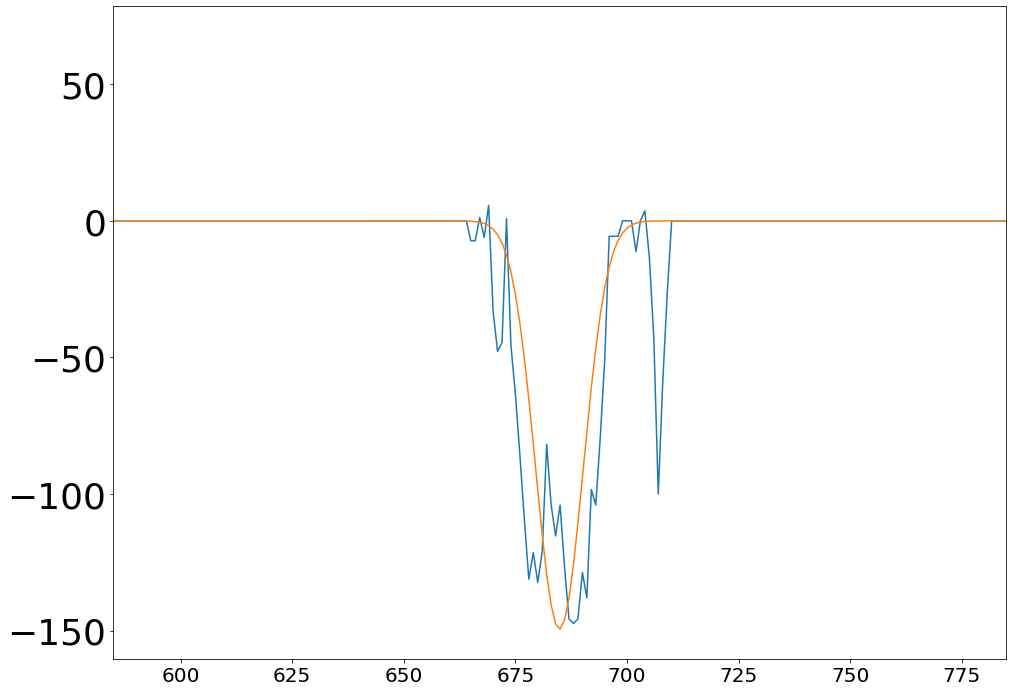

 36%|███▌      | 54/152 [00:07<00:13,  7.23it/s]

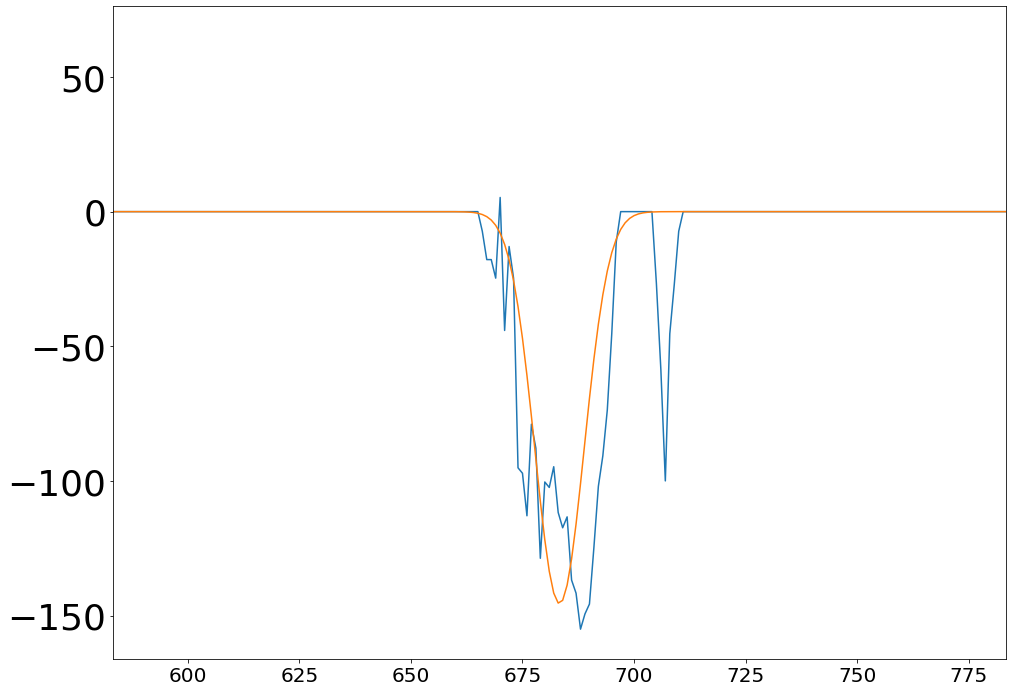

 36%|███▌      | 55/152 [00:07<00:13,  7.31it/s]

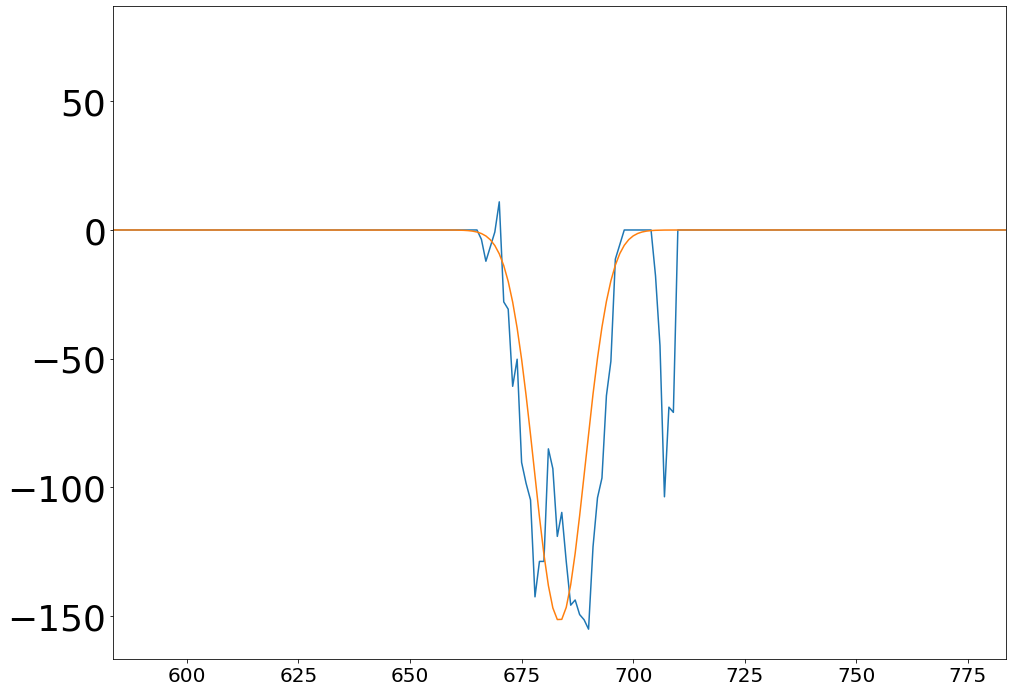

 37%|███▋      | 56/152 [00:07<00:12,  7.43it/s]

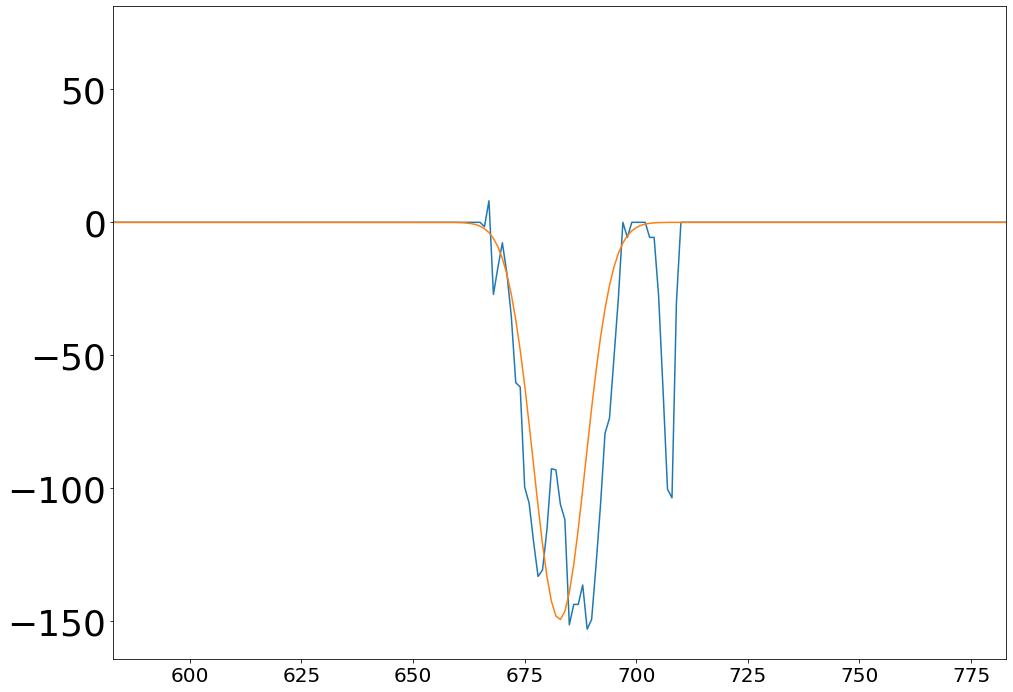

 38%|███▊      | 57/152 [00:07<00:12,  7.49it/s]

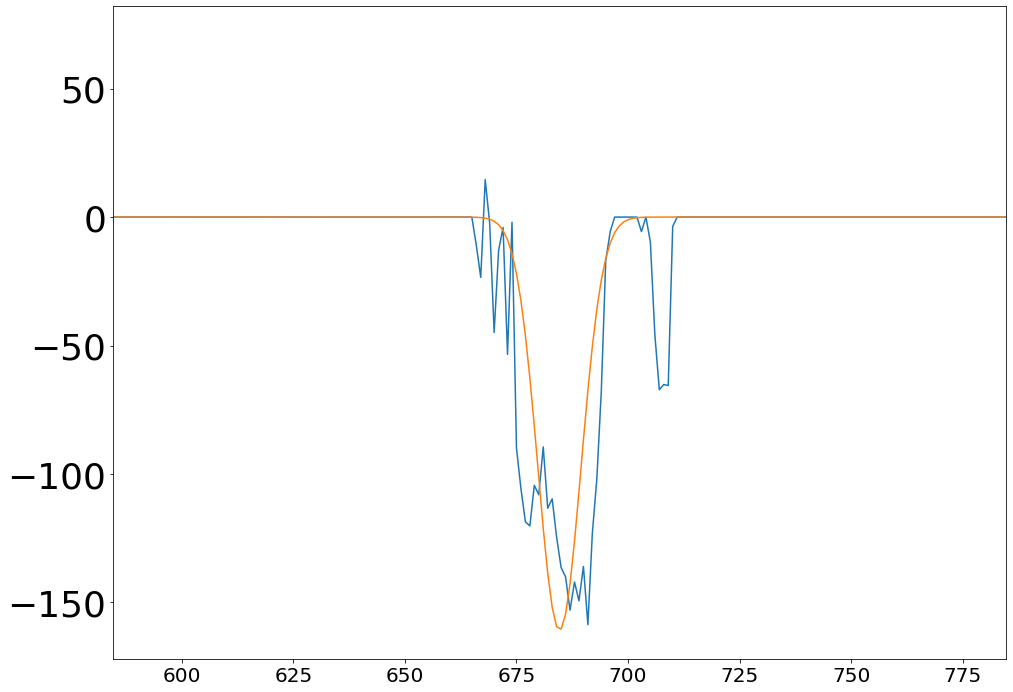

 38%|███▊      | 58/152 [00:08<00:12,  7.47it/s]

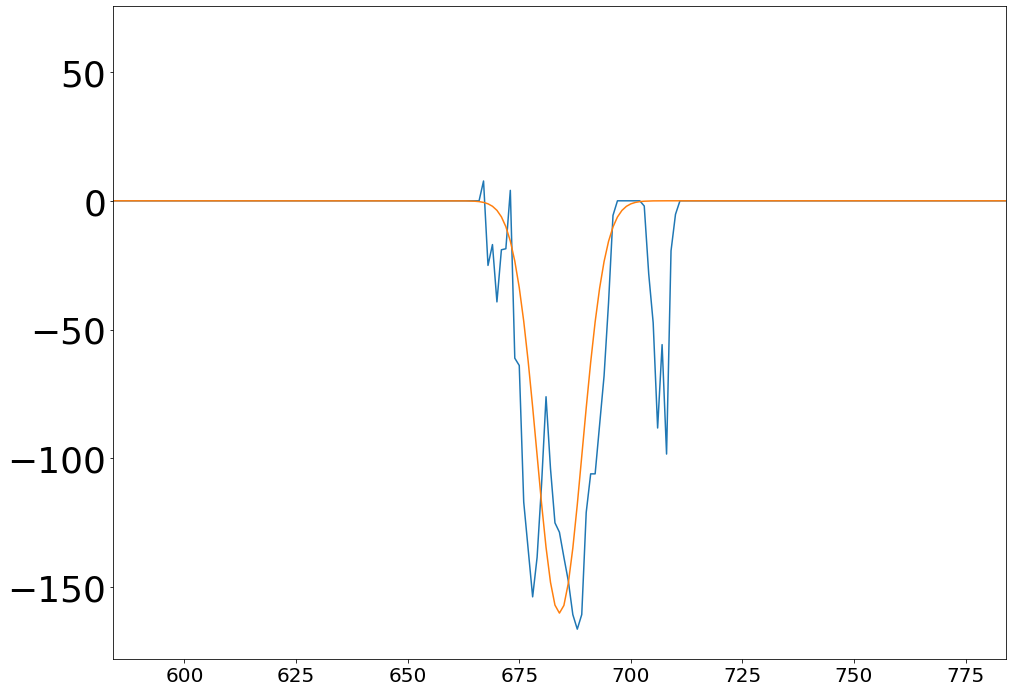

 39%|███▉      | 59/152 [00:08<00:12,  7.51it/s]

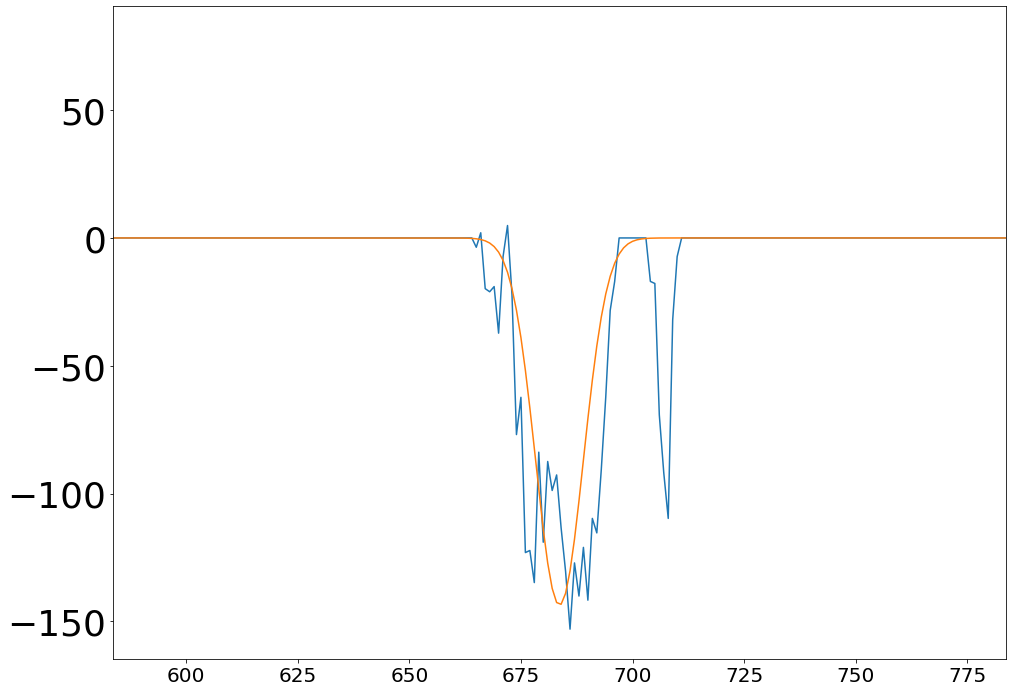

 39%|███▉      | 60/152 [00:08<00:12,  7.57it/s]

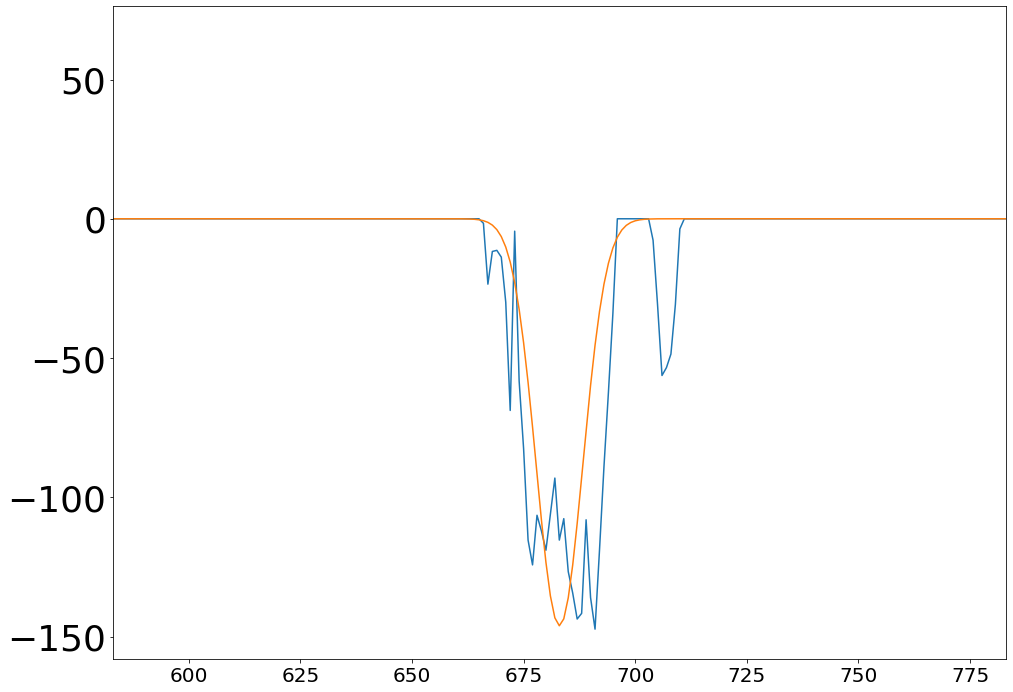

 40%|████      | 61/152 [00:08<00:12,  7.58it/s]

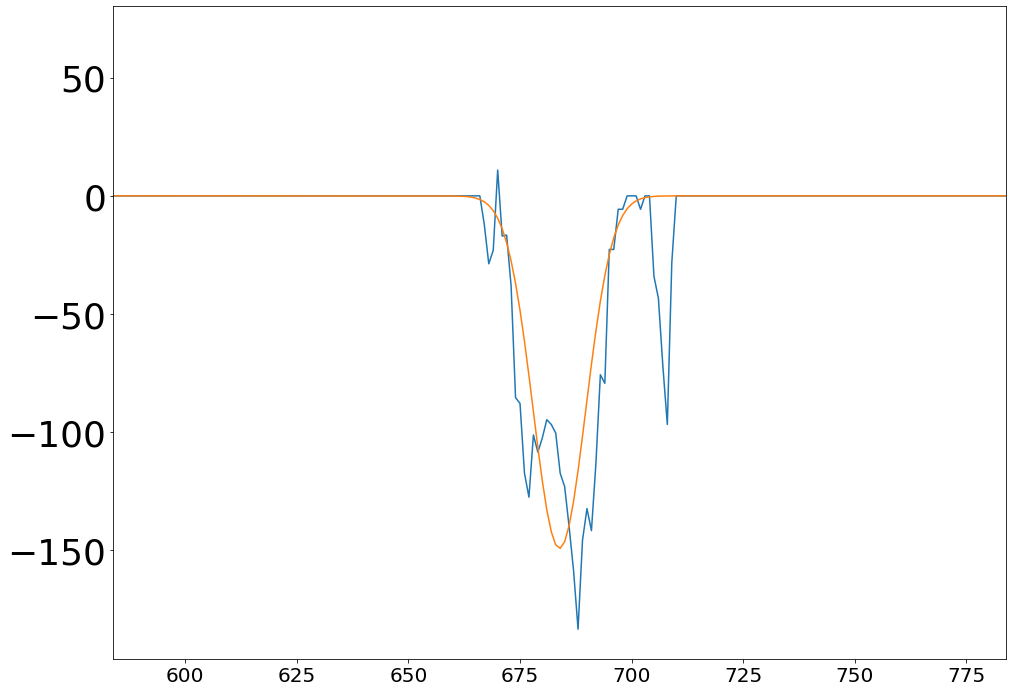

 41%|████      | 62/152 [00:08<00:11,  7.58it/s]

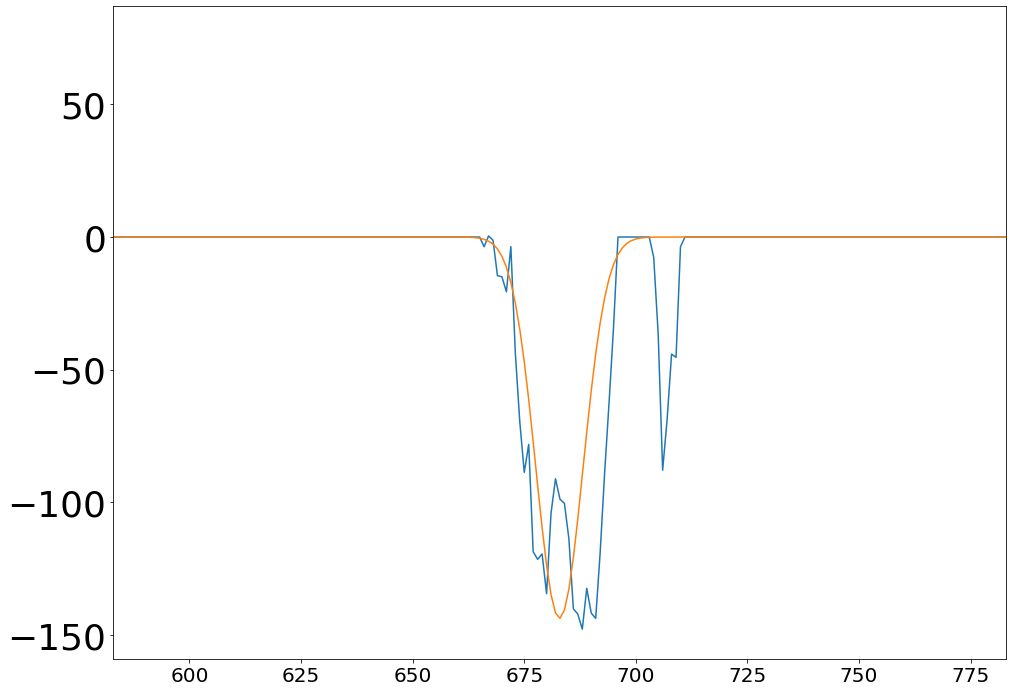

 41%|████▏     | 63/152 [00:08<00:11,  7.56it/s]

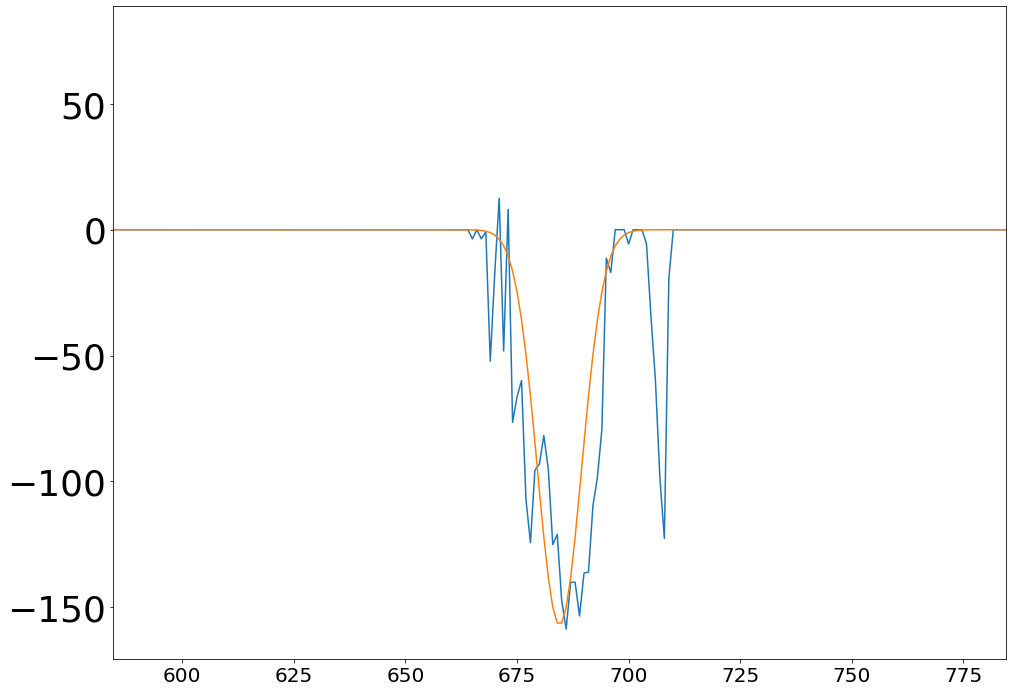

 42%|████▏     | 64/152 [00:08<00:11,  7.57it/s]

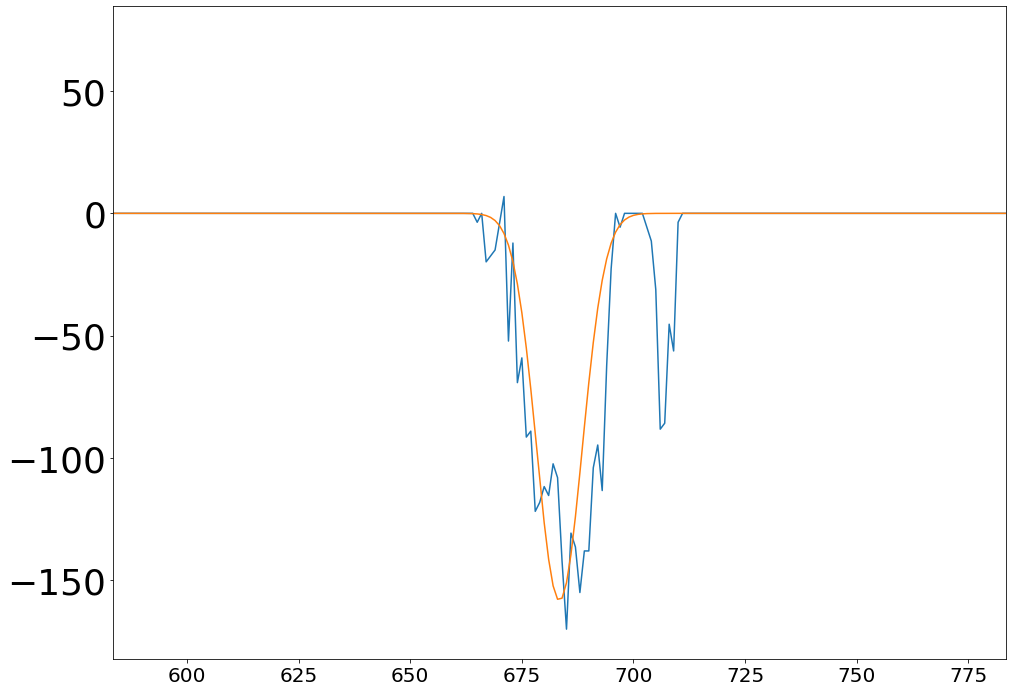

 43%|████▎     | 65/152 [00:09<00:12,  6.77it/s]

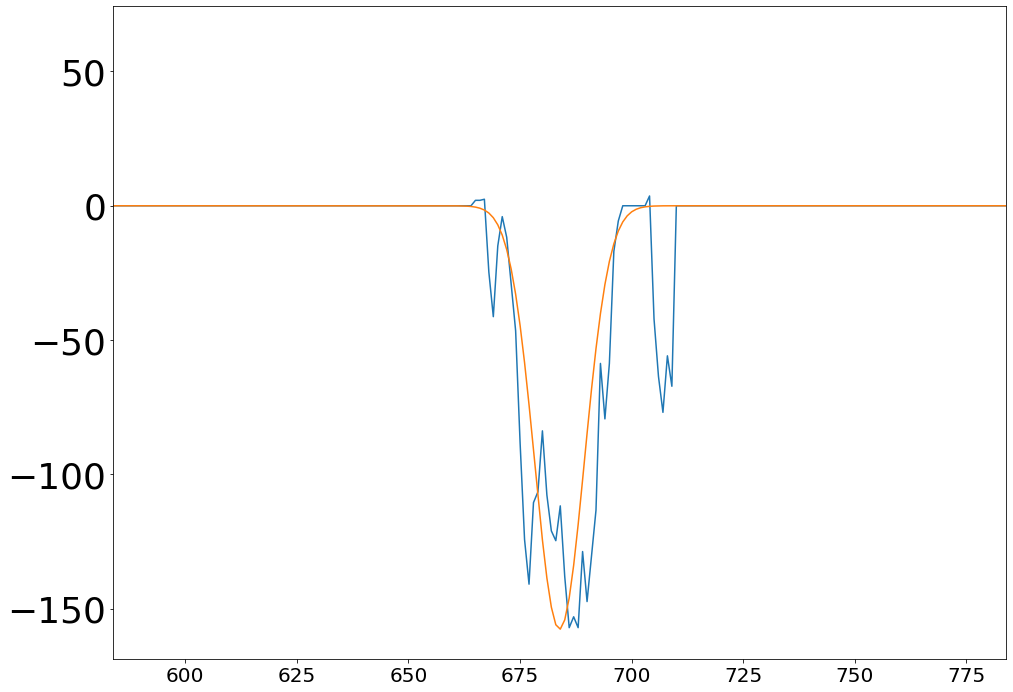

 43%|████▎     | 66/152 [00:09<00:12,  7.08it/s]

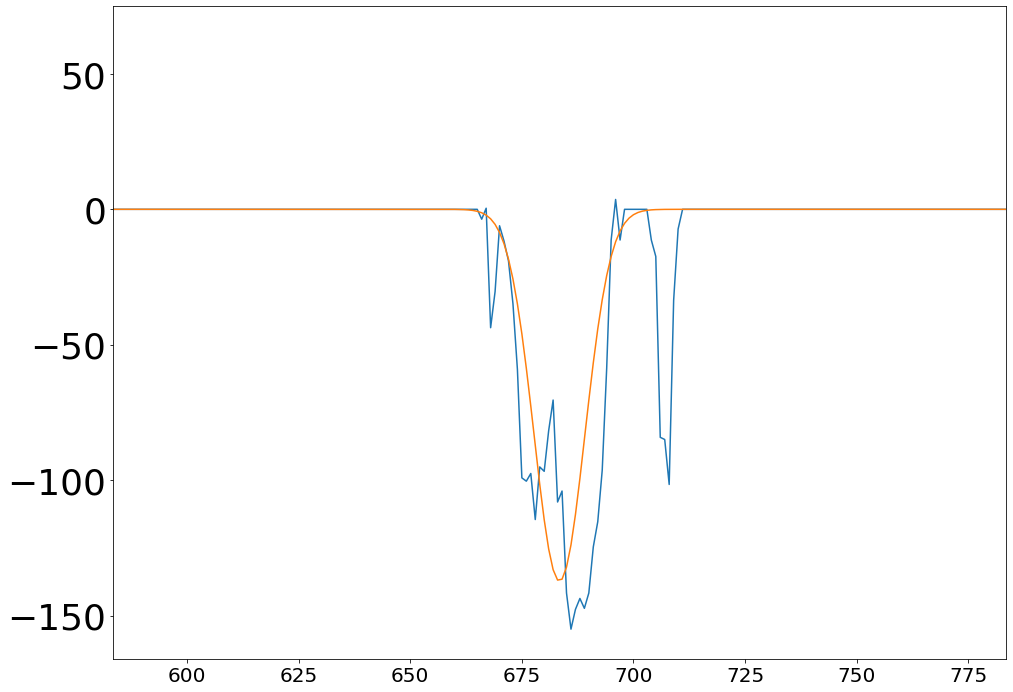

 44%|████▍     | 67/152 [00:09<00:11,  7.15it/s]

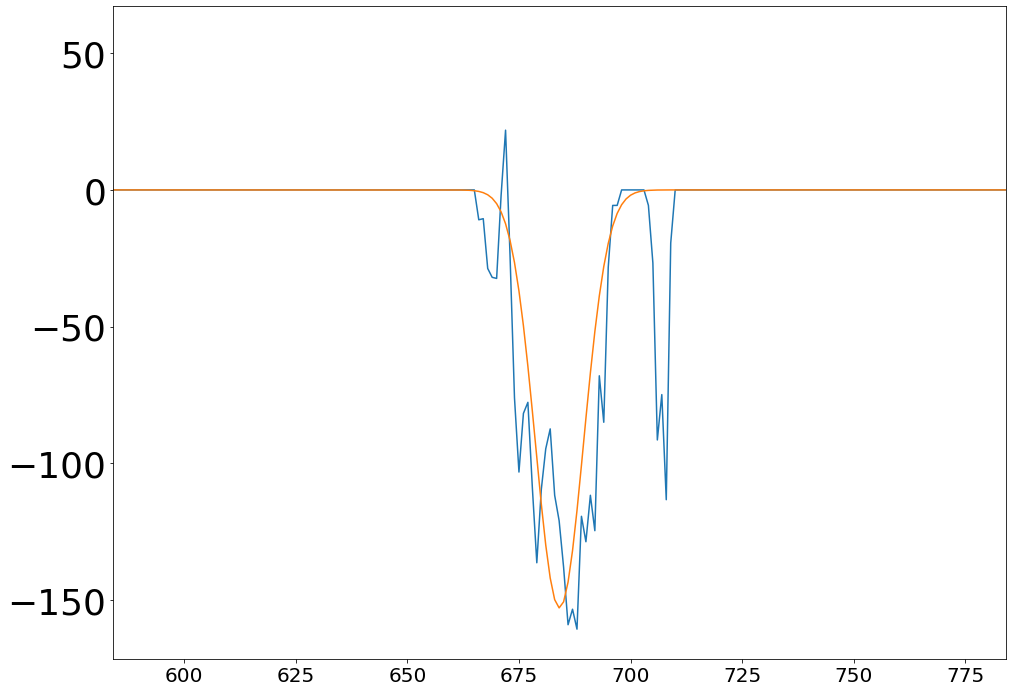

 45%|████▍     | 68/152 [00:09<00:11,  7.30it/s]

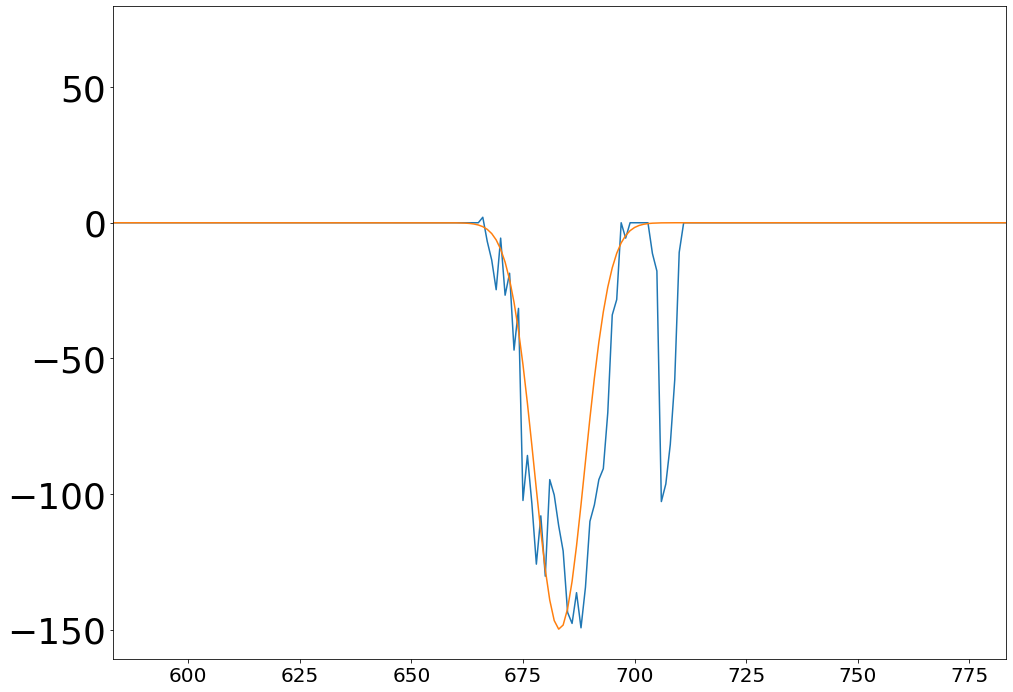

 45%|████▌     | 69/152 [00:09<00:11,  7.47it/s]

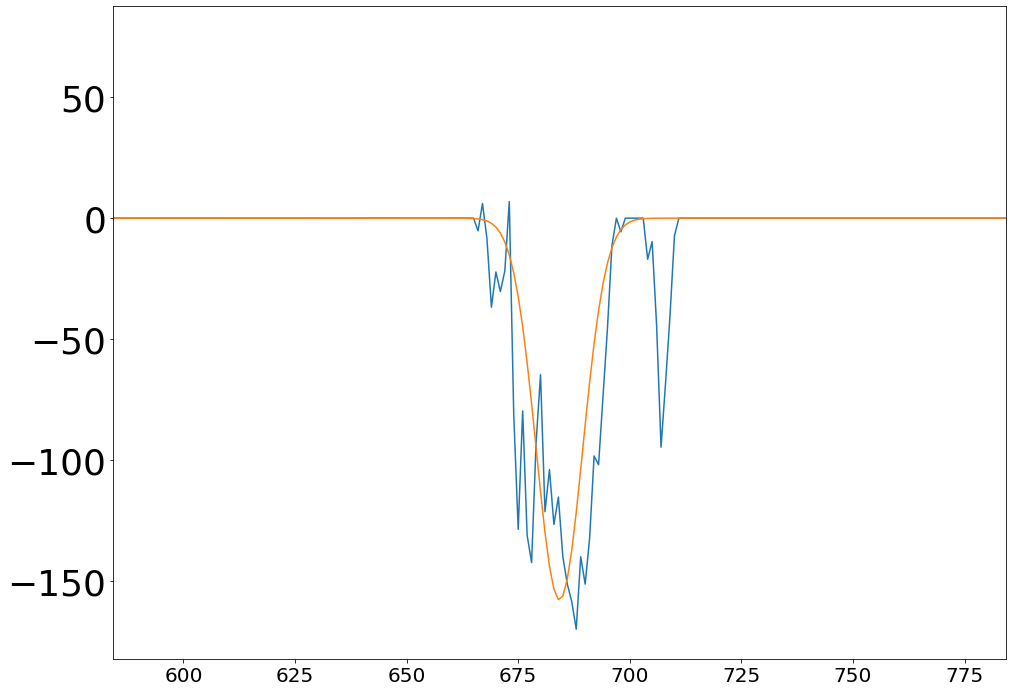

 46%|████▌     | 70/152 [00:09<00:10,  7.53it/s]

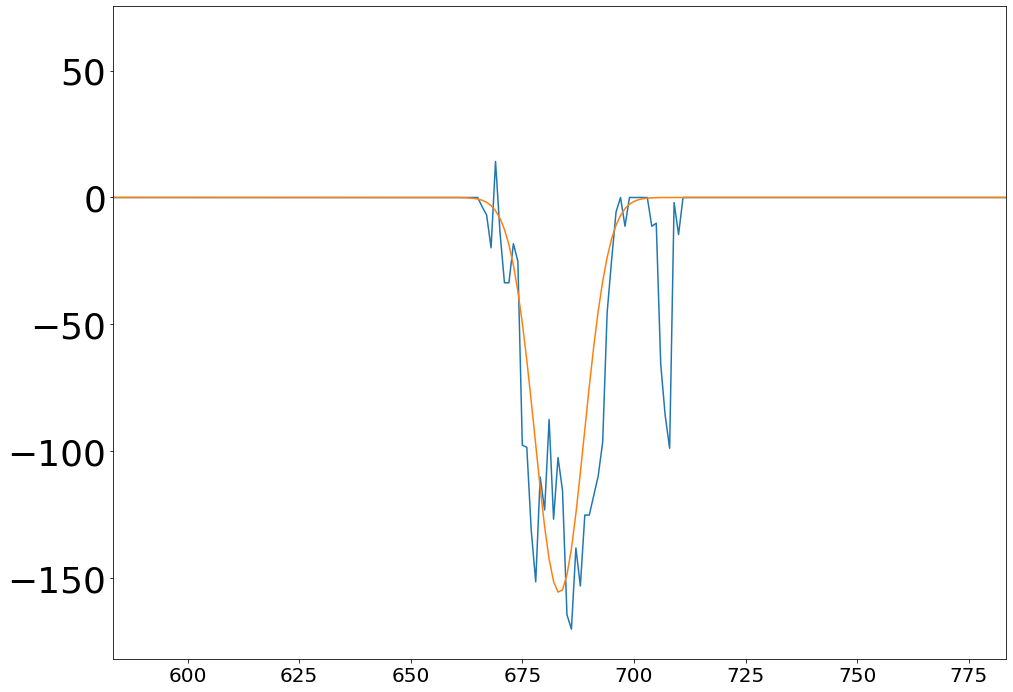

 47%|████▋     | 71/152 [00:09<00:10,  7.59it/s]

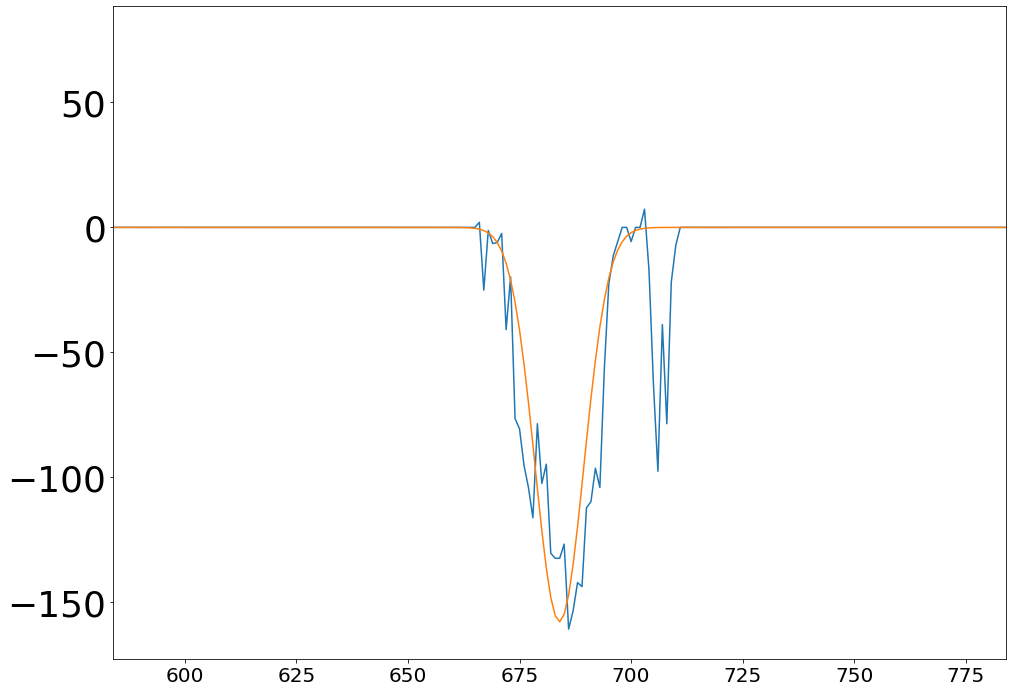

 47%|████▋     | 72/152 [00:09<00:10,  7.66it/s]

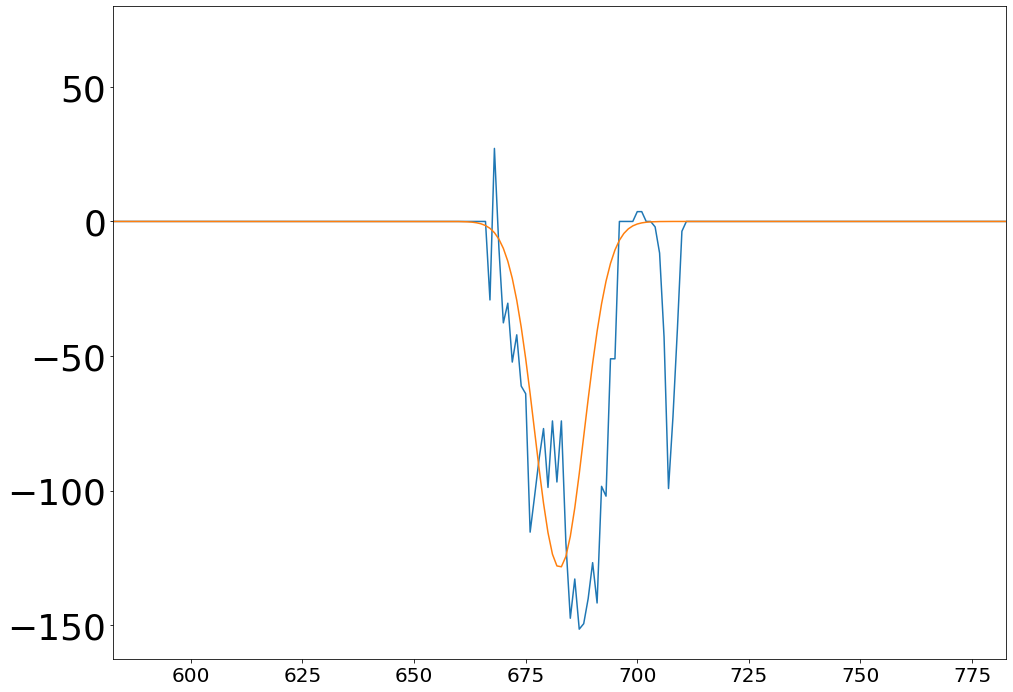

 48%|████▊     | 73/152 [00:10<00:10,  7.57it/s]

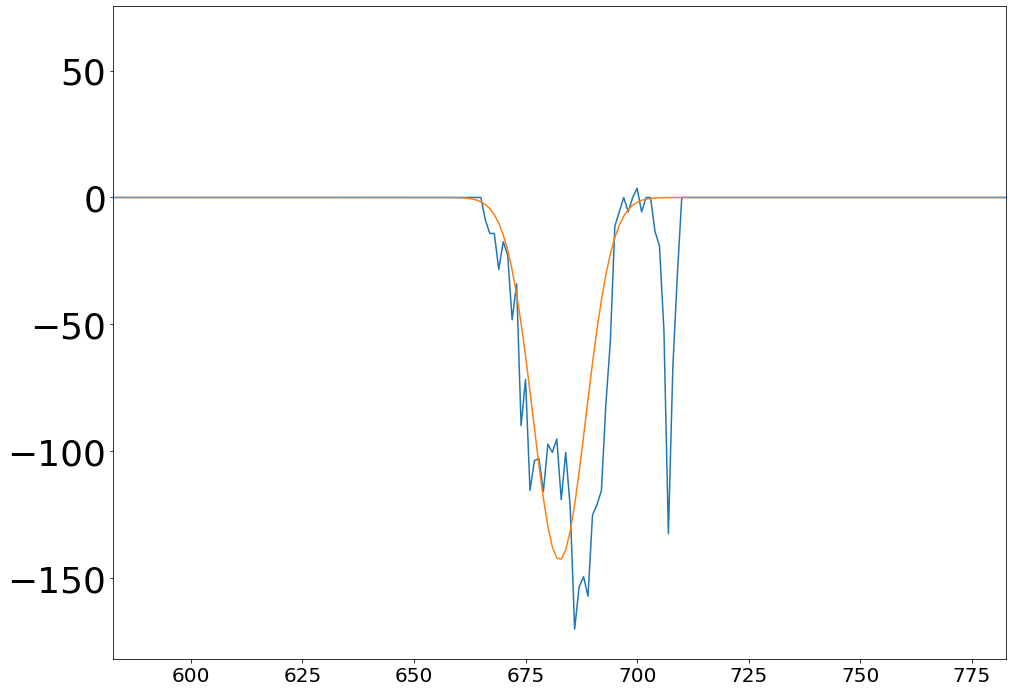

 49%|████▊     | 74/152 [00:10<00:10,  7.58it/s]

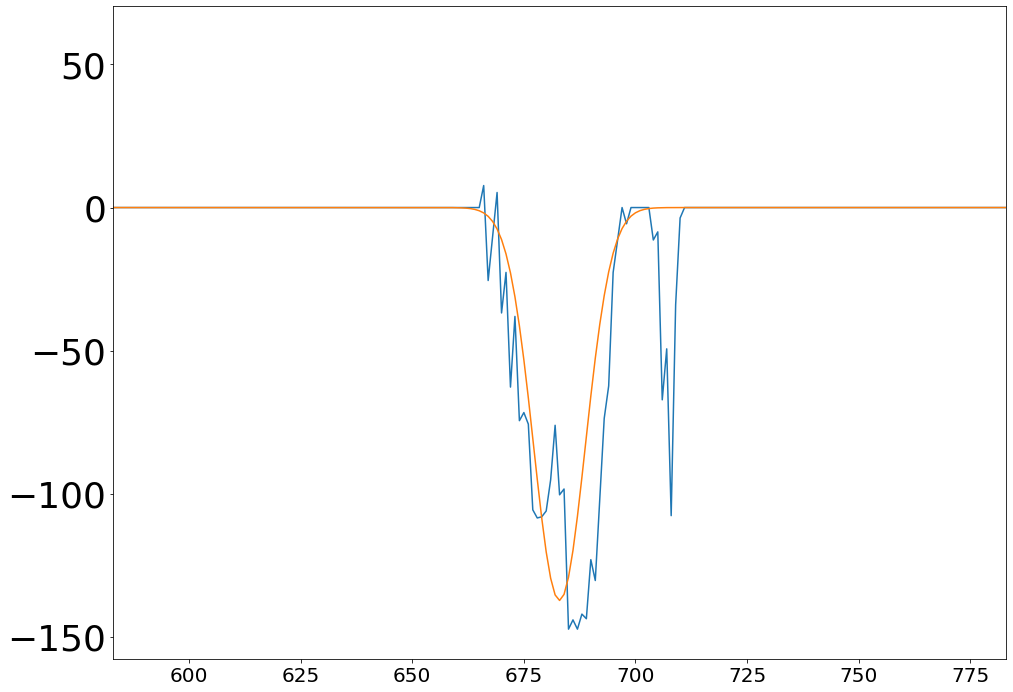

 49%|████▉     | 75/152 [00:10<00:10,  7.60it/s]

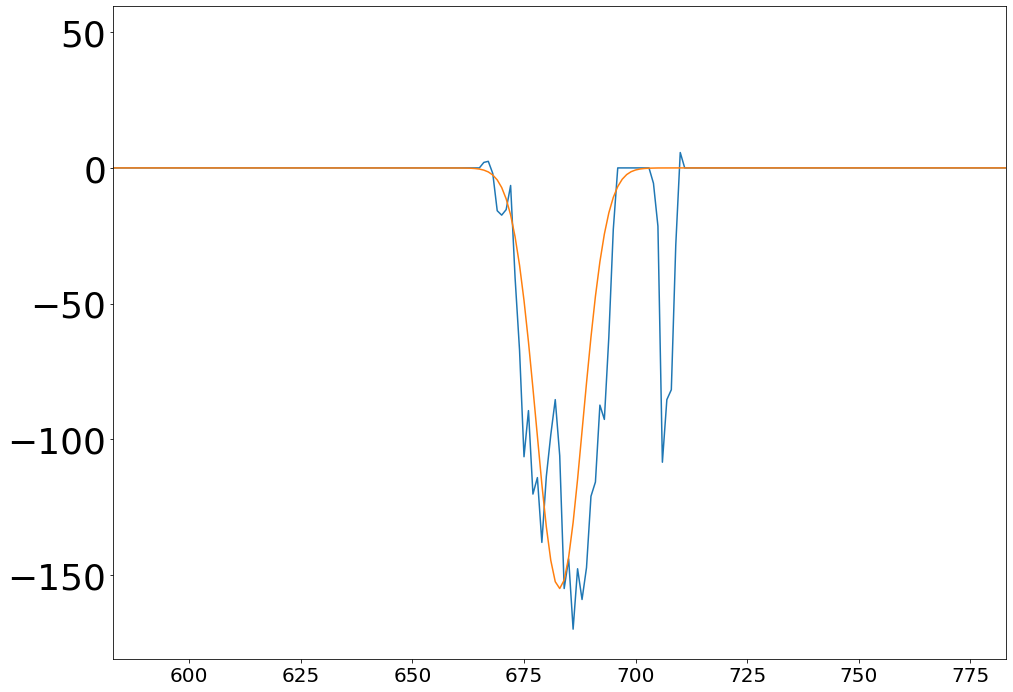

 50%|█████     | 76/152 [00:10<00:10,  7.56it/s]

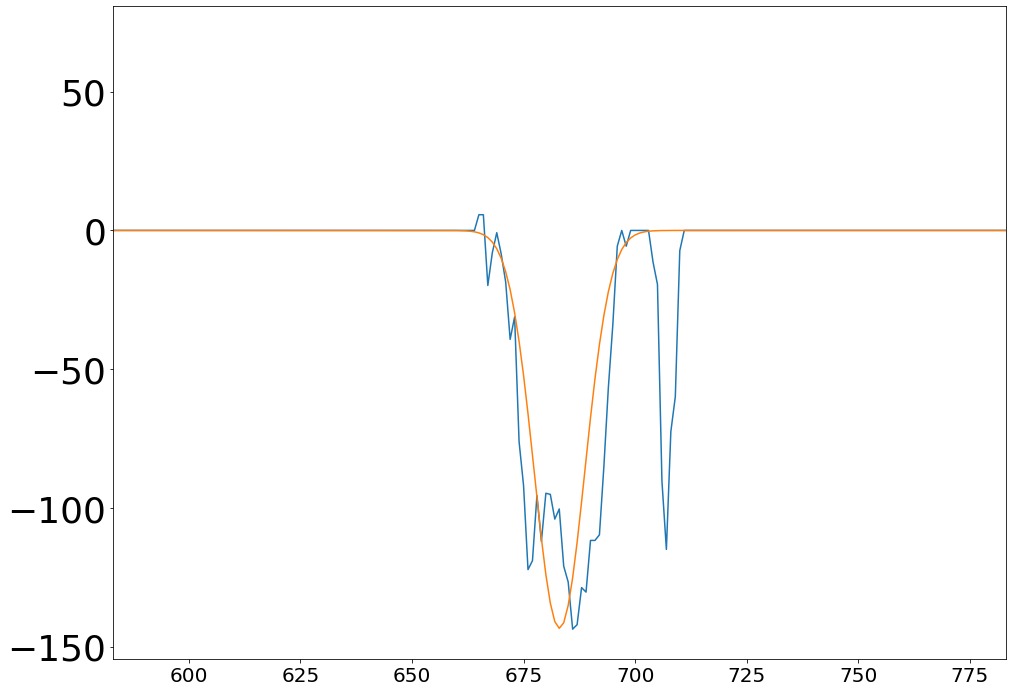

 51%|█████     | 77/152 [00:10<00:09,  7.54it/s]

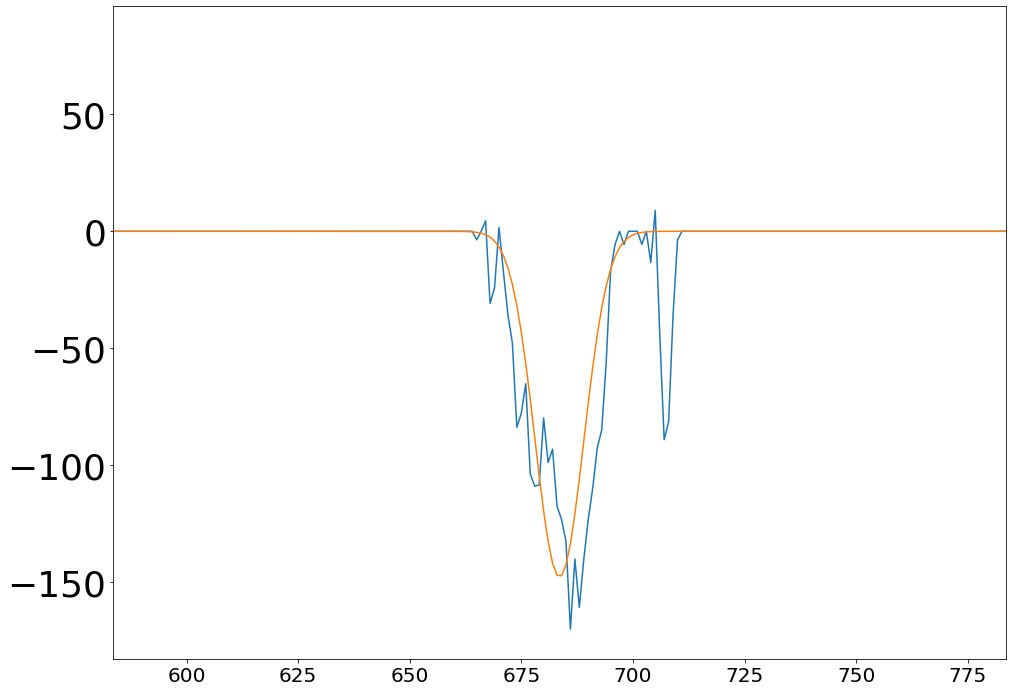

 51%|█████▏    | 78/152 [00:10<00:09,  7.62it/s]

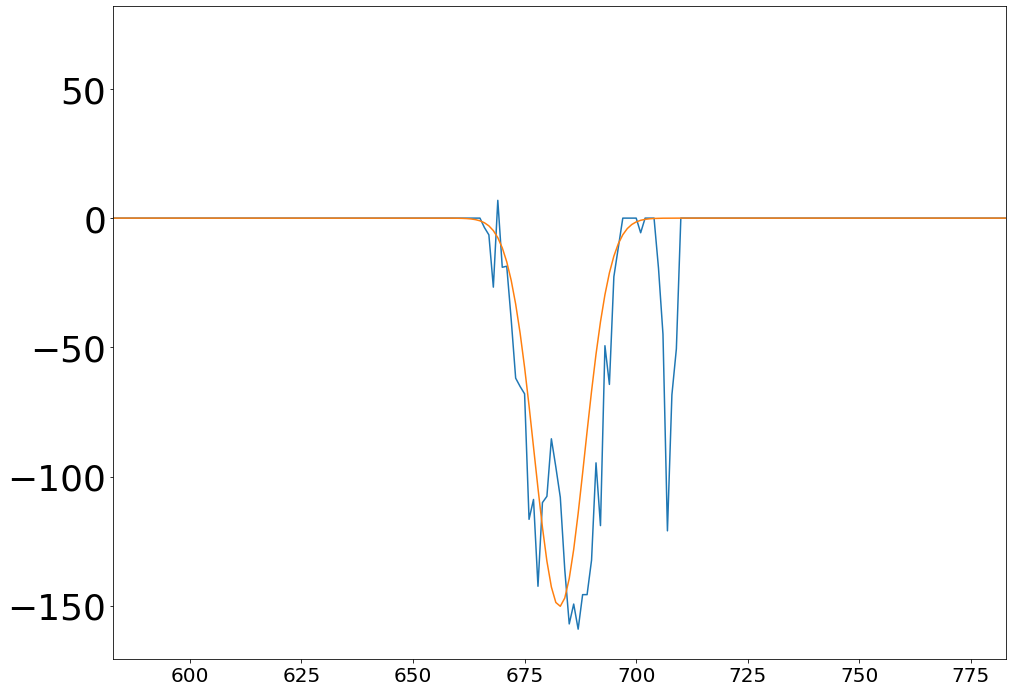

 52%|█████▏    | 79/152 [00:10<00:10,  6.87it/s]

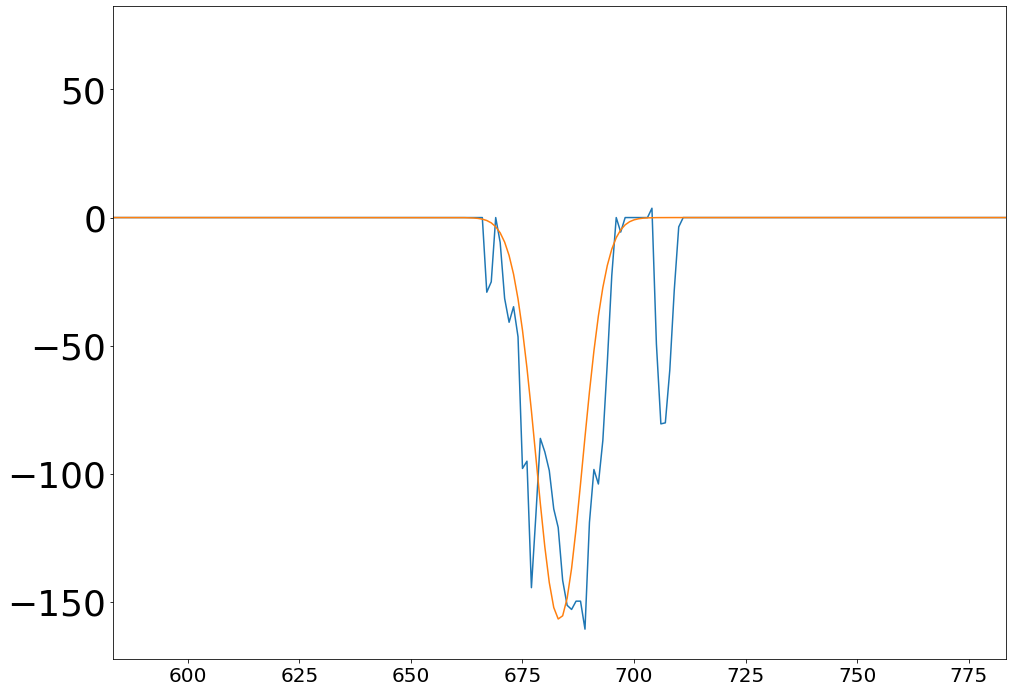

 53%|█████▎    | 80/152 [00:11<00:10,  7.09it/s]

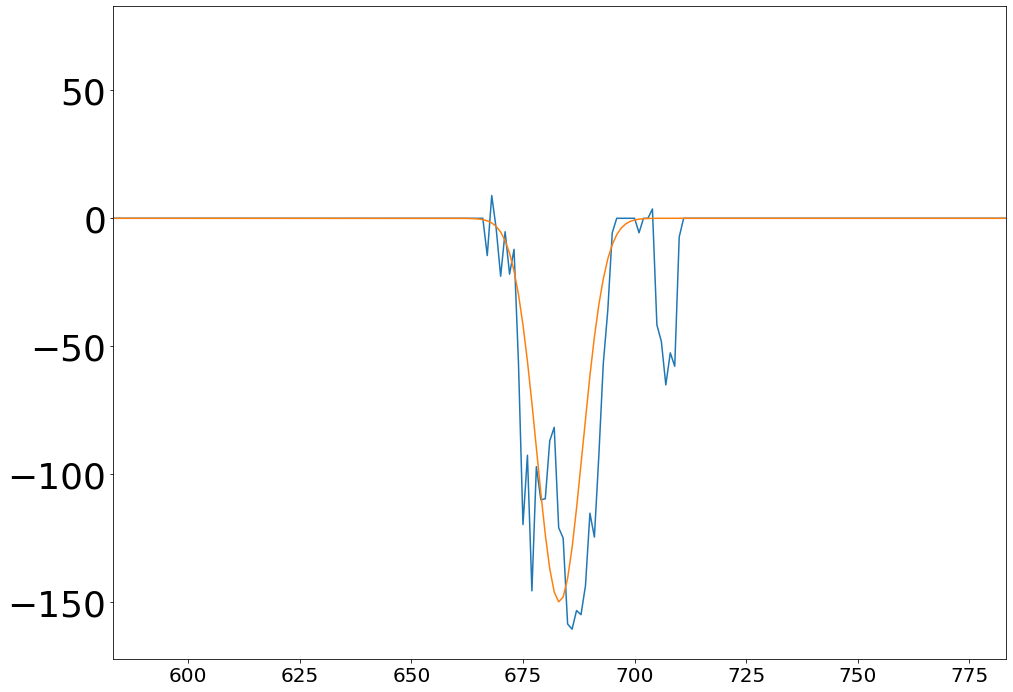

 53%|█████▎    | 81/152 [00:11<00:09,  7.22it/s]

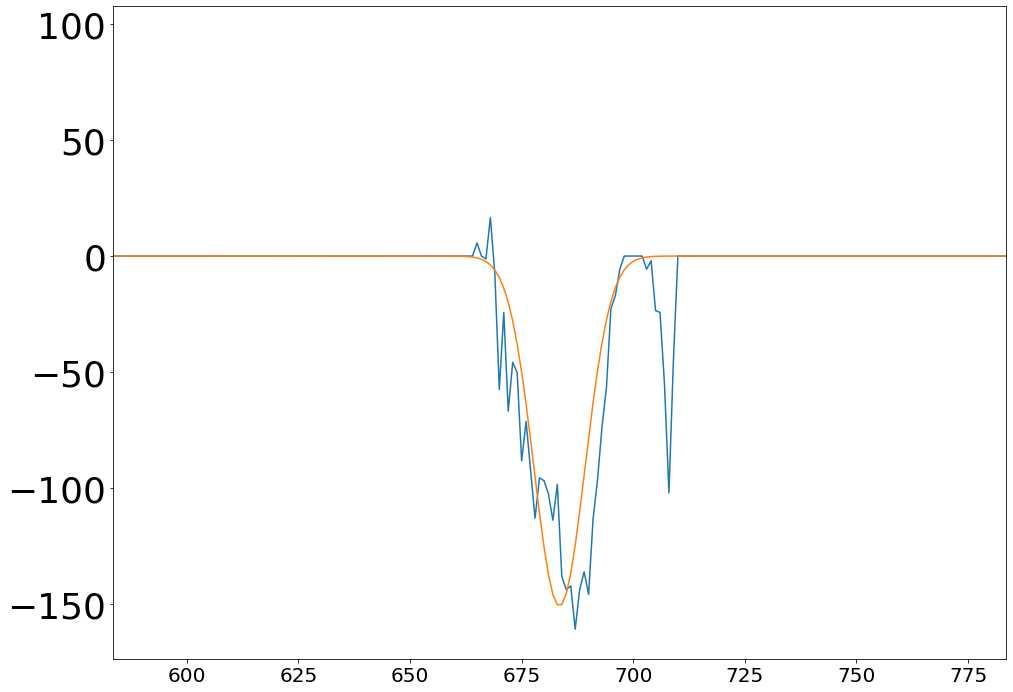

 54%|█████▍    | 82/152 [00:11<00:09,  7.34it/s]

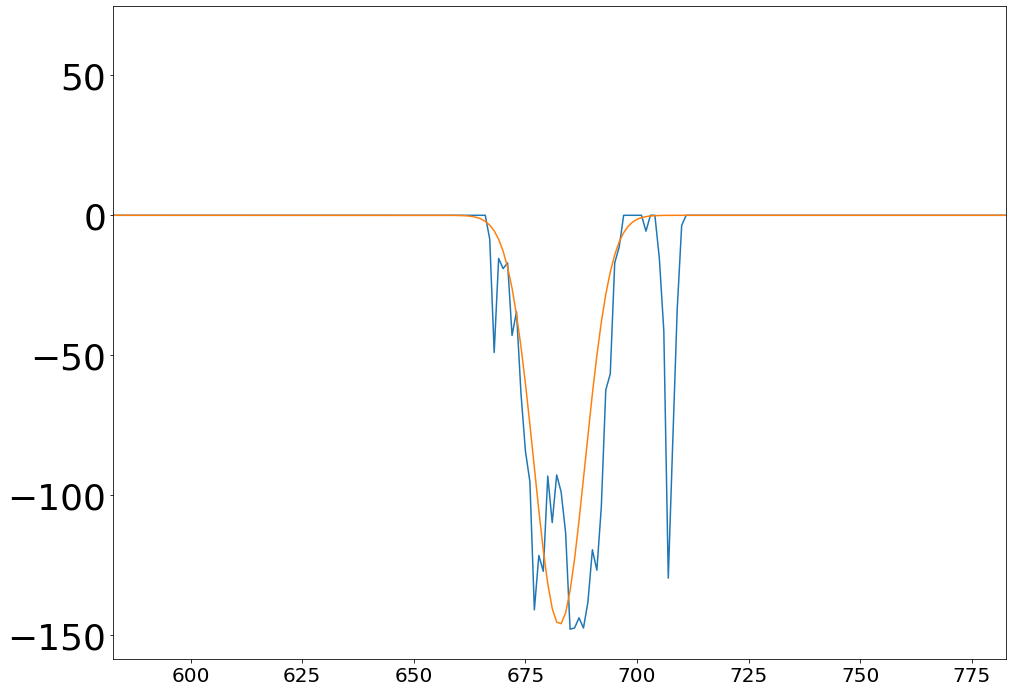

 55%|█████▍    | 83/152 [00:11<00:09,  7.36it/s]

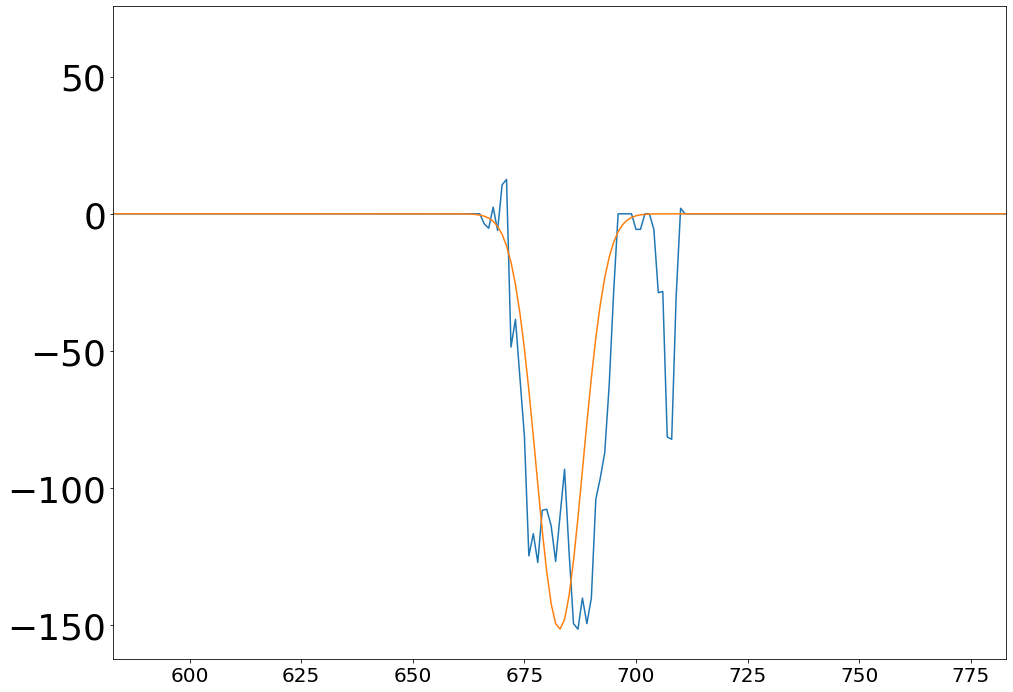

 55%|█████▌    | 84/152 [00:11<00:09,  7.37it/s]

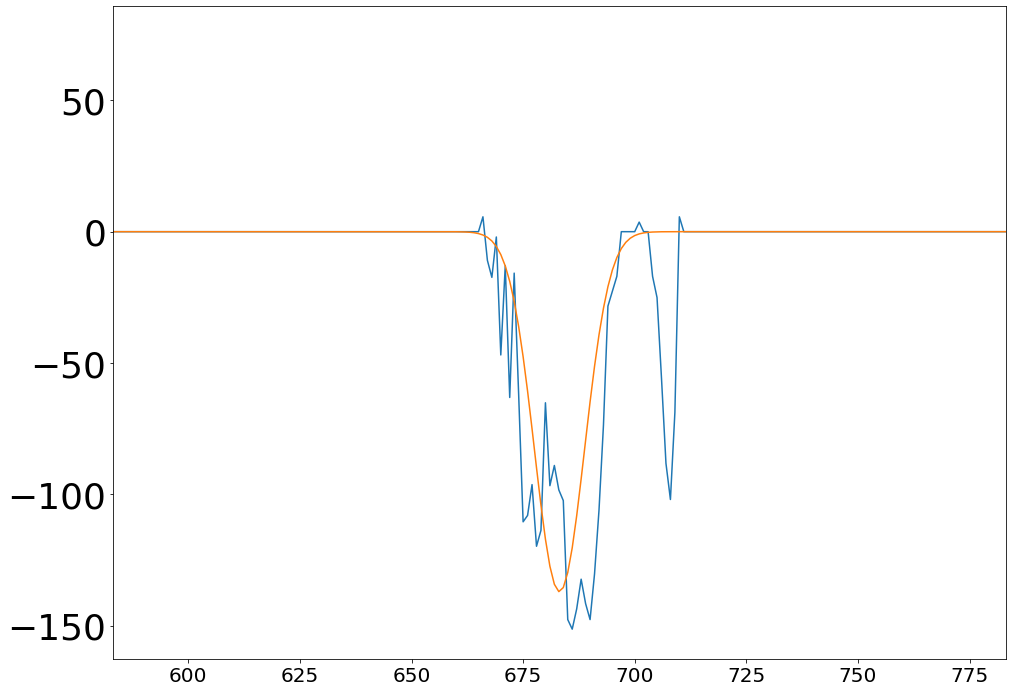

 56%|█████▌    | 85/152 [00:11<00:09,  7.43it/s]

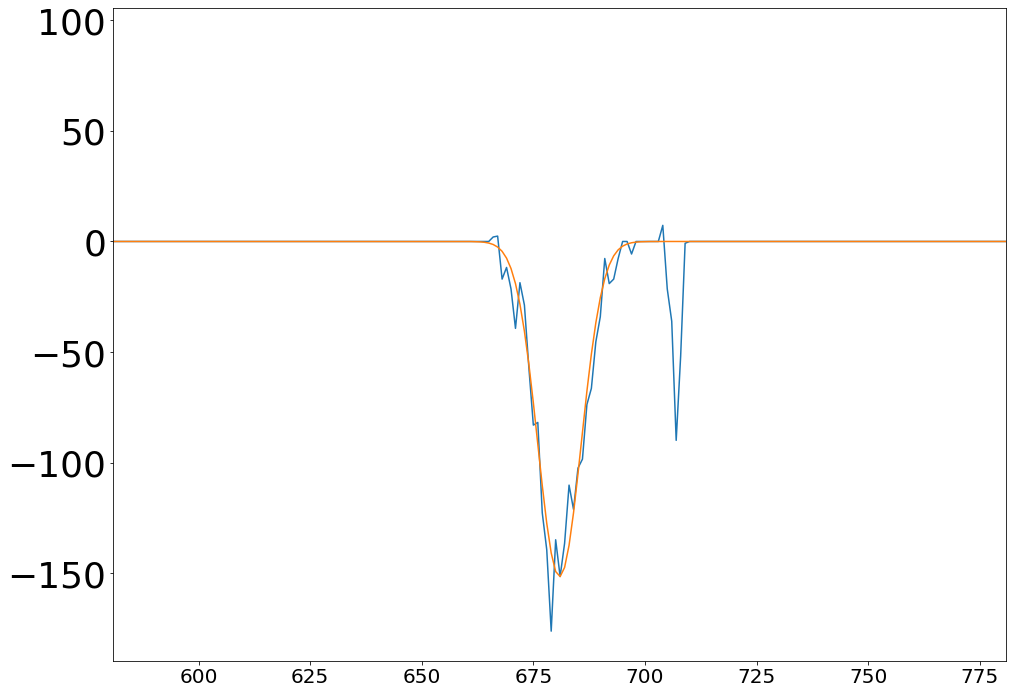

 57%|█████▋    | 86/152 [00:11<00:08,  7.40it/s]

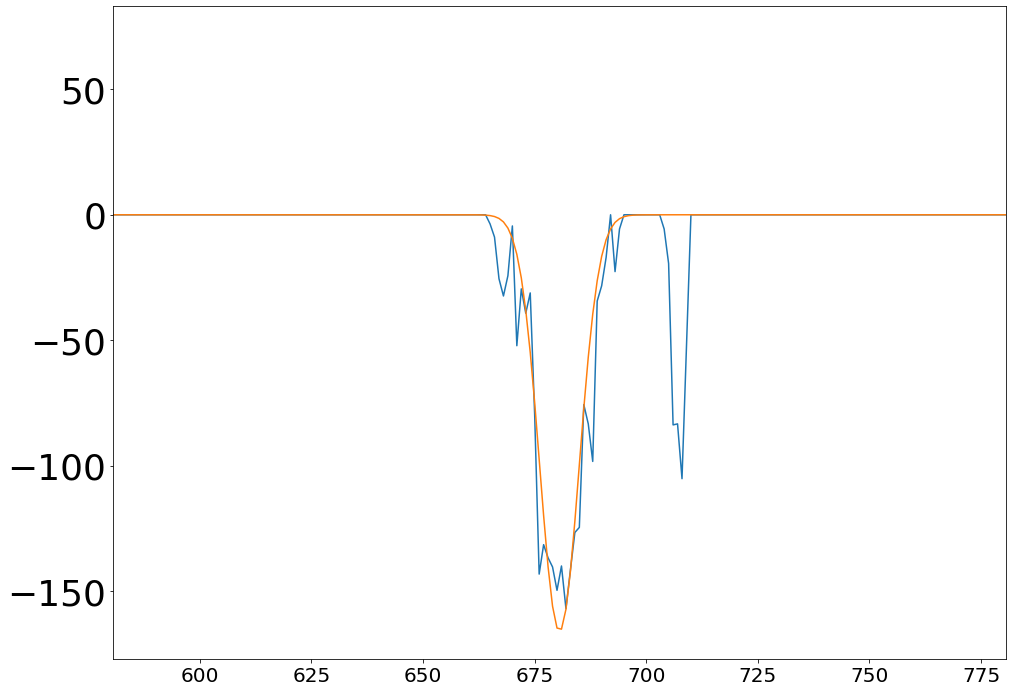

 57%|█████▋    | 87/152 [00:11<00:08,  7.35it/s]

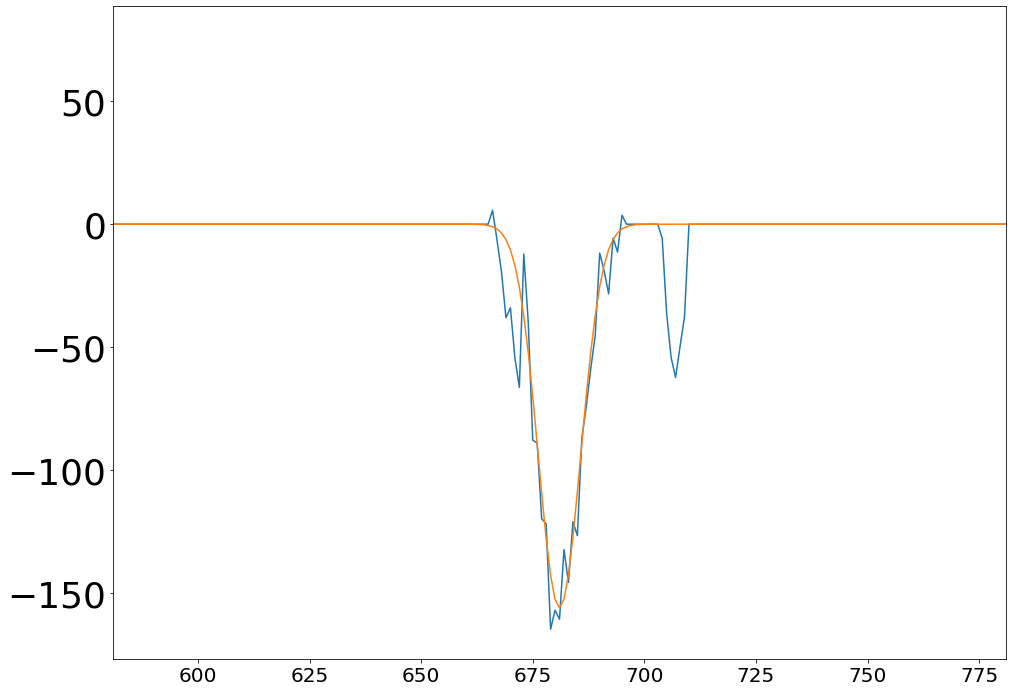

 58%|█████▊    | 88/152 [00:12<00:08,  7.47it/s]

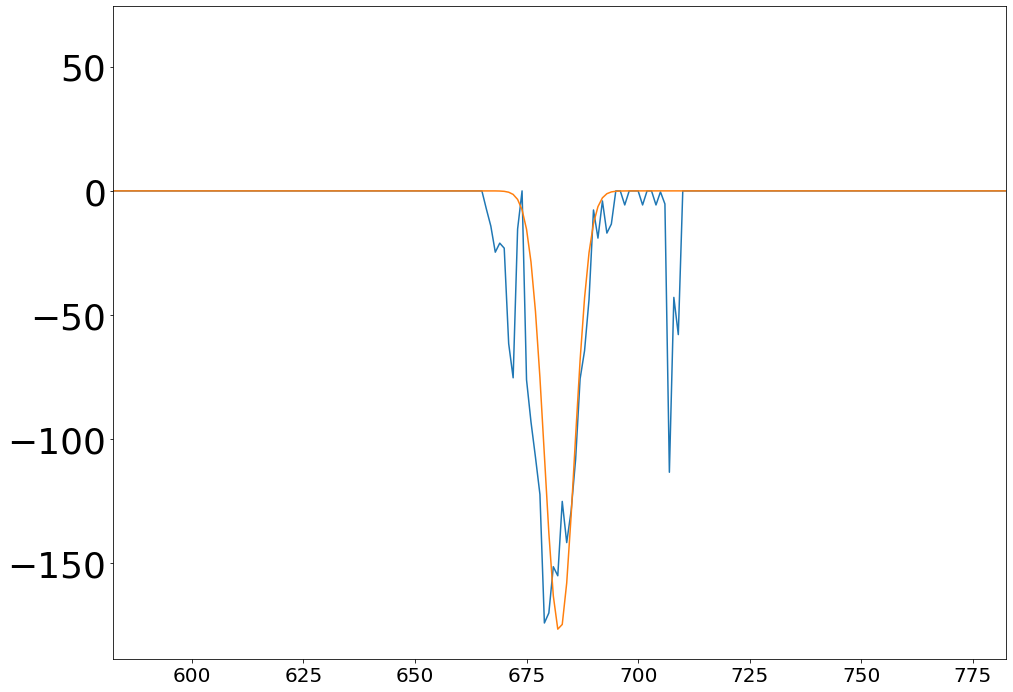

 59%|█████▊    | 89/152 [00:12<00:08,  7.53it/s]

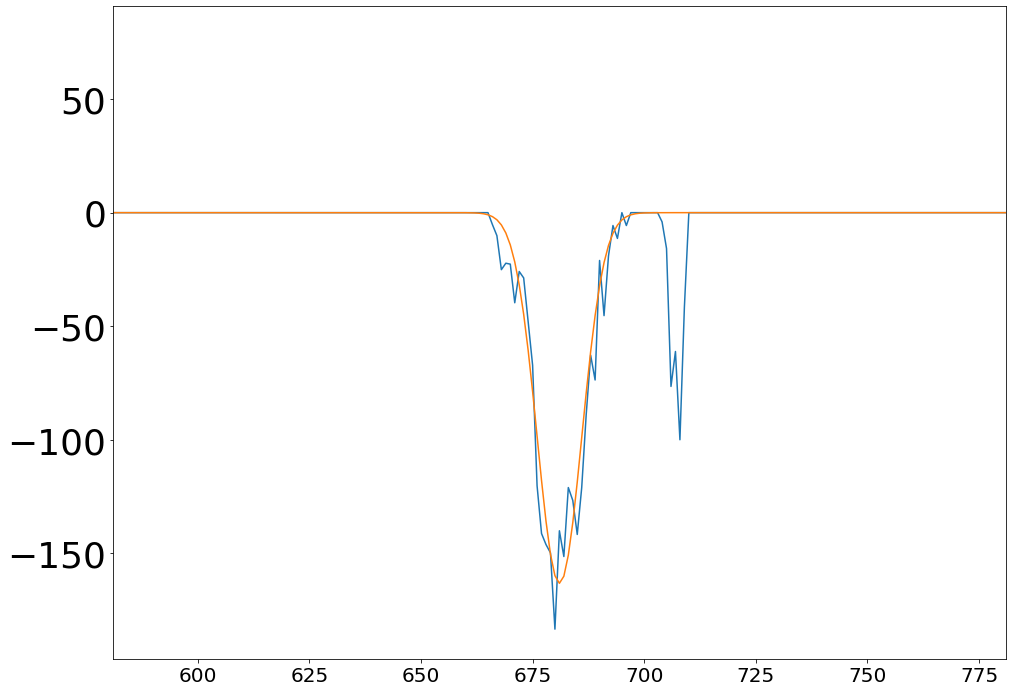

 59%|█████▉    | 90/152 [00:12<00:08,  7.59it/s]

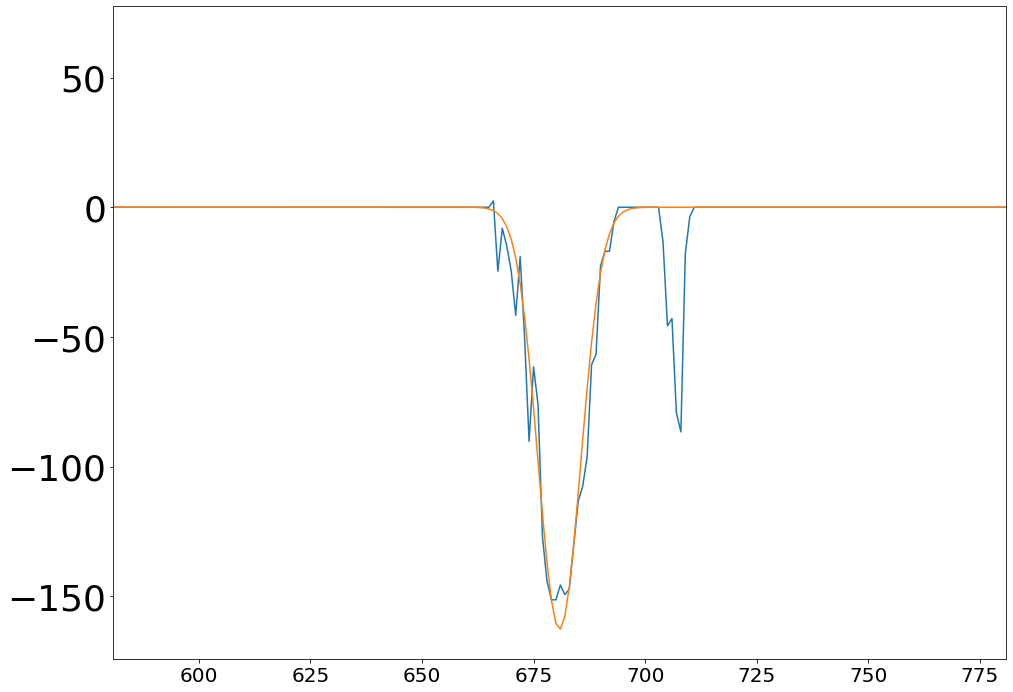

 60%|█████▉    | 91/152 [00:12<00:08,  7.48it/s]

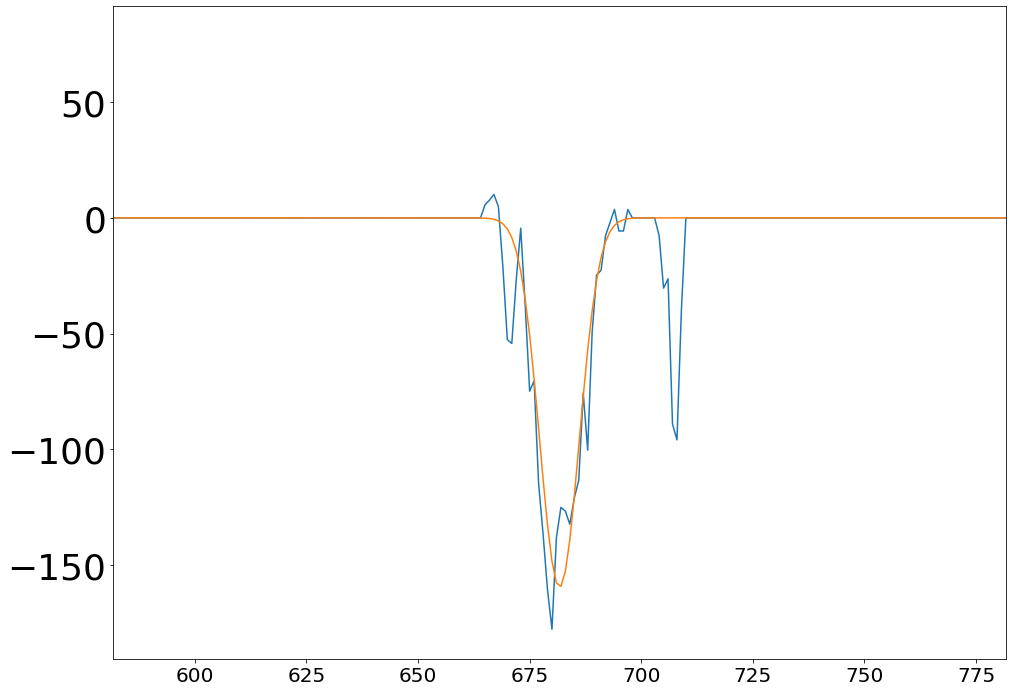

 61%|██████    | 92/152 [00:12<00:08,  7.49it/s]

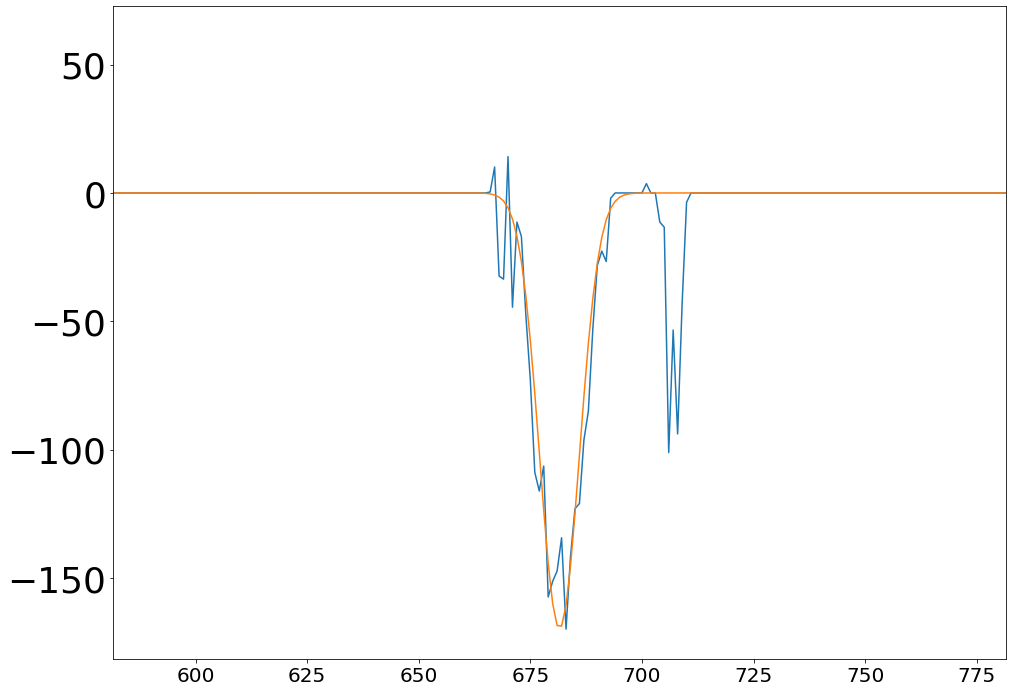

 61%|██████    | 93/152 [00:12<00:08,  6.63it/s]

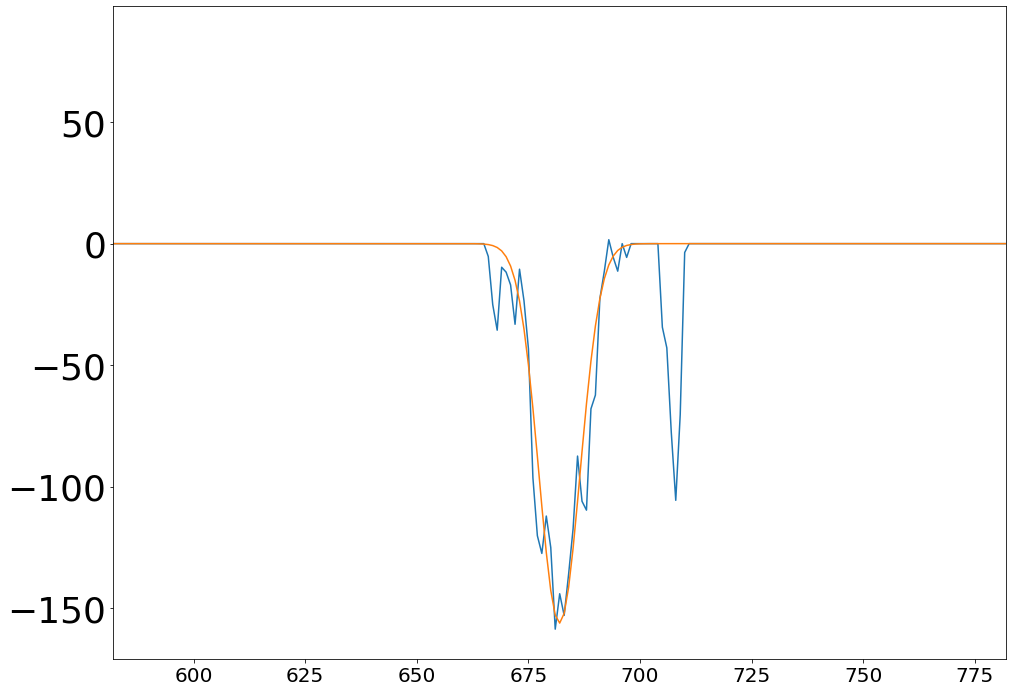

 62%|██████▏   | 94/152 [00:12<00:08,  6.91it/s]

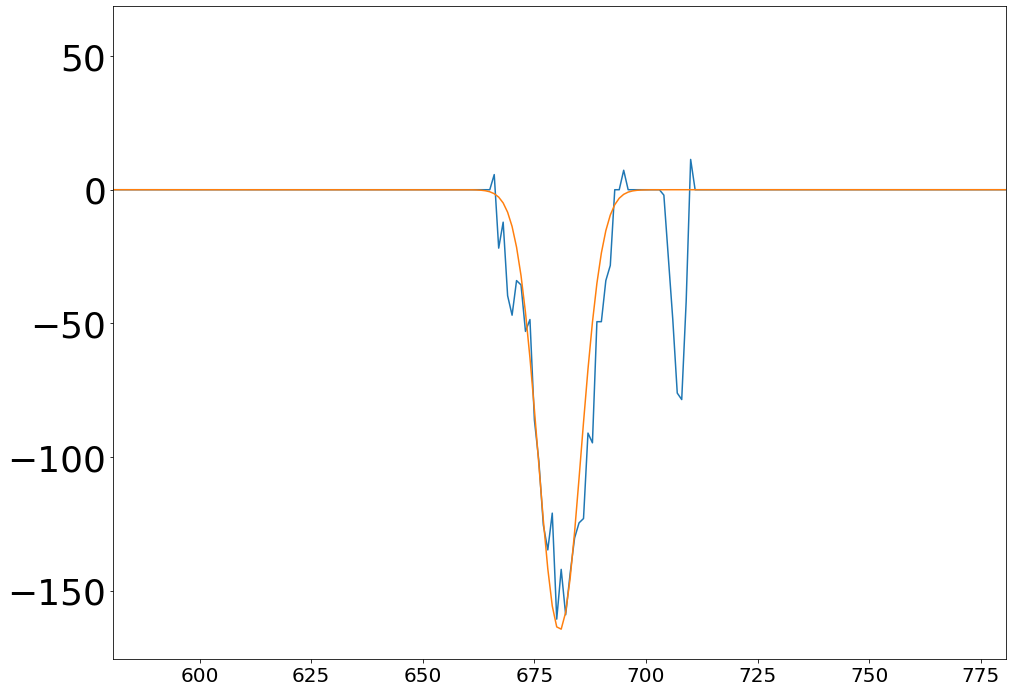

 62%|██████▎   | 95/152 [00:13<00:08,  7.08it/s]

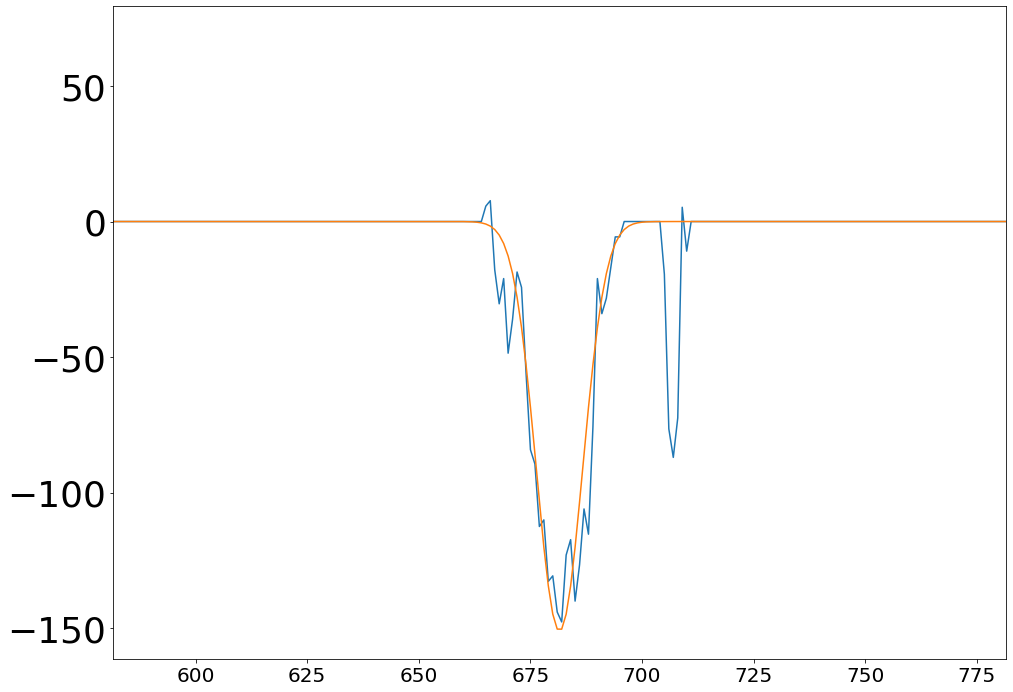

 63%|██████▎   | 96/152 [00:13<00:07,  7.24it/s]

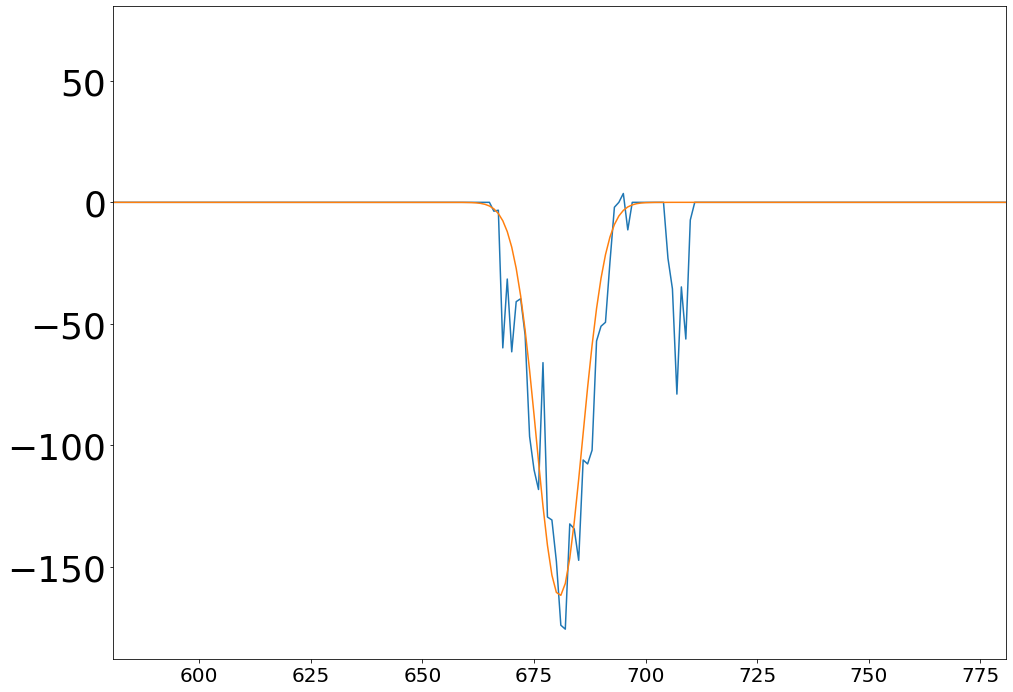

 64%|██████▍   | 97/152 [00:13<00:07,  7.32it/s]

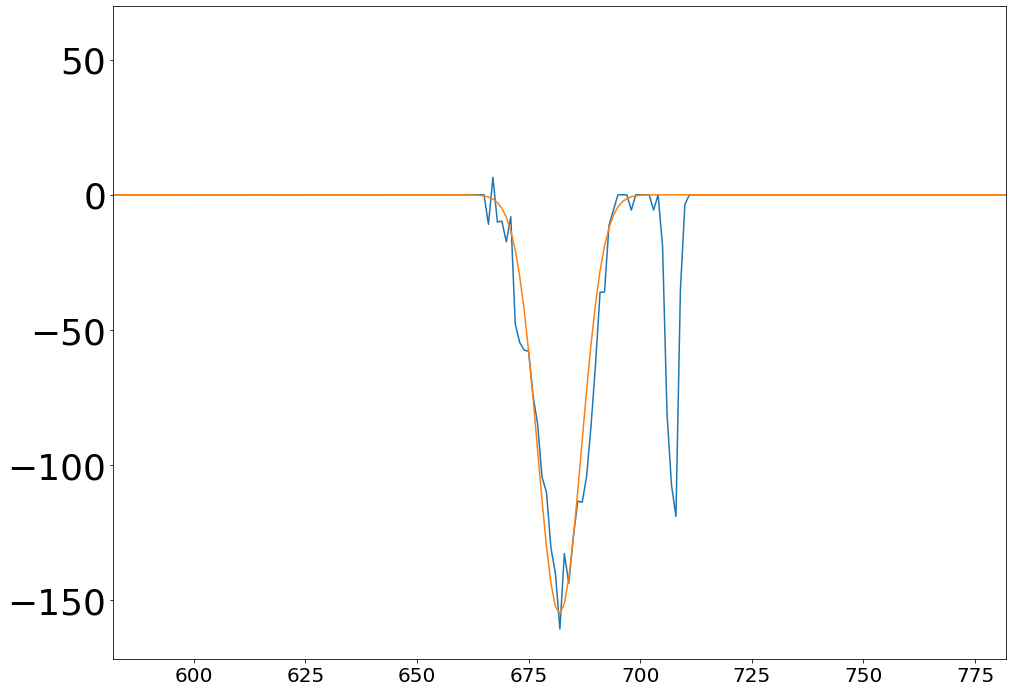

 64%|██████▍   | 98/152 [00:13<00:07,  7.42it/s]

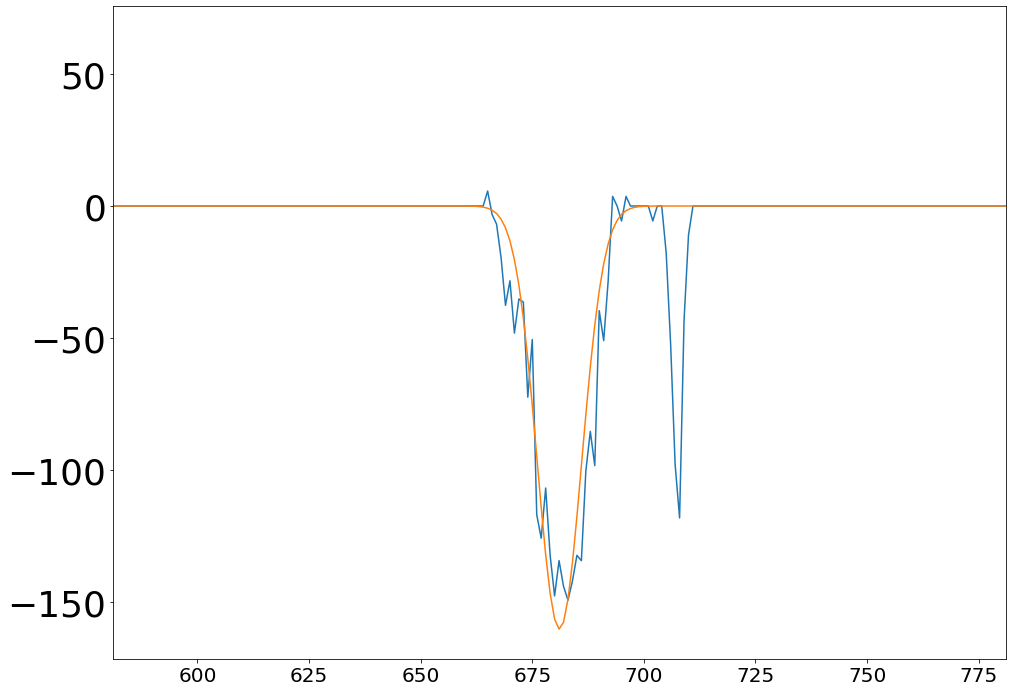

 65%|██████▌   | 99/152 [00:13<00:07,  7.46it/s]

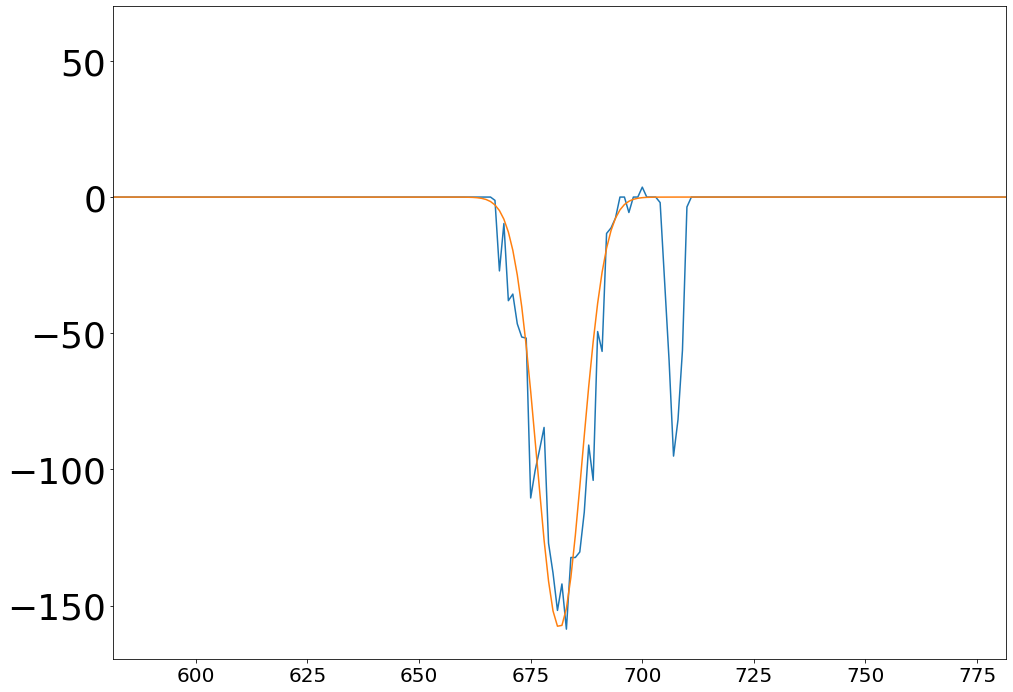

 66%|██████▌   | 100/152 [00:13<00:06,  7.47it/s]

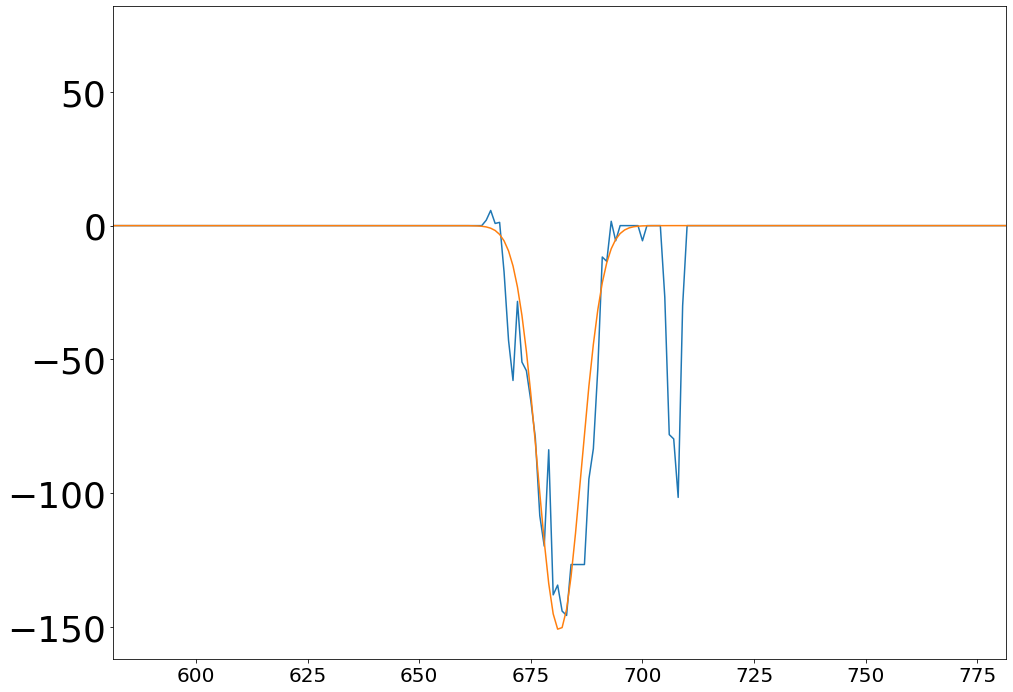

 66%|██████▋   | 101/152 [00:13<00:06,  7.44it/s]

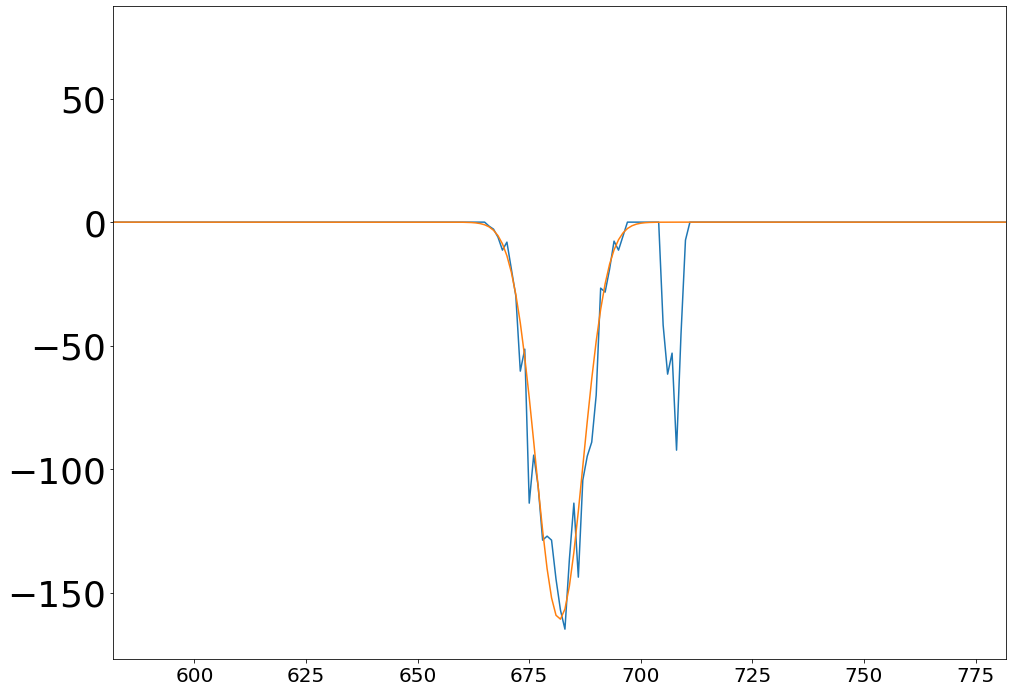

 67%|██████▋   | 102/152 [00:14<00:06,  7.46it/s]

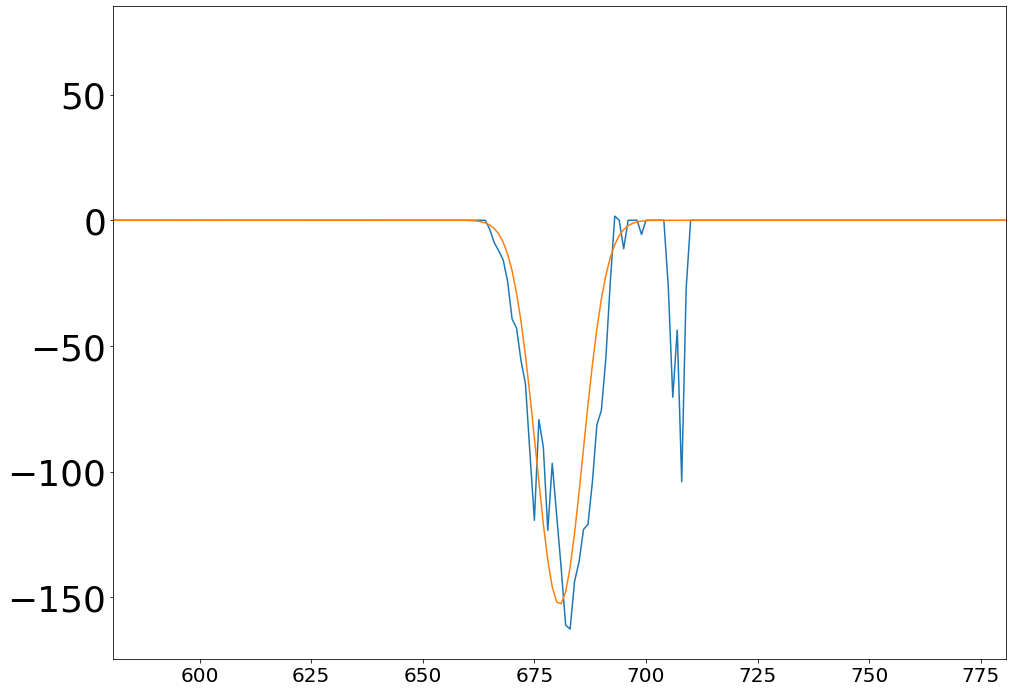

 68%|██████▊   | 103/152 [00:14<00:06,  7.40it/s]

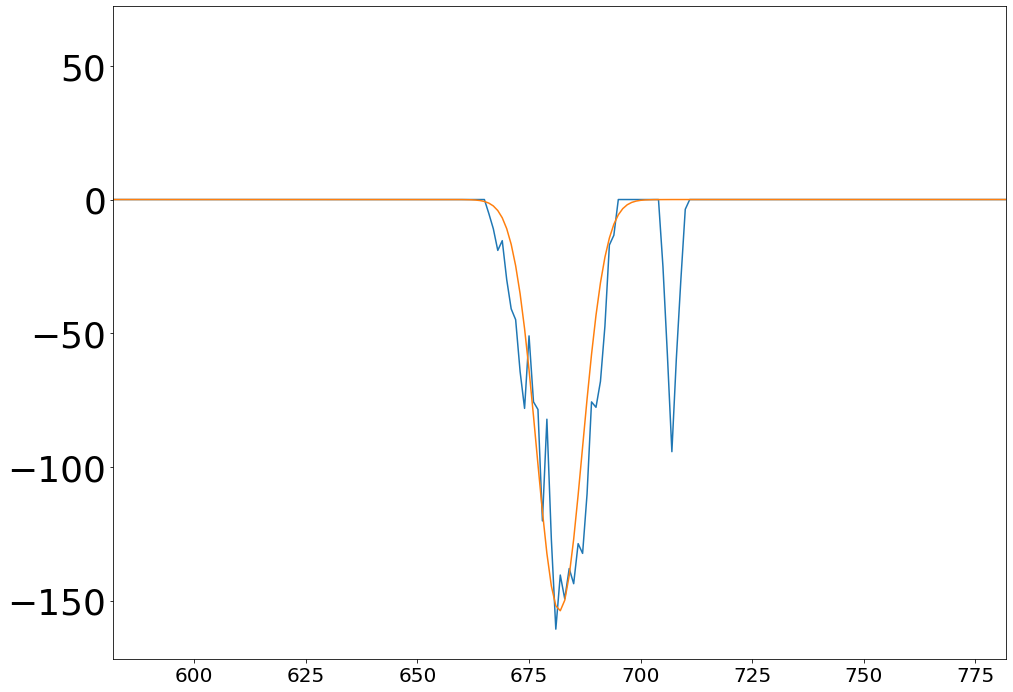

 68%|██████▊   | 104/152 [00:14<00:06,  7.46it/s]

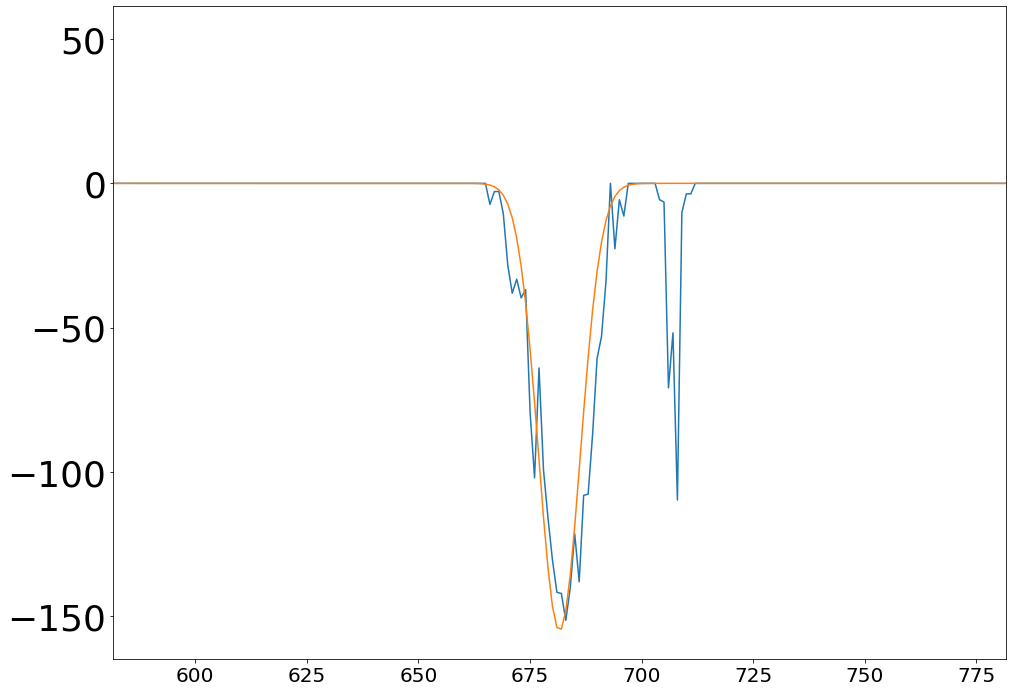

 69%|██████▉   | 105/152 [00:14<00:06,  7.47it/s]

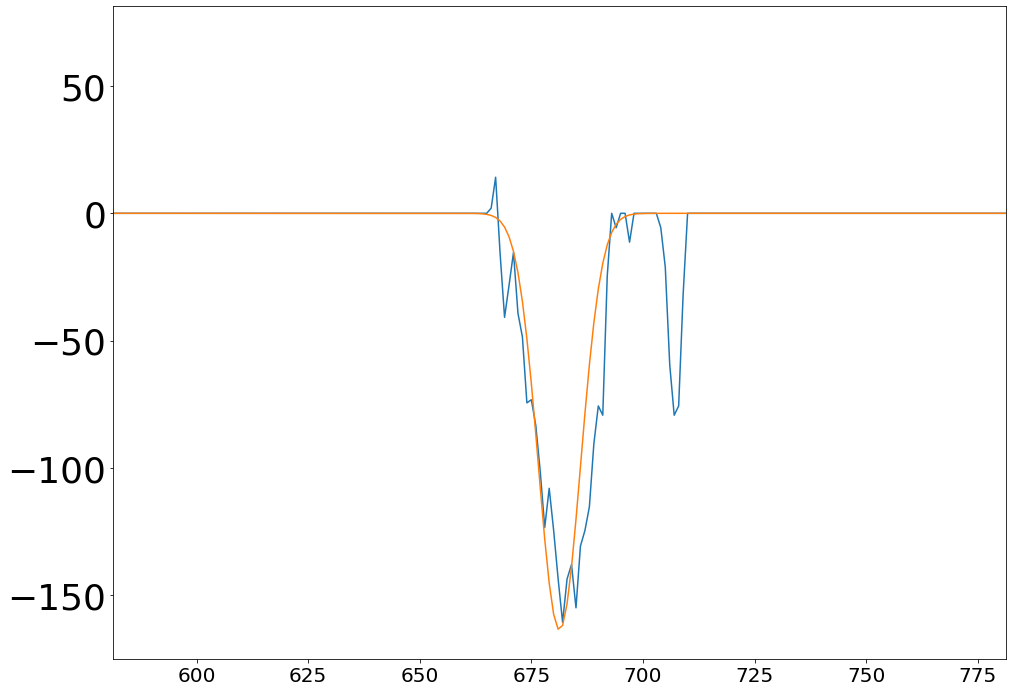

 70%|██████▉   | 106/152 [00:14<00:06,  7.43it/s]

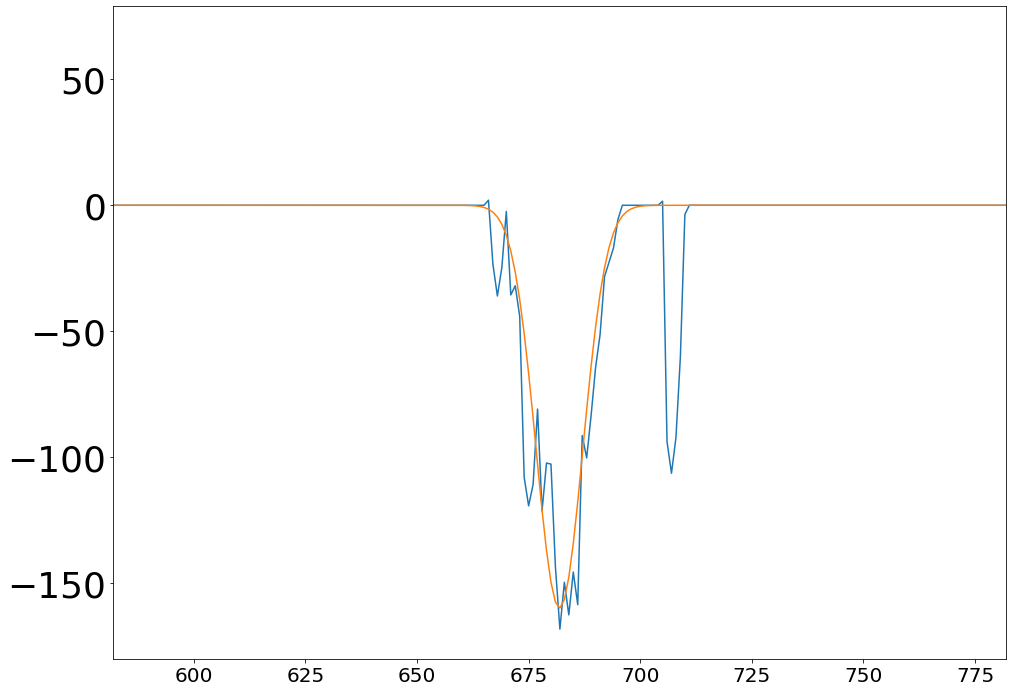

 70%|███████   | 107/152 [00:14<00:06,  6.62it/s]

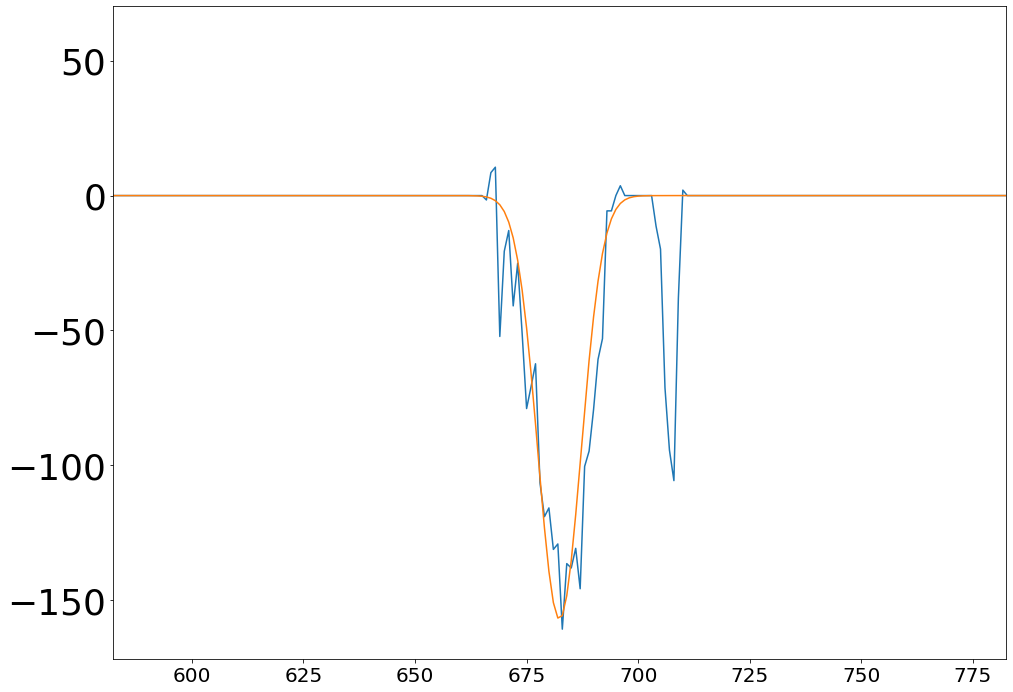

 71%|███████   | 108/152 [00:14<00:06,  6.83it/s]

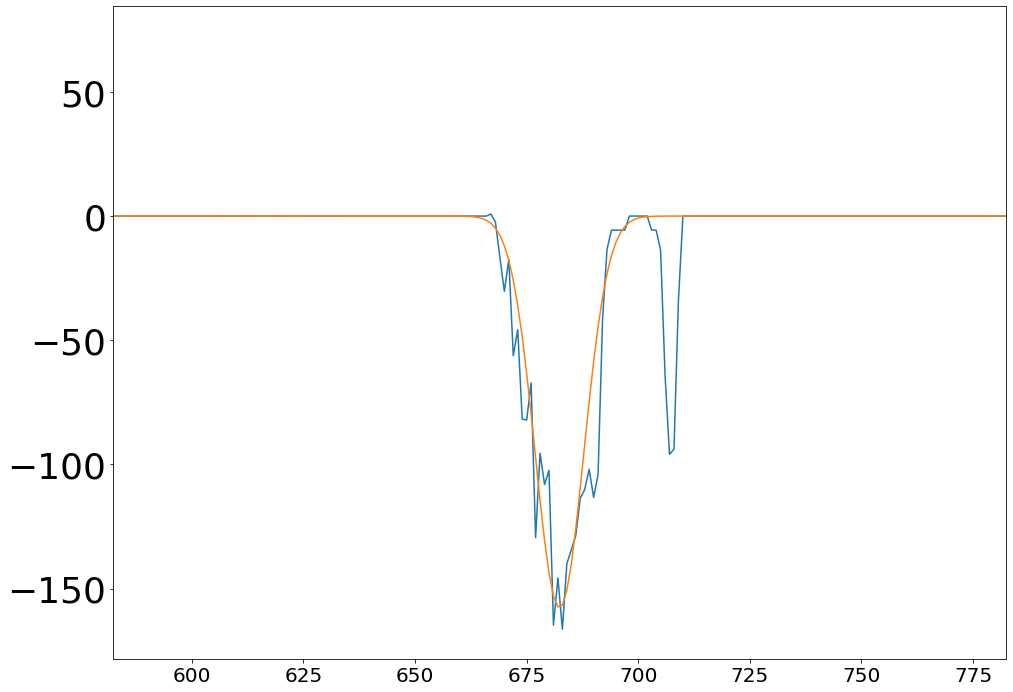

 72%|███████▏  | 109/152 [00:15<00:06,  7.11it/s]

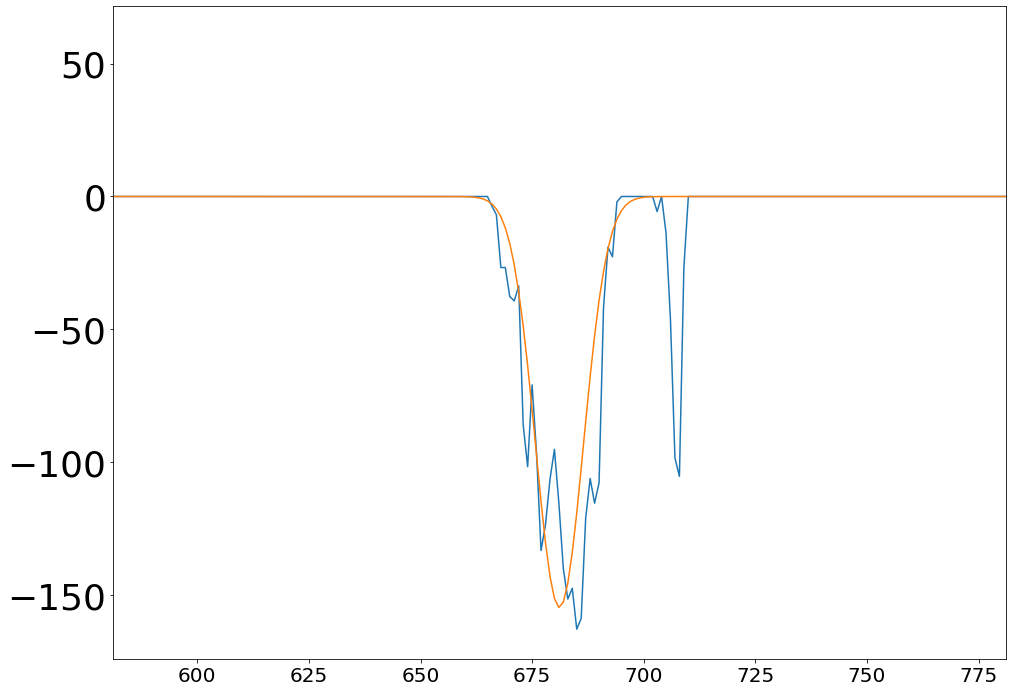

 72%|███████▏  | 110/152 [00:15<00:05,  7.23it/s]

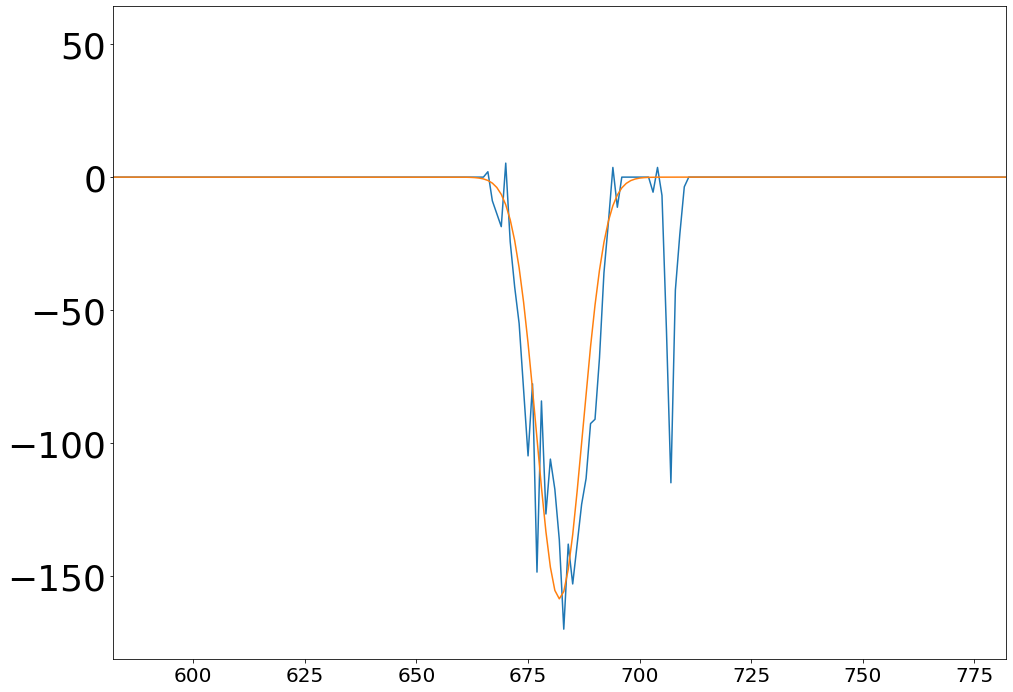

 73%|███████▎  | 111/152 [00:15<00:05,  7.37it/s]

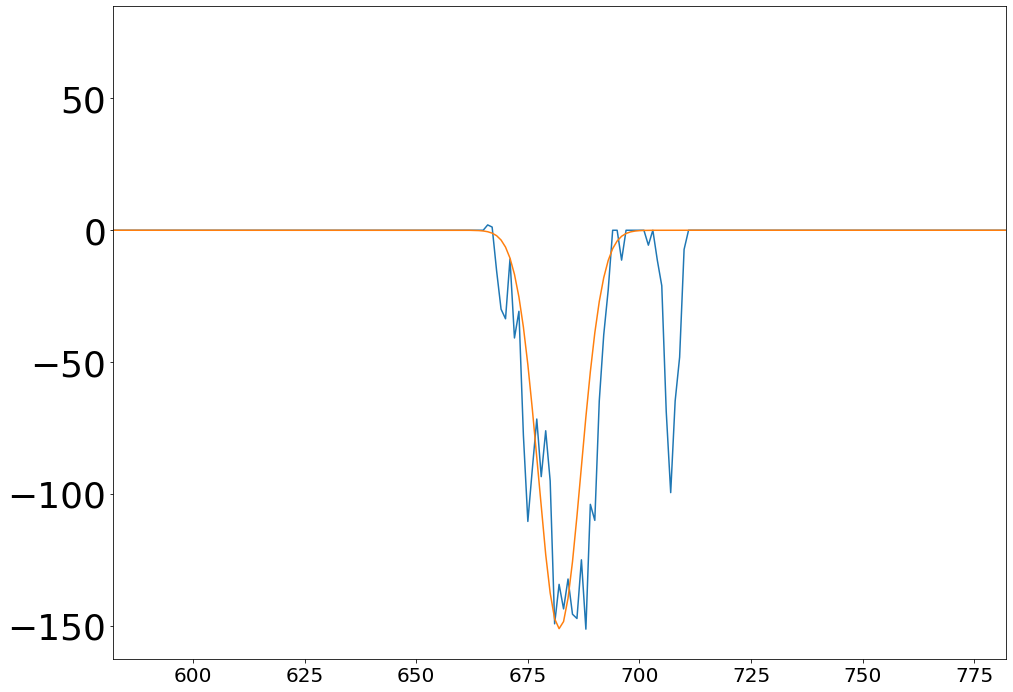

 74%|███████▎  | 112/152 [00:15<00:05,  7.39it/s]

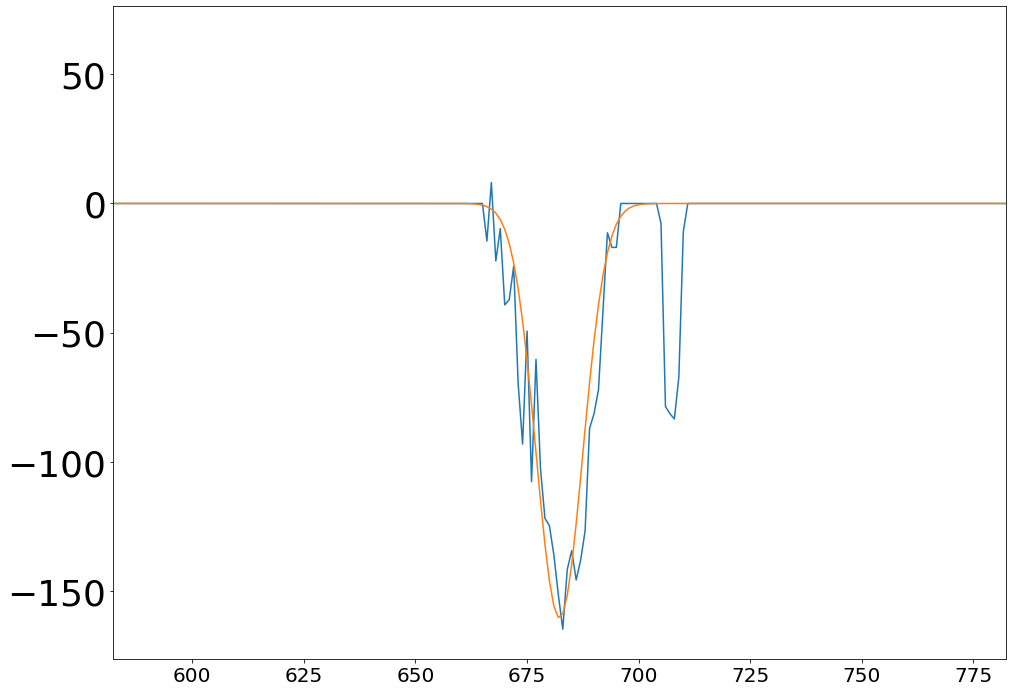

 74%|███████▍  | 113/152 [00:15<00:05,  7.47it/s]

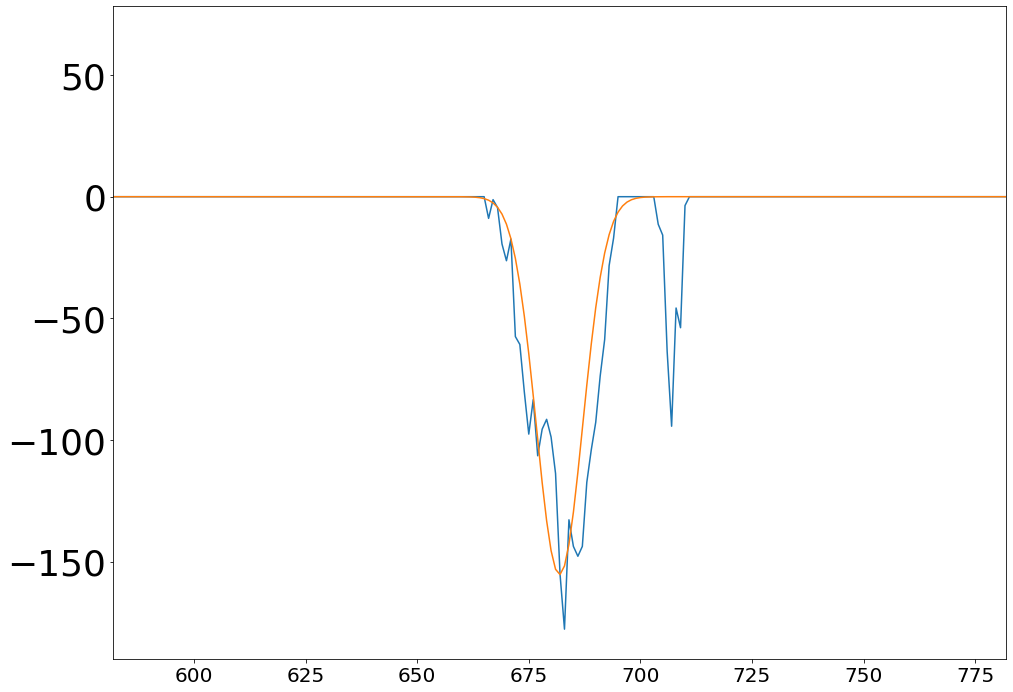

 75%|███████▌  | 114/152 [00:15<00:05,  7.56it/s]

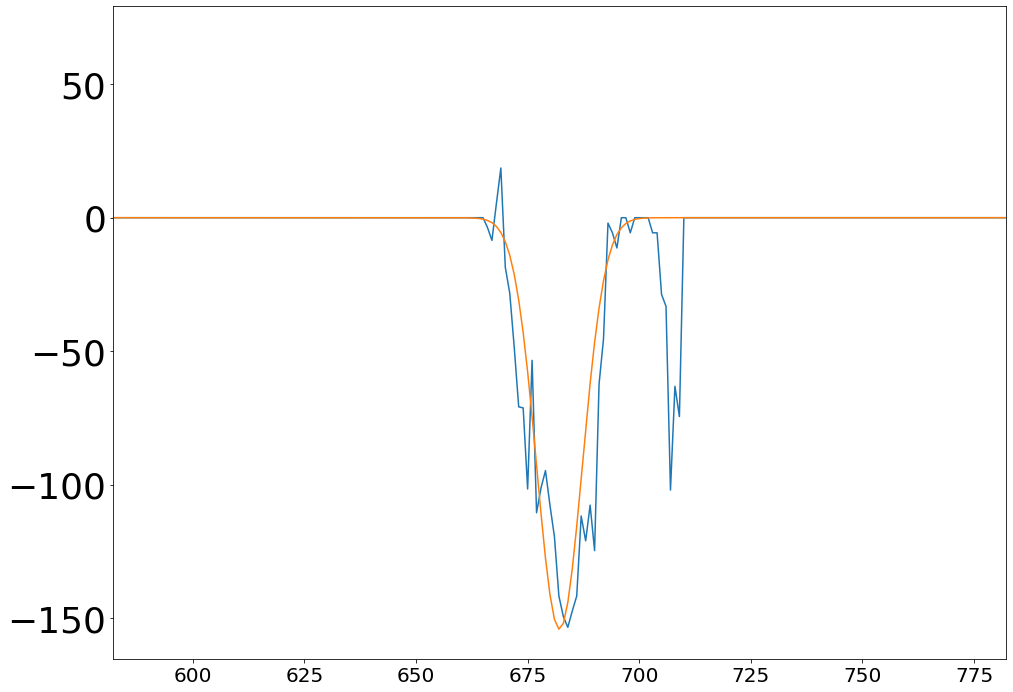

 76%|███████▌  | 115/152 [00:15<00:04,  7.57it/s]

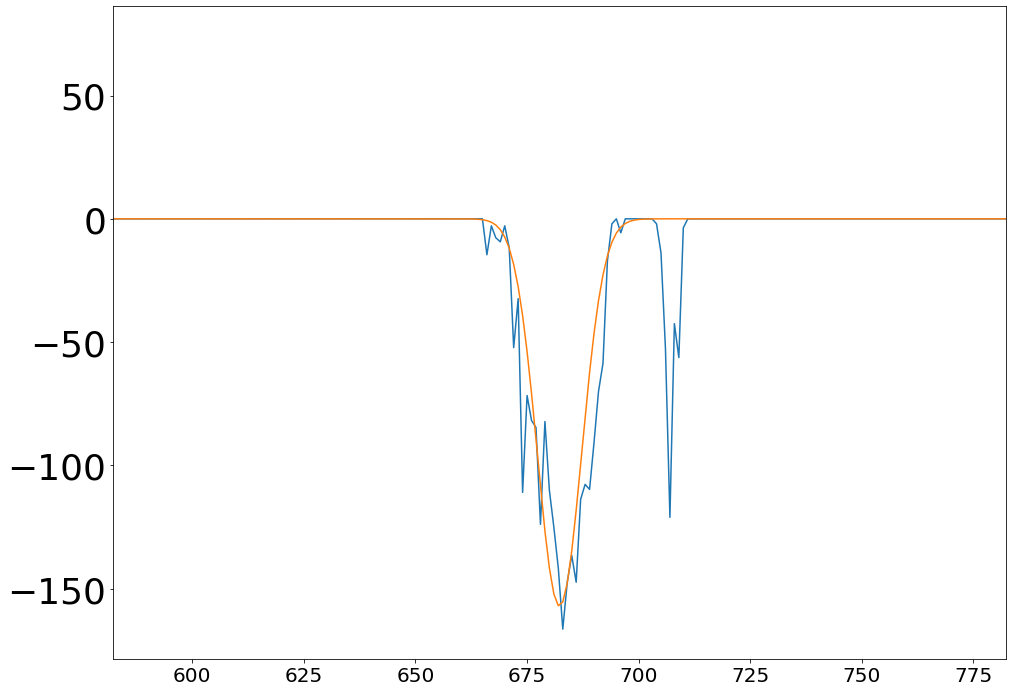

 76%|███████▋  | 116/152 [00:15<00:04,  7.52it/s]

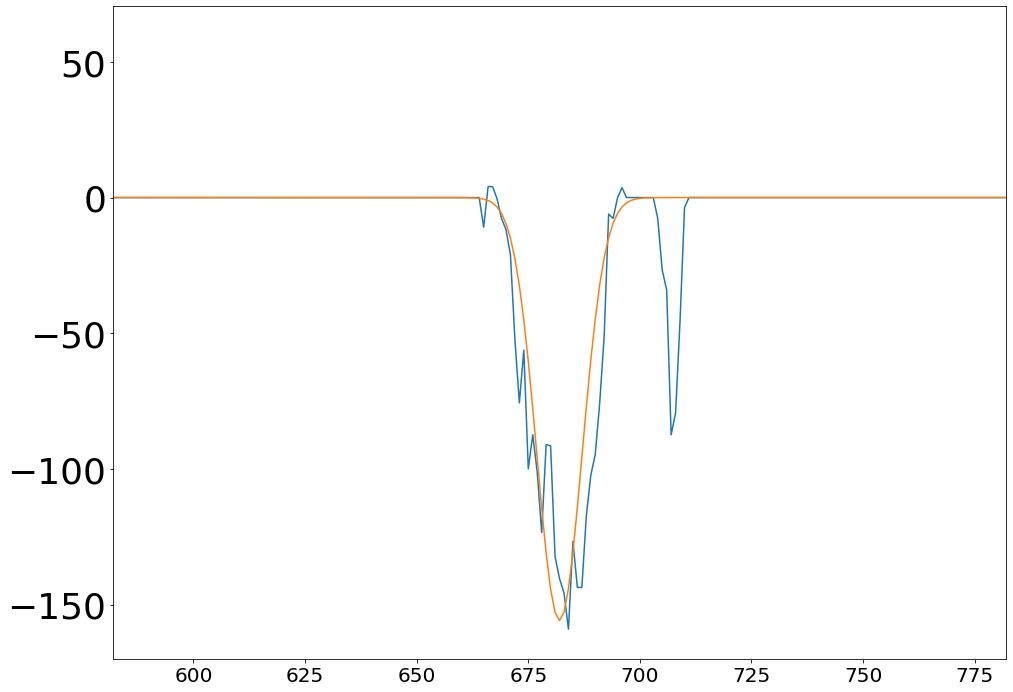

 77%|███████▋  | 117/152 [00:16<00:04,  7.59it/s]

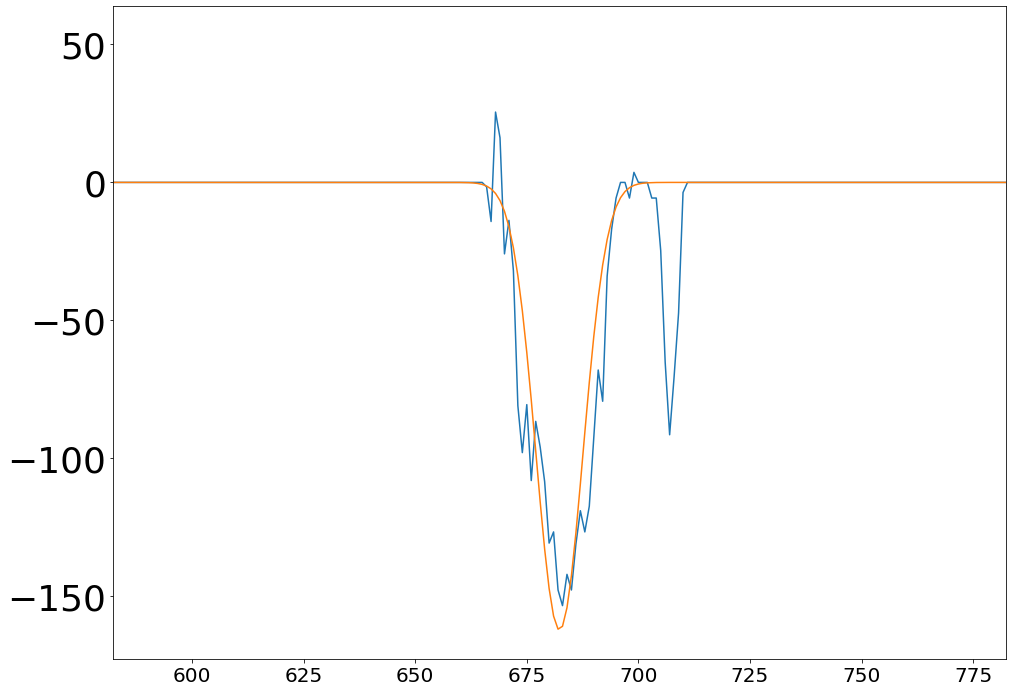

 78%|███████▊  | 118/152 [00:16<00:04,  7.56it/s]

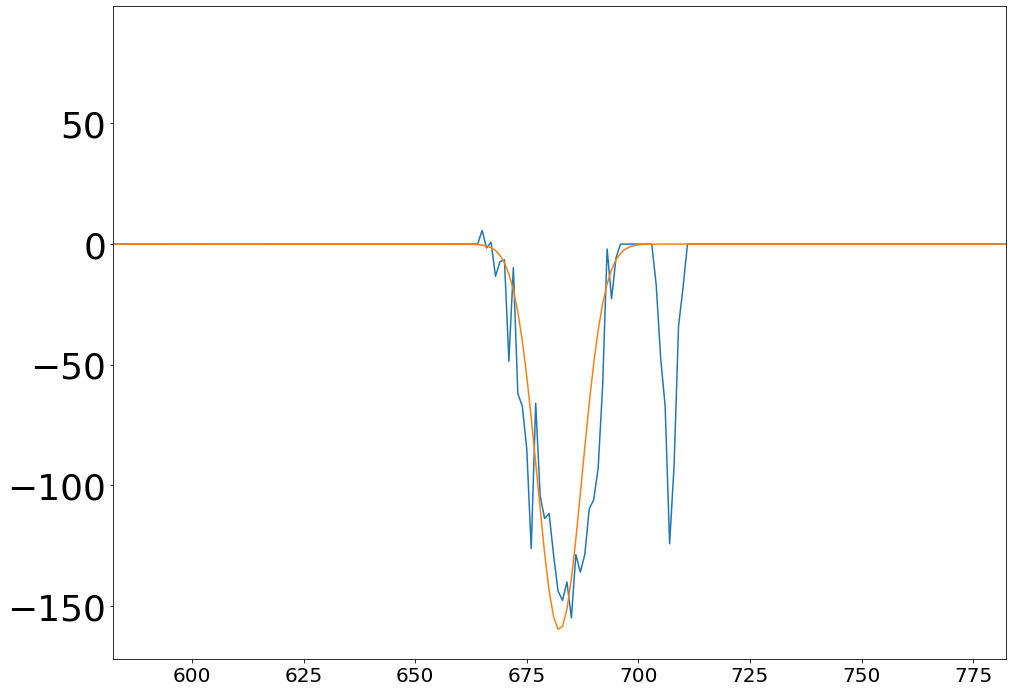

 78%|███████▊  | 119/152 [00:16<00:04,  7.56it/s]

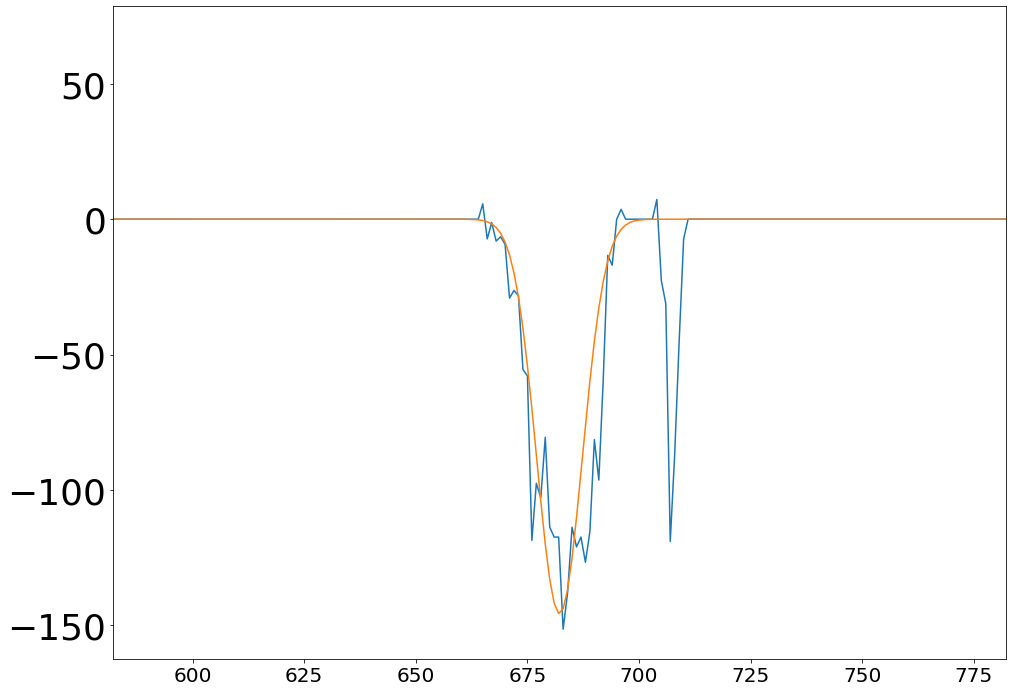

 79%|███████▉  | 120/152 [00:16<00:04,  7.61it/s]

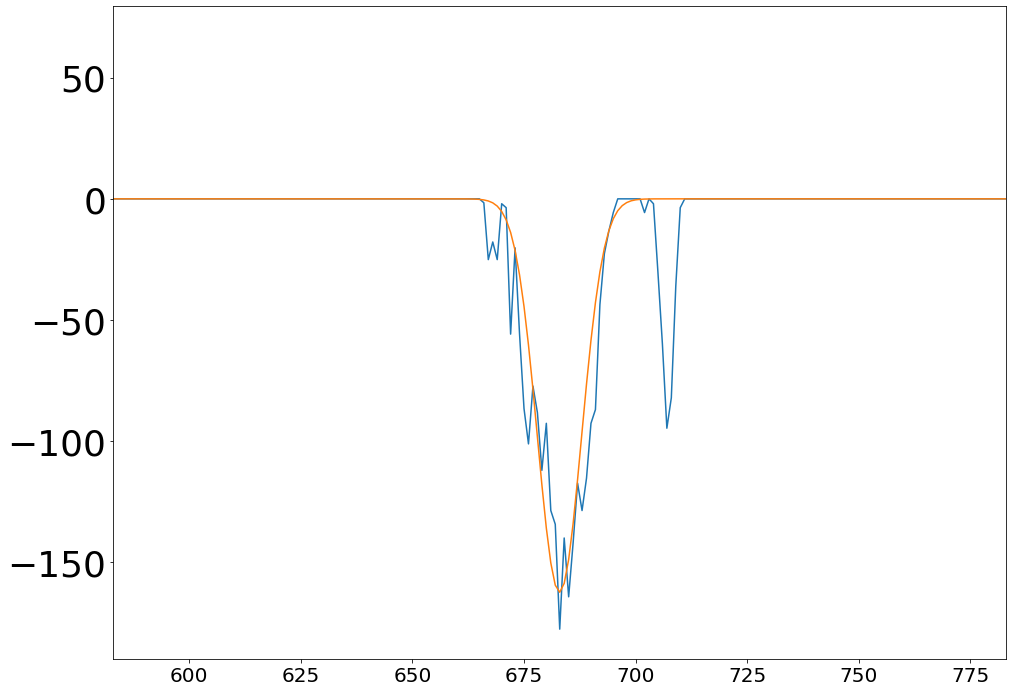

 80%|███████▉  | 121/152 [00:16<00:04,  6.85it/s]

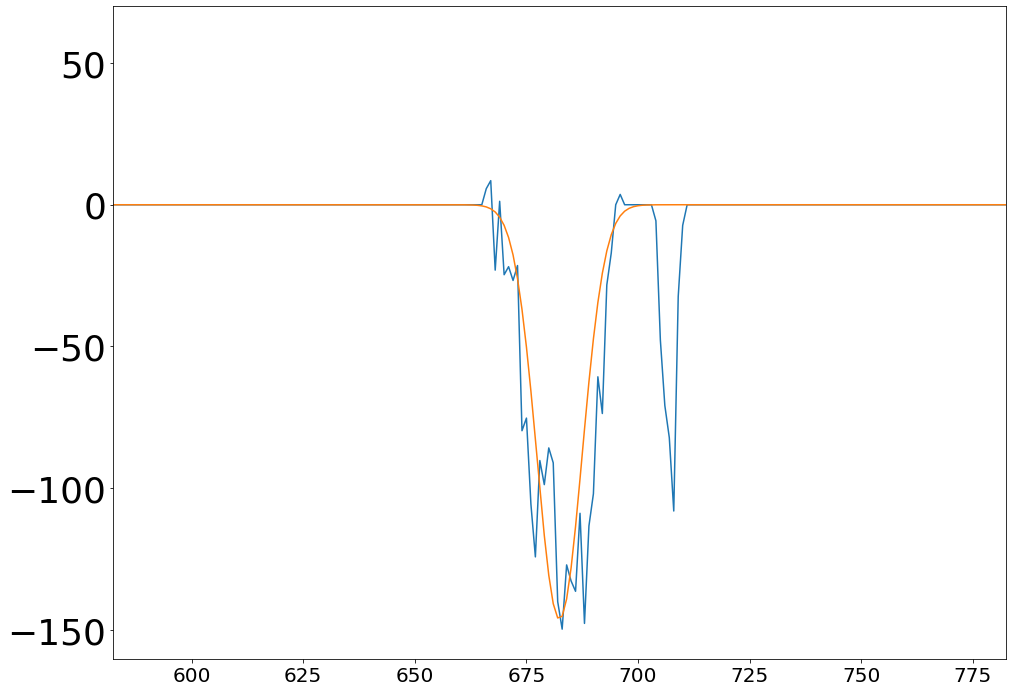

 80%|████████  | 122/152 [00:16<00:04,  7.03it/s]

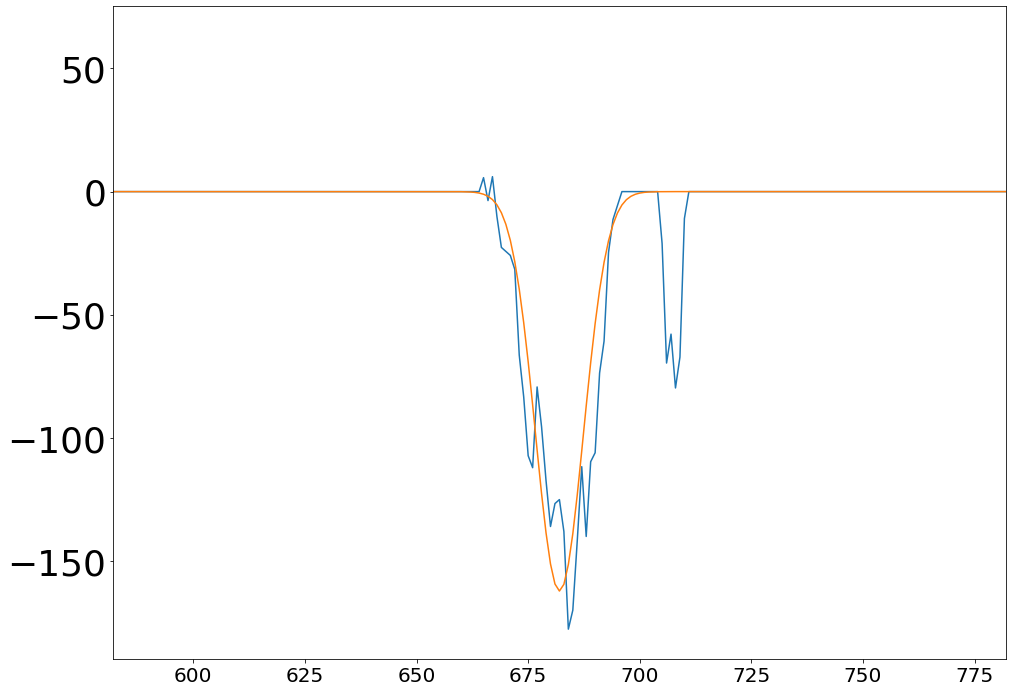

 81%|████████  | 123/152 [00:16<00:04,  7.18it/s]

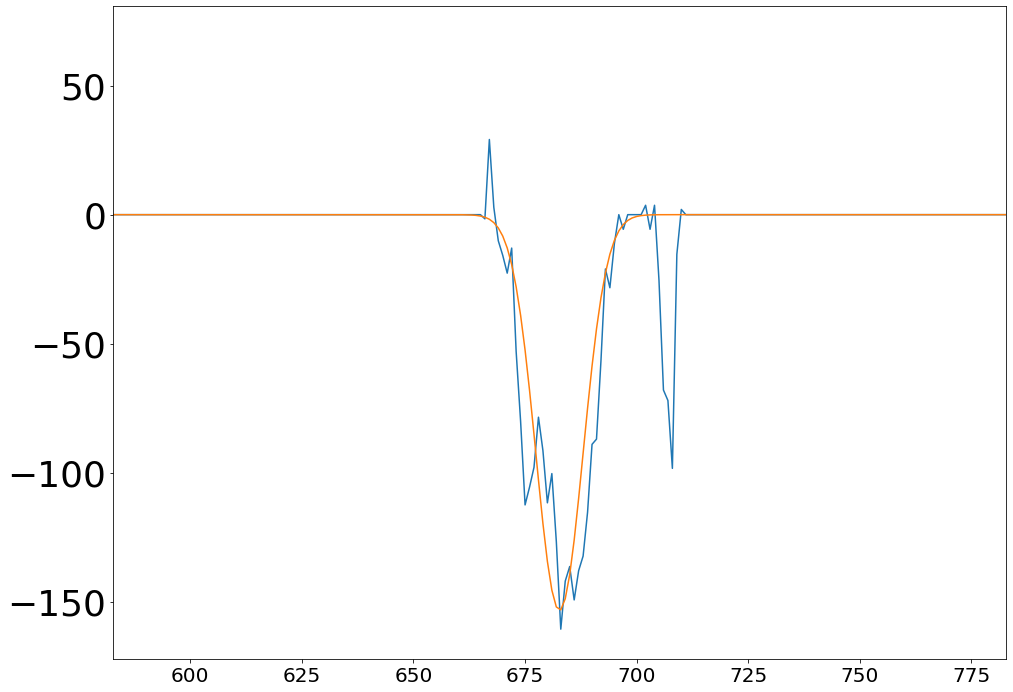

 82%|████████▏ | 124/152 [00:17<00:03,  7.31it/s]

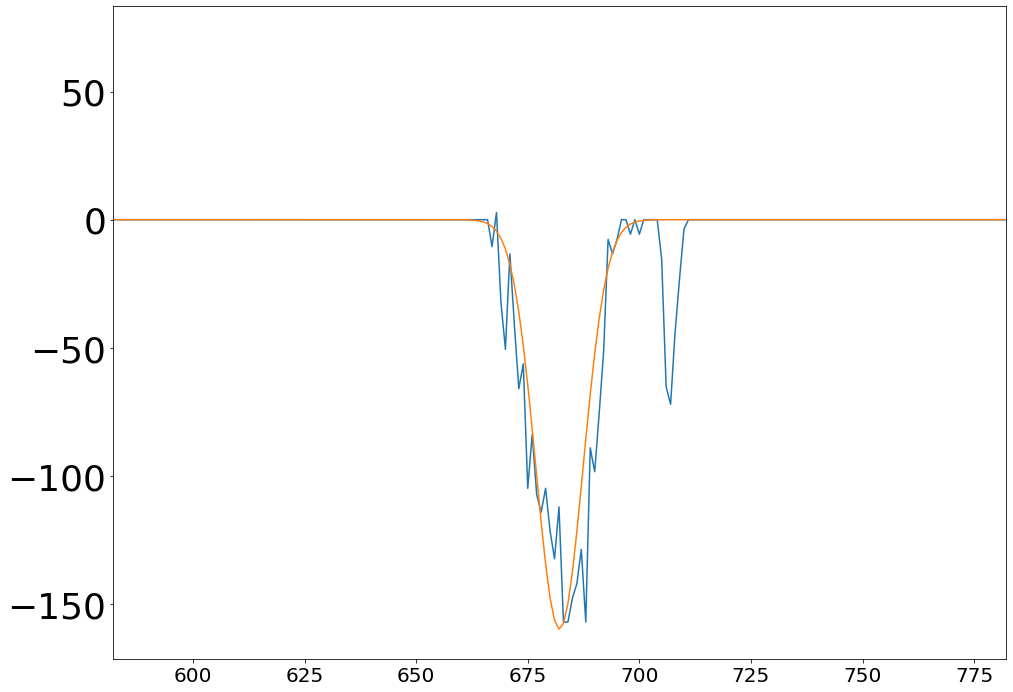

 82%|████████▏ | 125/152 [00:17<00:03,  7.37it/s]

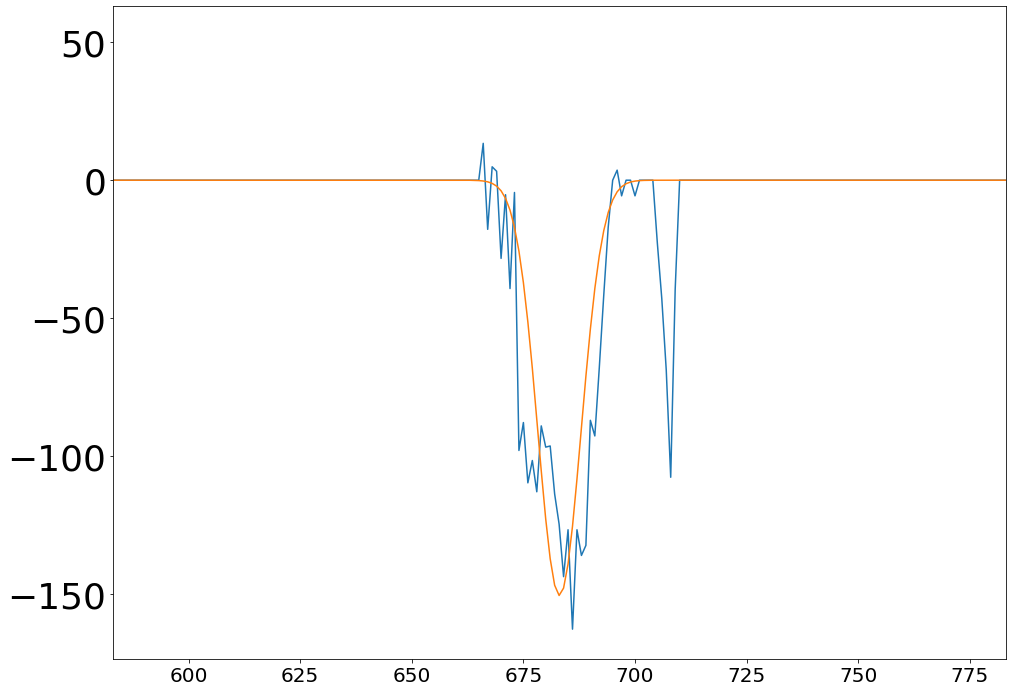

 83%|████████▎ | 126/152 [00:17<00:03,  7.39it/s]

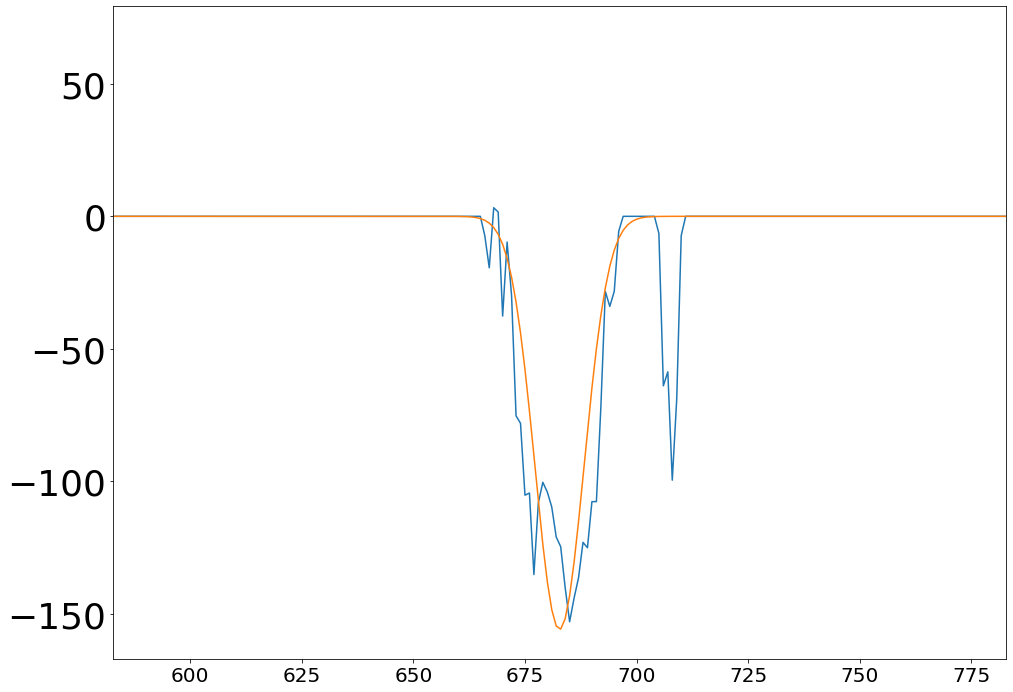

 84%|████████▎ | 127/152 [00:17<00:03,  7.52it/s]

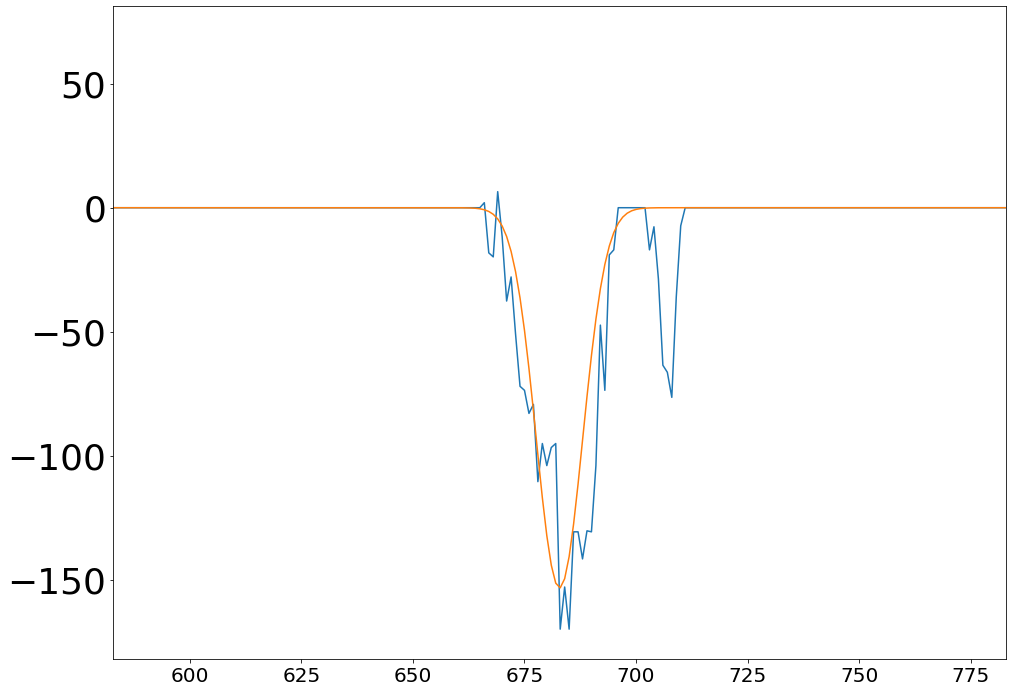

 84%|████████▍ | 128/152 [00:17<00:03,  7.53it/s]

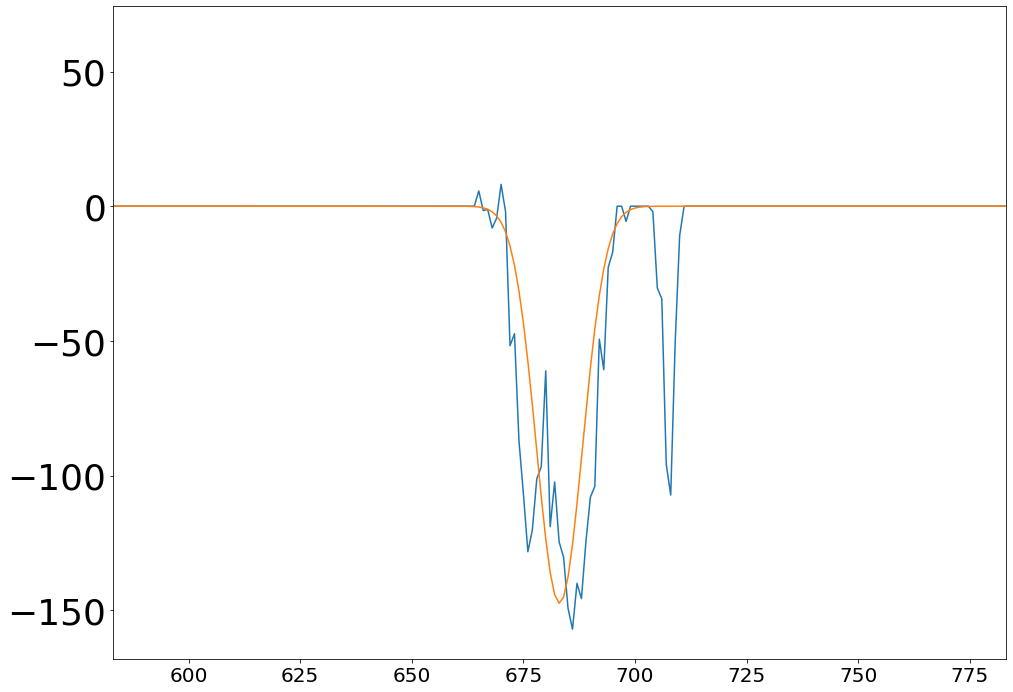

 85%|████████▍ | 129/152 [00:17<00:03,  7.62it/s]

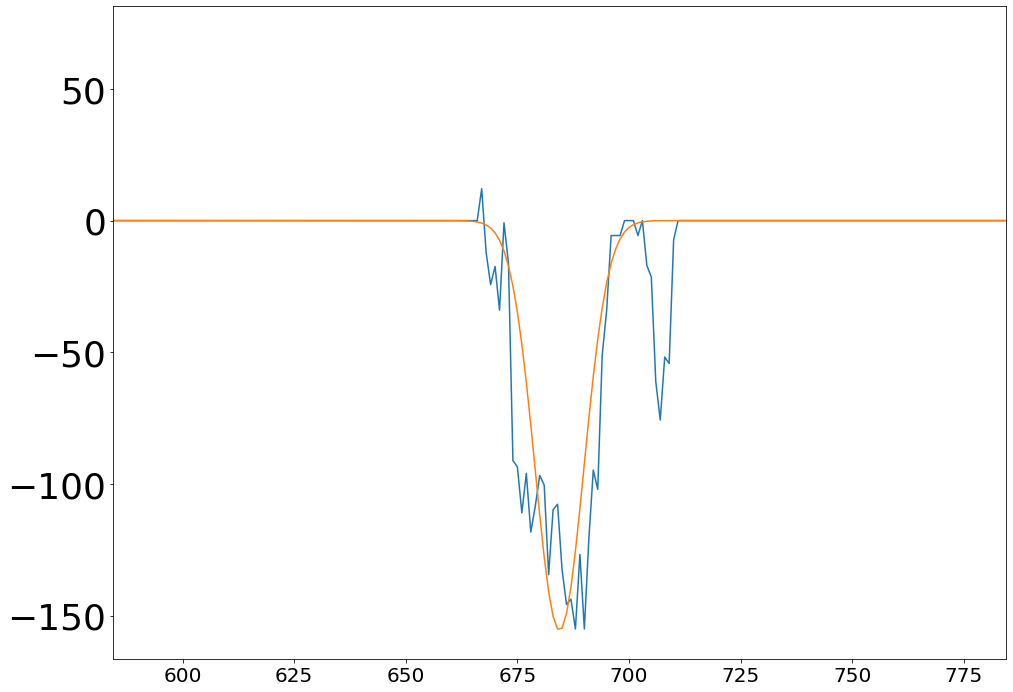

 86%|████████▌ | 130/152 [00:17<00:02,  7.64it/s]

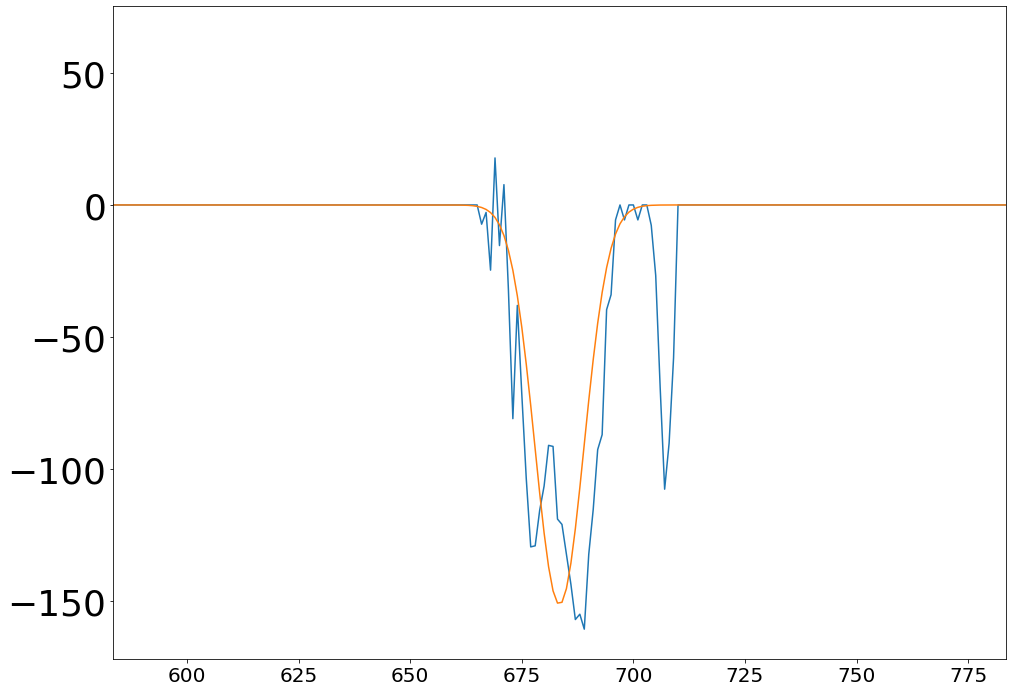

 86%|████████▌ | 131/152 [00:17<00:02,  7.54it/s]

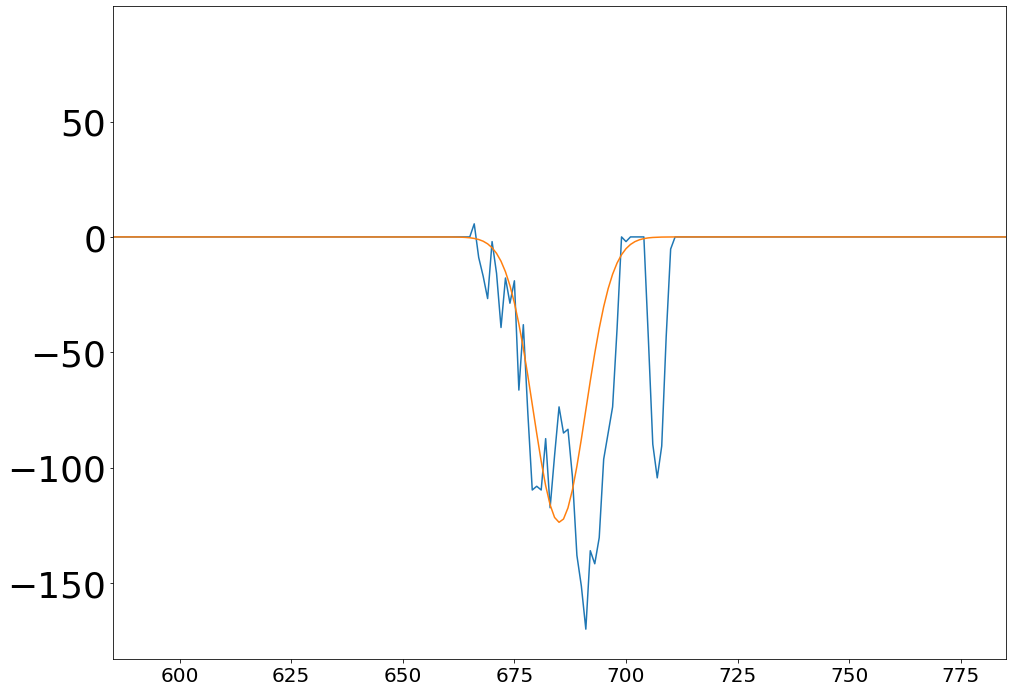

 87%|████████▋ | 132/152 [00:18<00:02,  7.55it/s]

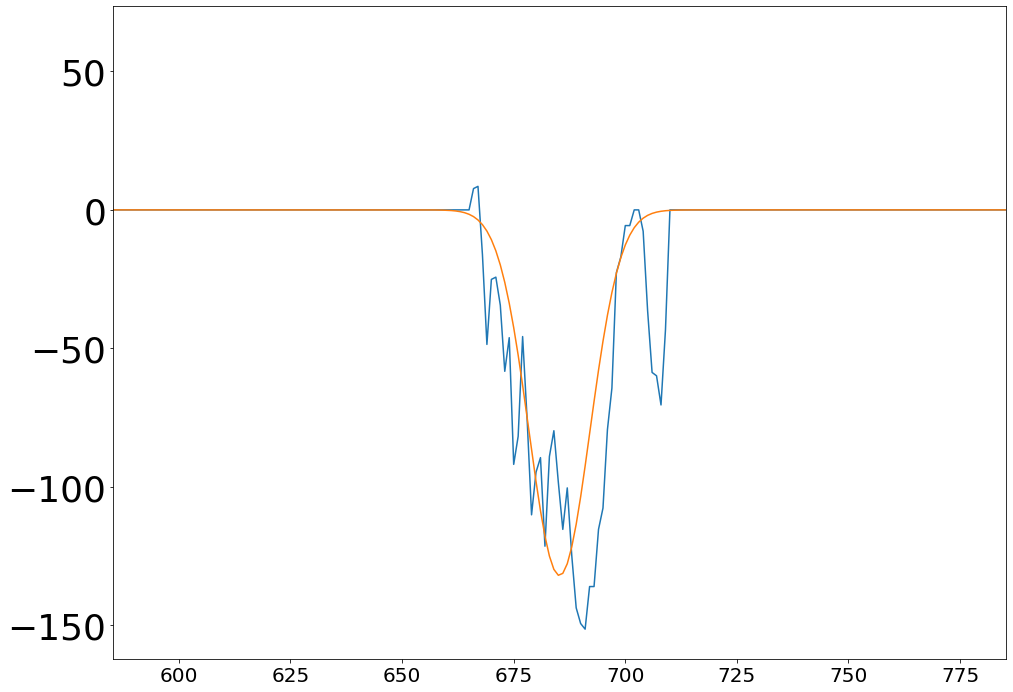

 88%|████████▊ | 133/152 [00:18<00:02,  7.51it/s]

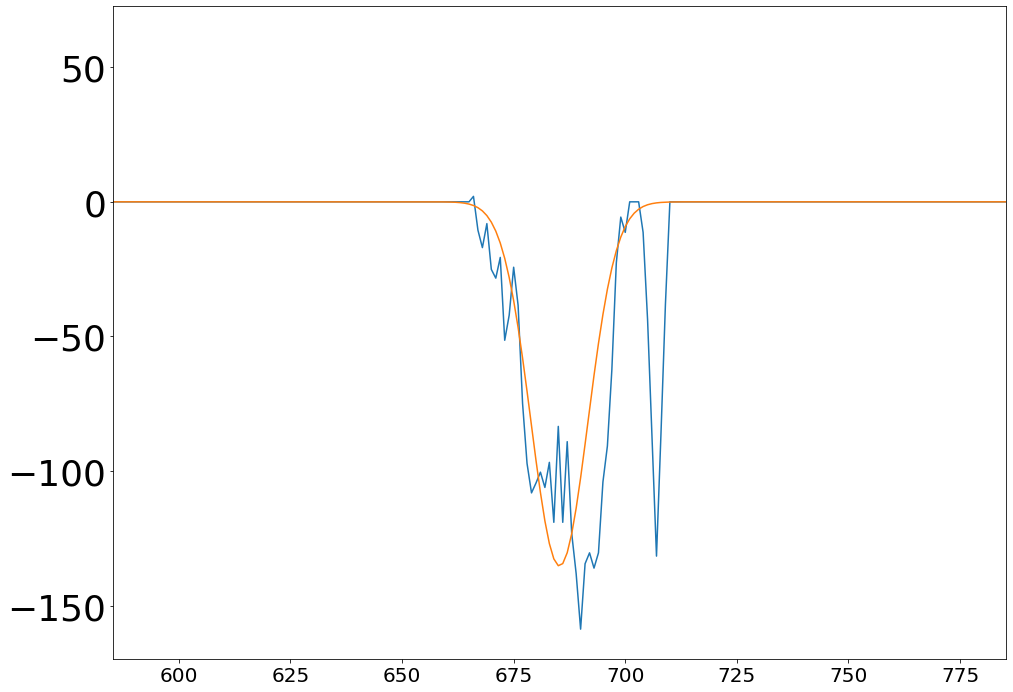

 88%|████████▊ | 134/152 [00:18<00:02,  7.52it/s]

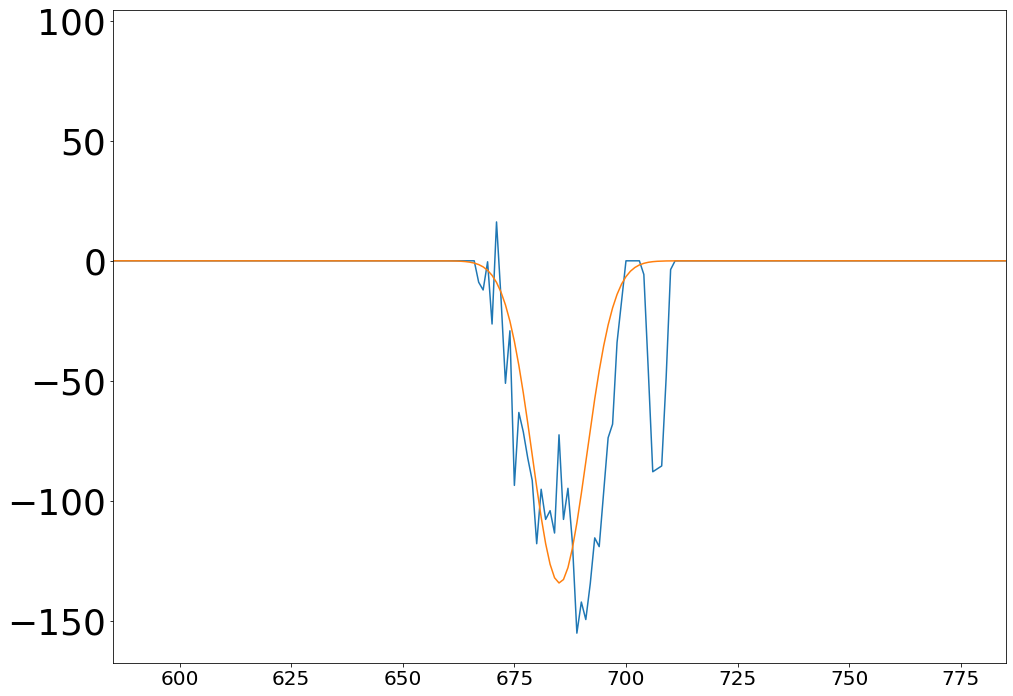

 89%|████████▉ | 135/152 [00:18<00:02,  6.69it/s]

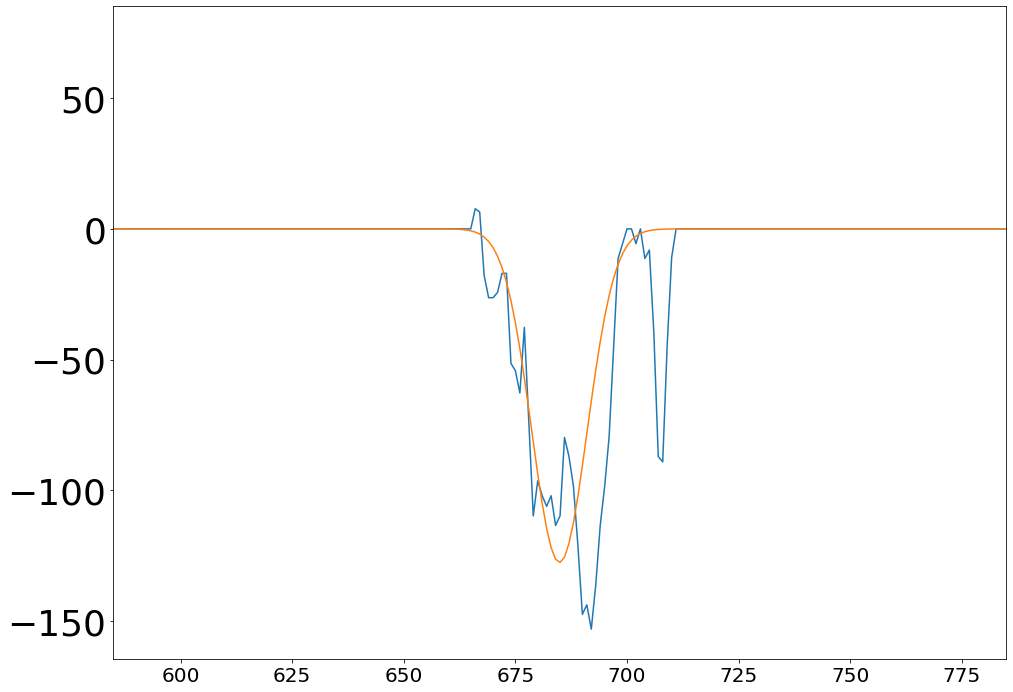

 89%|████████▉ | 136/152 [00:18<00:02,  6.92it/s]

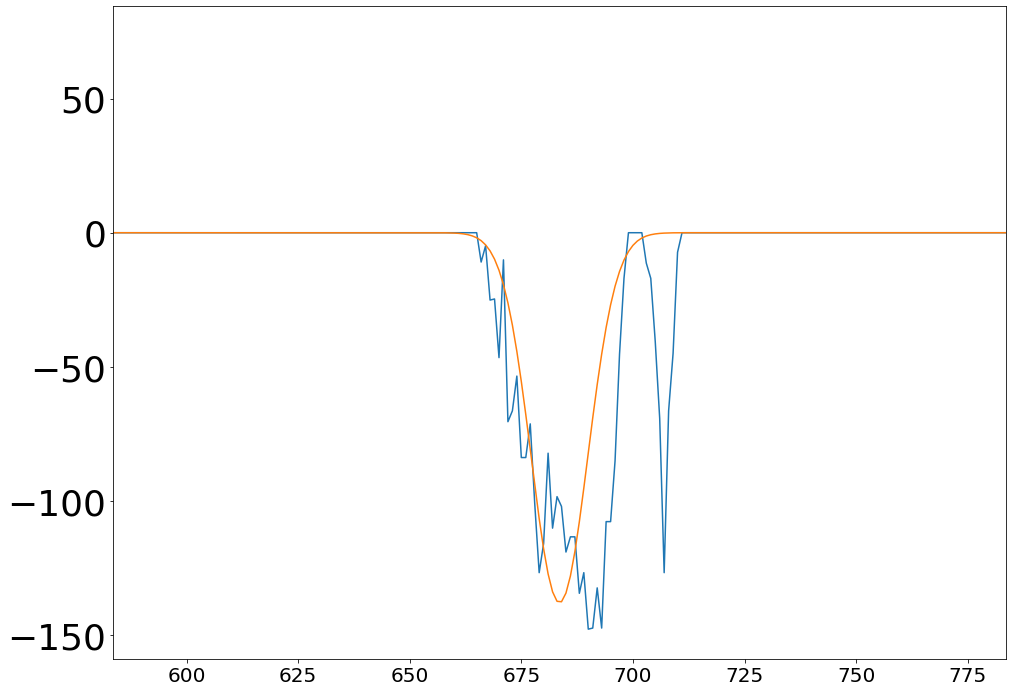

 90%|█████████ | 137/152 [00:18<00:02,  7.08it/s]

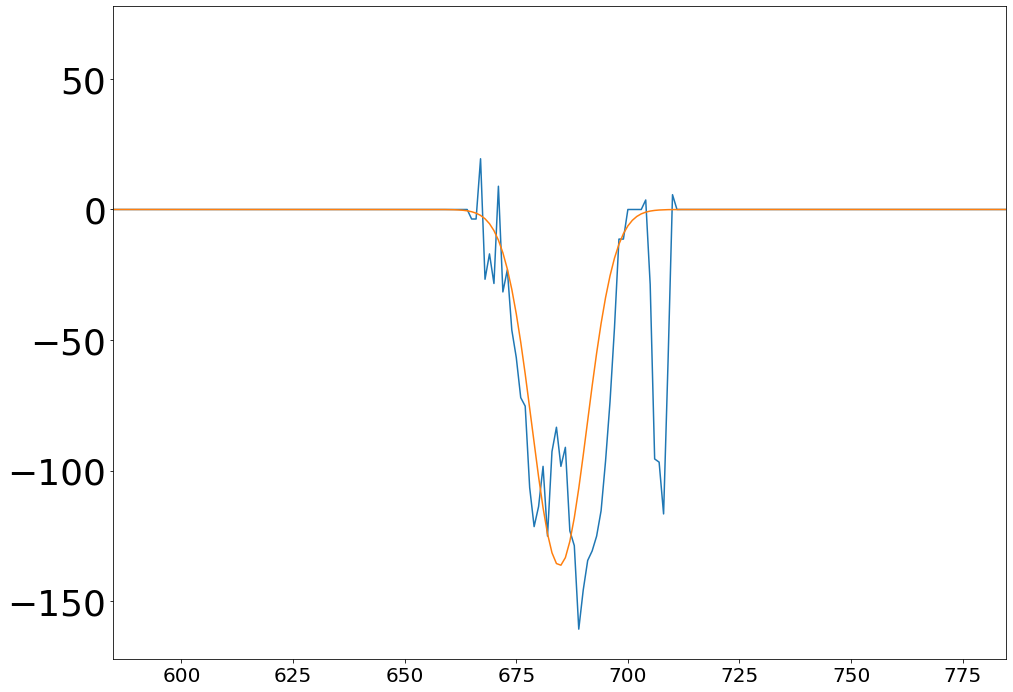

 91%|█████████ | 138/152 [00:18<00:01,  7.12it/s]

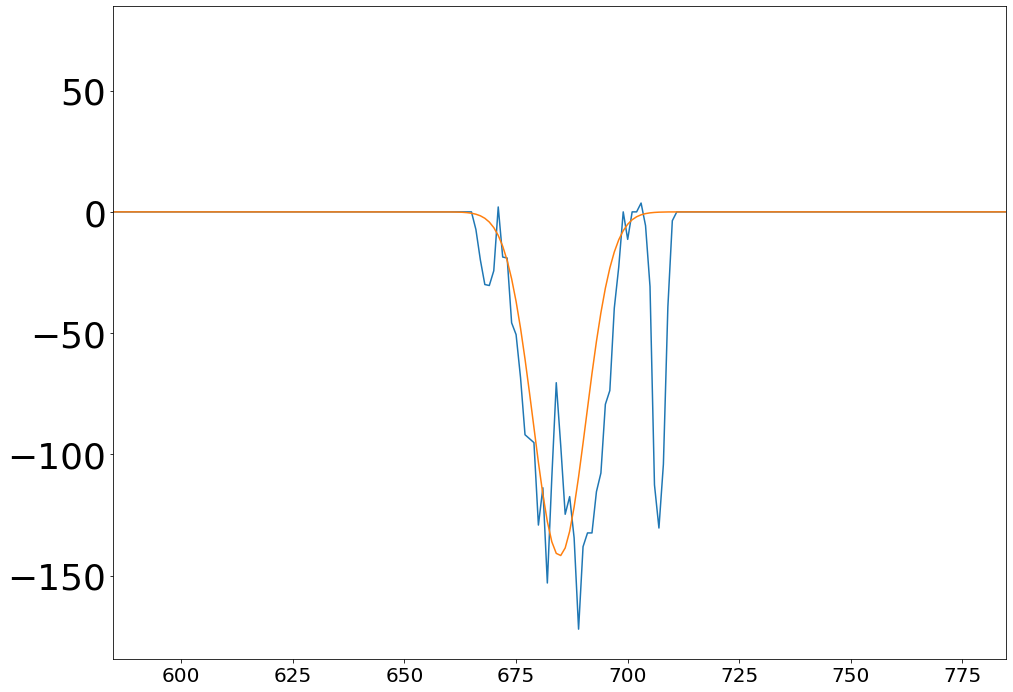

 91%|█████████▏| 139/152 [00:19<00:01,  7.27it/s]

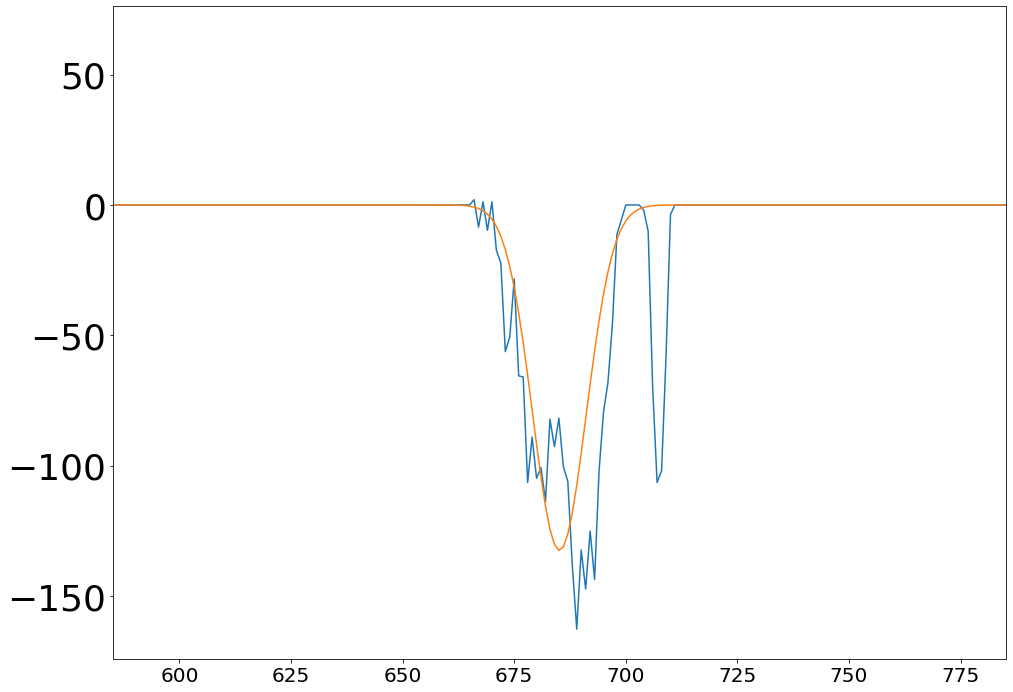

 92%|█████████▏| 140/152 [00:19<00:01,  7.31it/s]

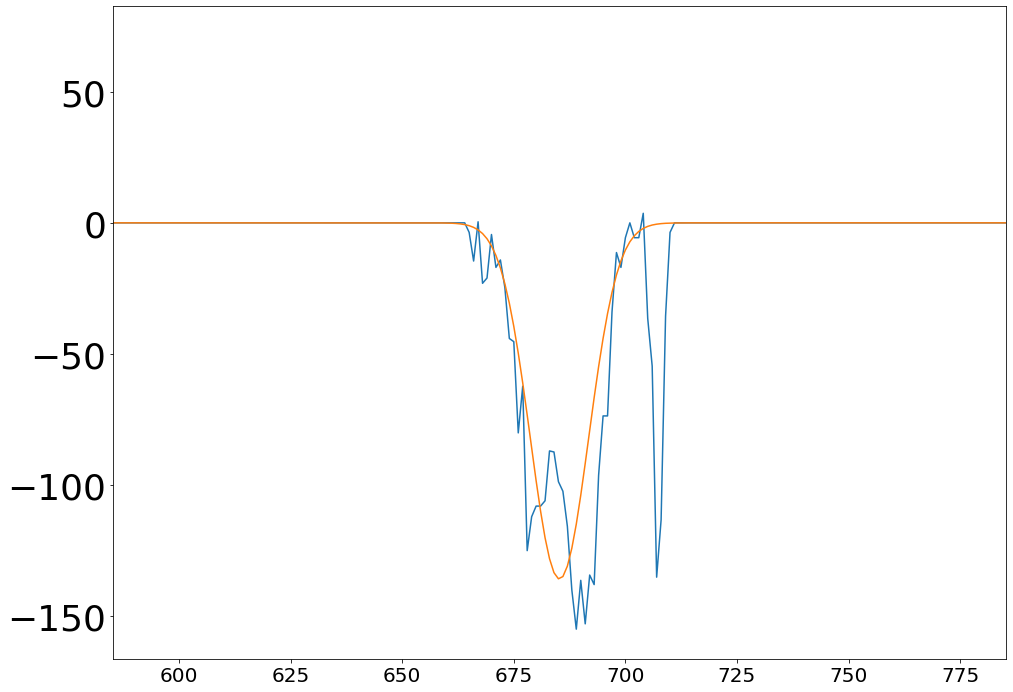

 93%|█████████▎| 141/152 [00:19<00:01,  7.35it/s]

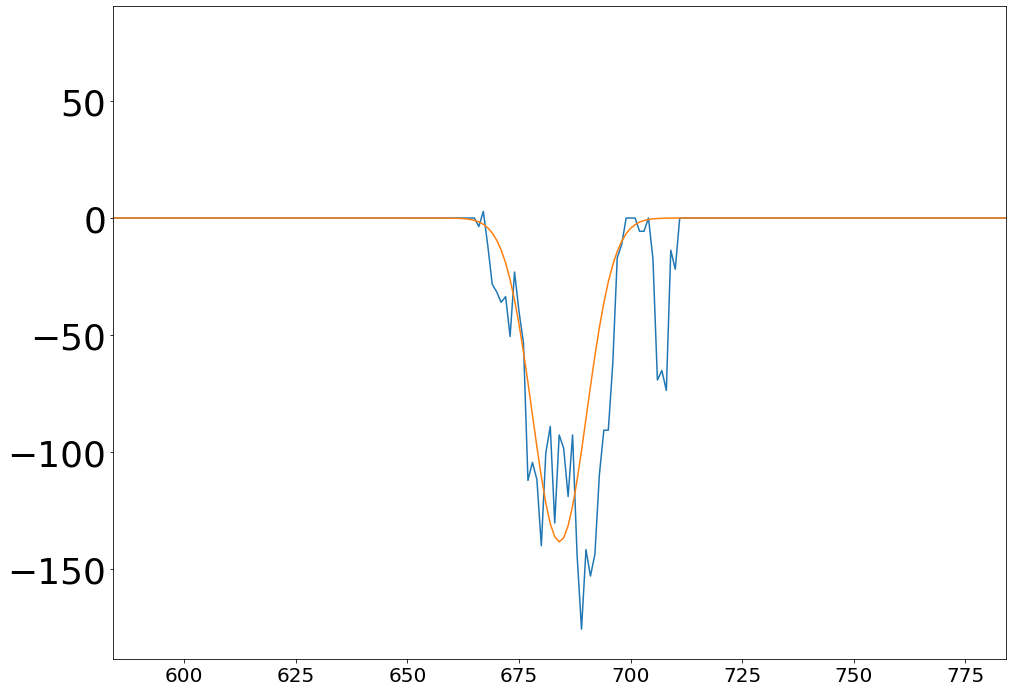

 93%|█████████▎| 142/152 [00:19<00:01,  7.14it/s]

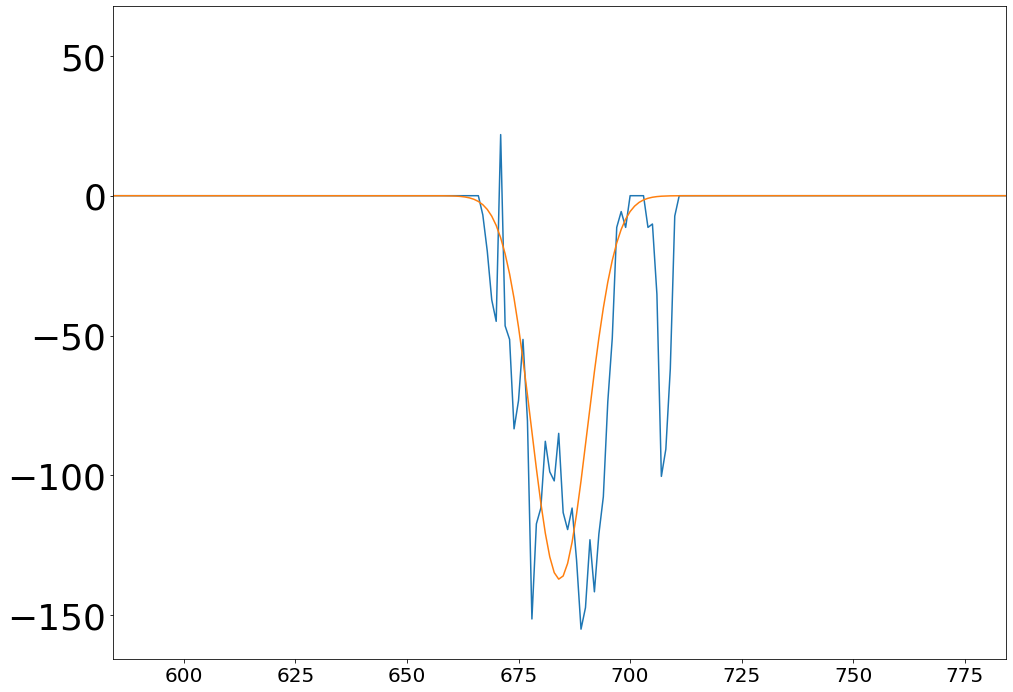

 94%|█████████▍| 143/152 [00:19<00:01,  7.18it/s]

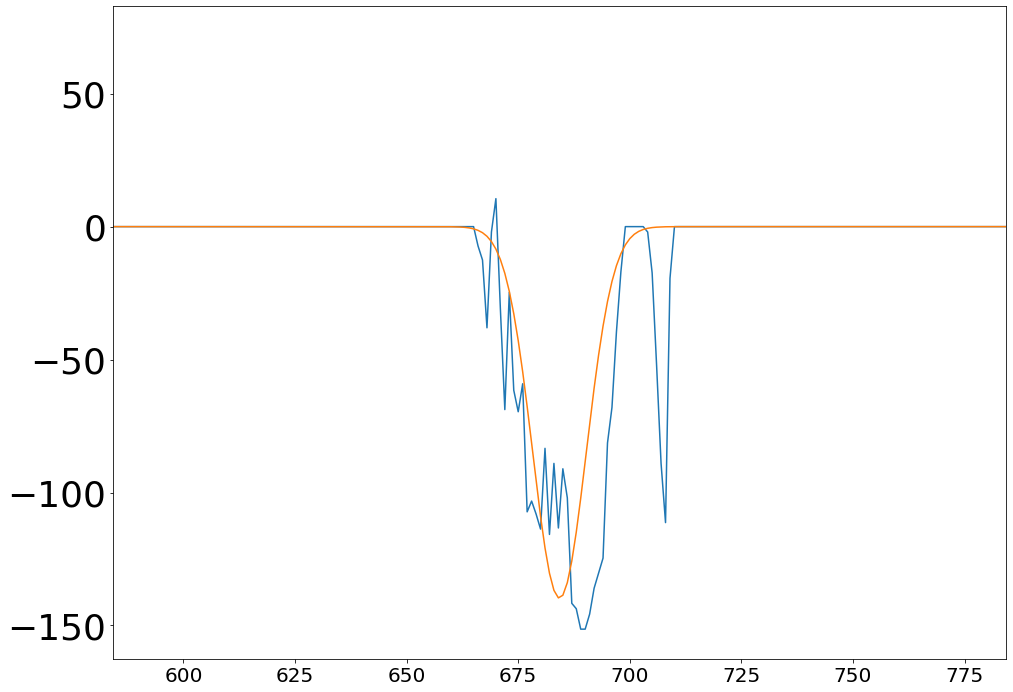

 95%|█████████▍| 144/152 [00:19<00:01,  7.30it/s]

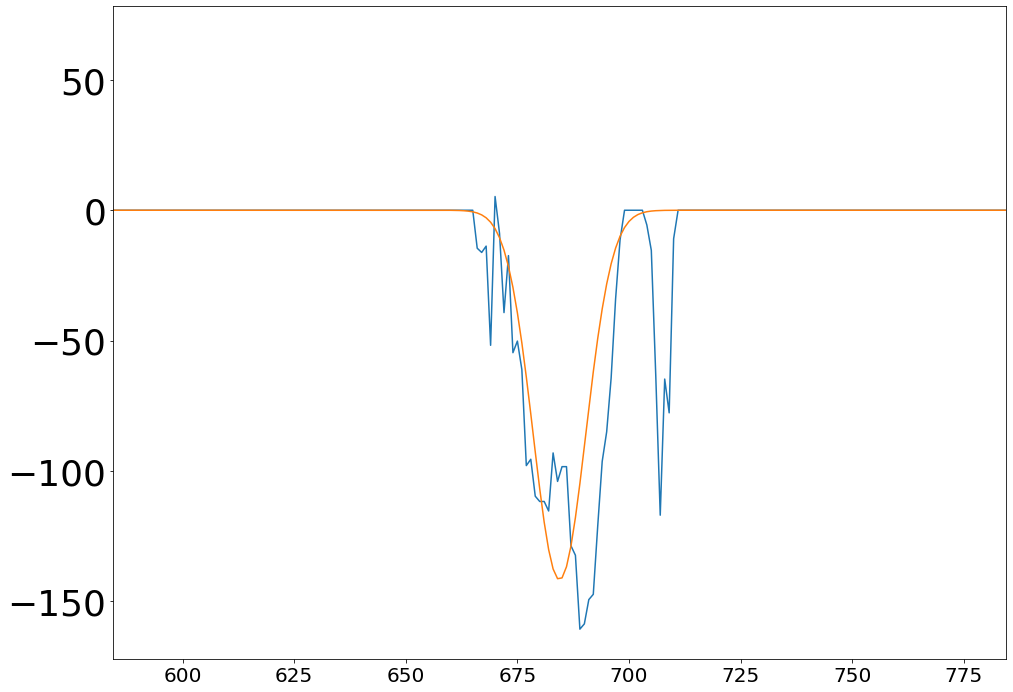

 95%|█████████▌| 145/152 [00:19<00:00,  7.37it/s]

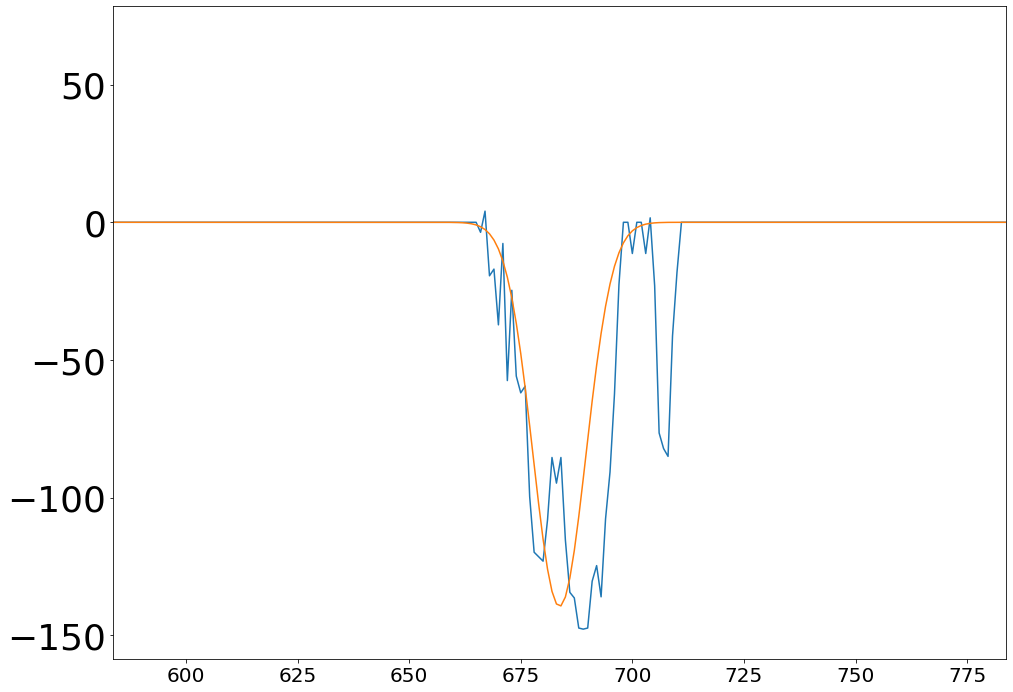

 96%|█████████▌| 146/152 [00:20<00:00,  7.36it/s]

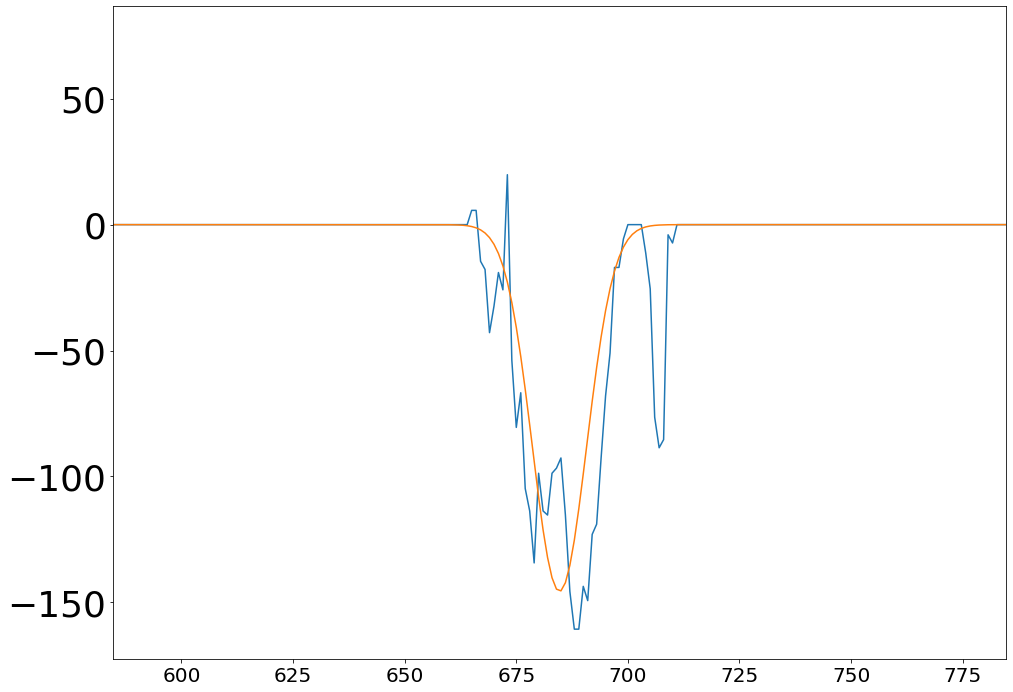

 97%|█████████▋| 147/152 [00:20<00:00,  7.46it/s]

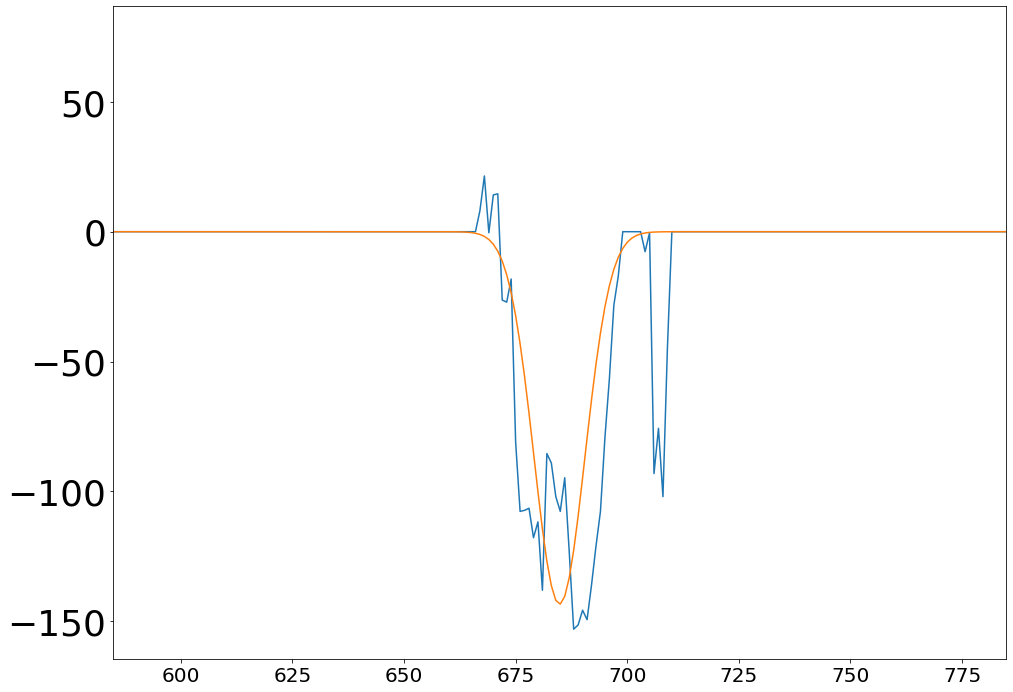

 97%|█████████▋| 148/152 [00:20<00:00,  7.52it/s]

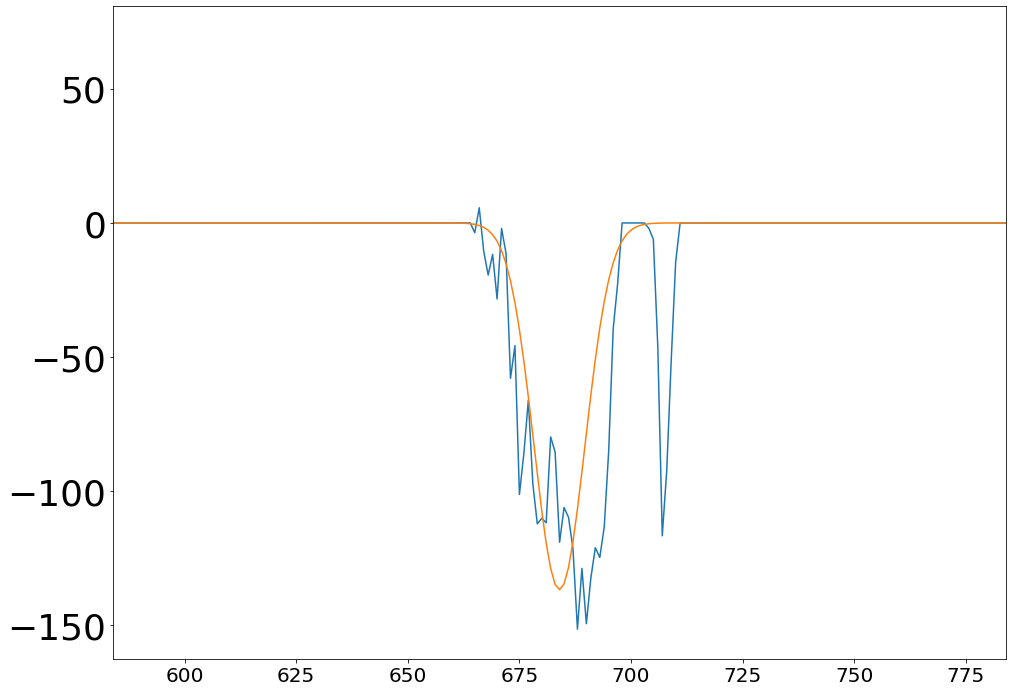

 98%|█████████▊| 149/152 [00:20<00:00,  6.78it/s]

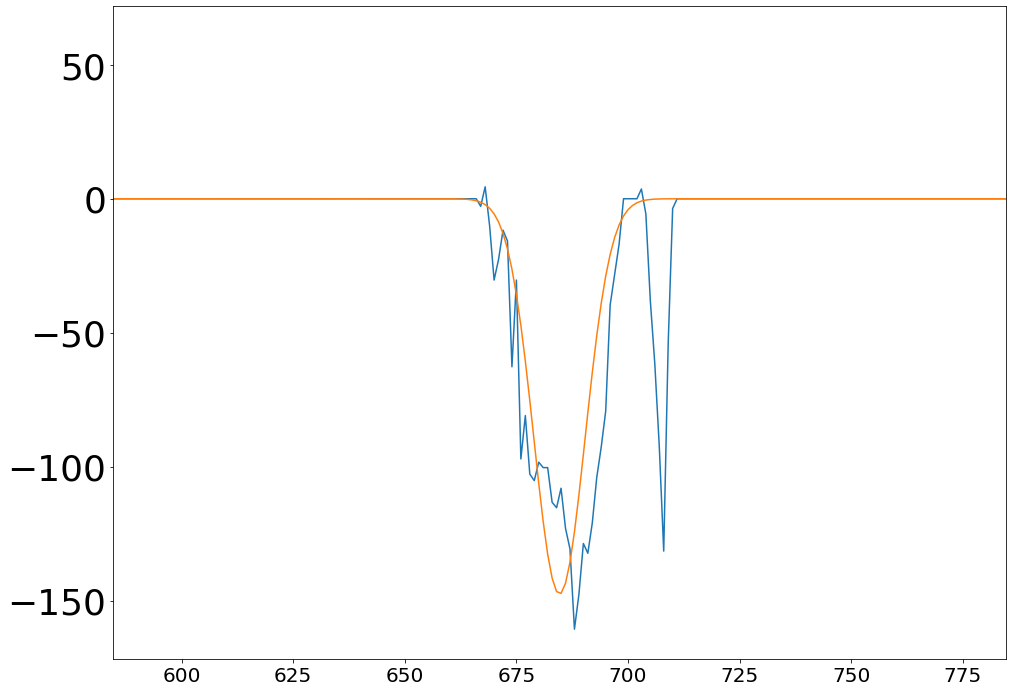

 99%|█████████▊| 150/152 [00:20<00:00,  6.99it/s]

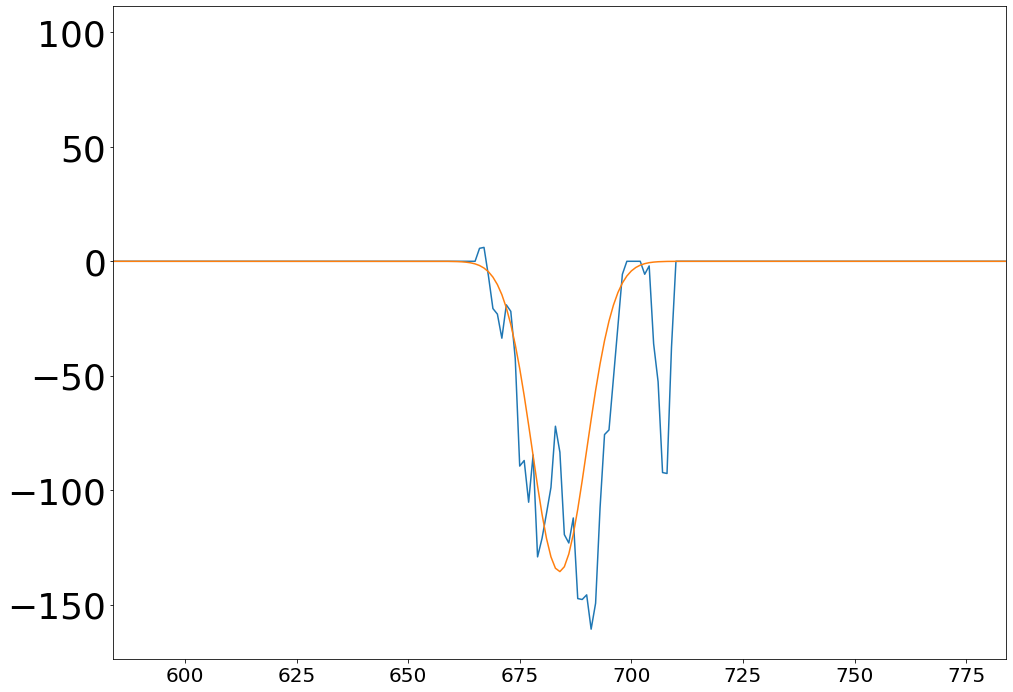

 99%|█████████▉| 151/152 [00:20<00:00,  7.08it/s]

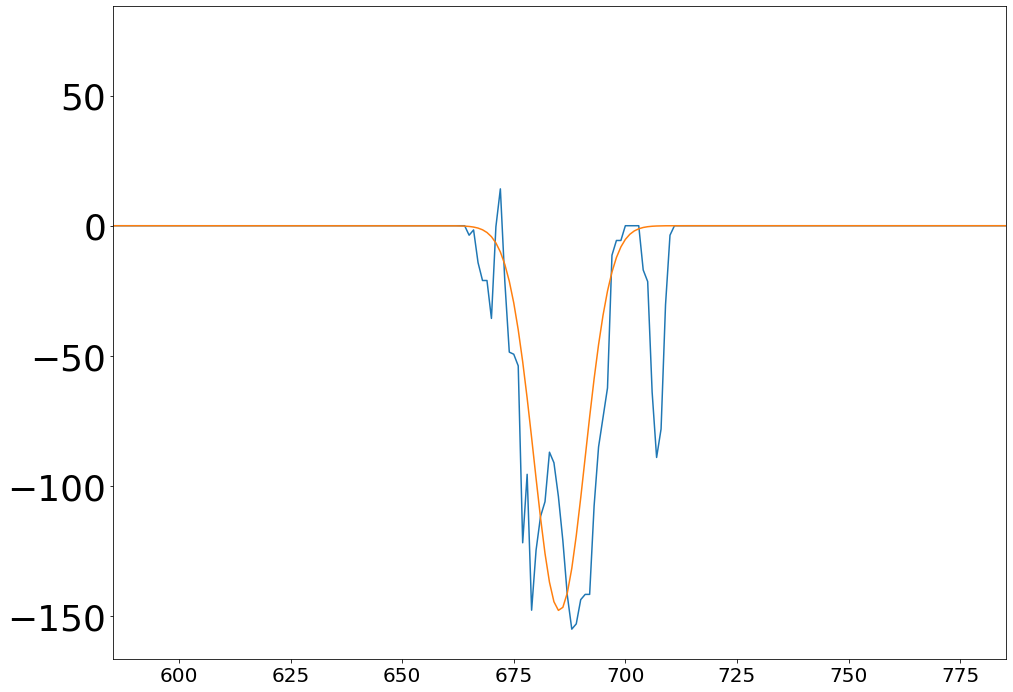

100%|██████████| 152/152 [00:20<00:00,  7.22it/s]


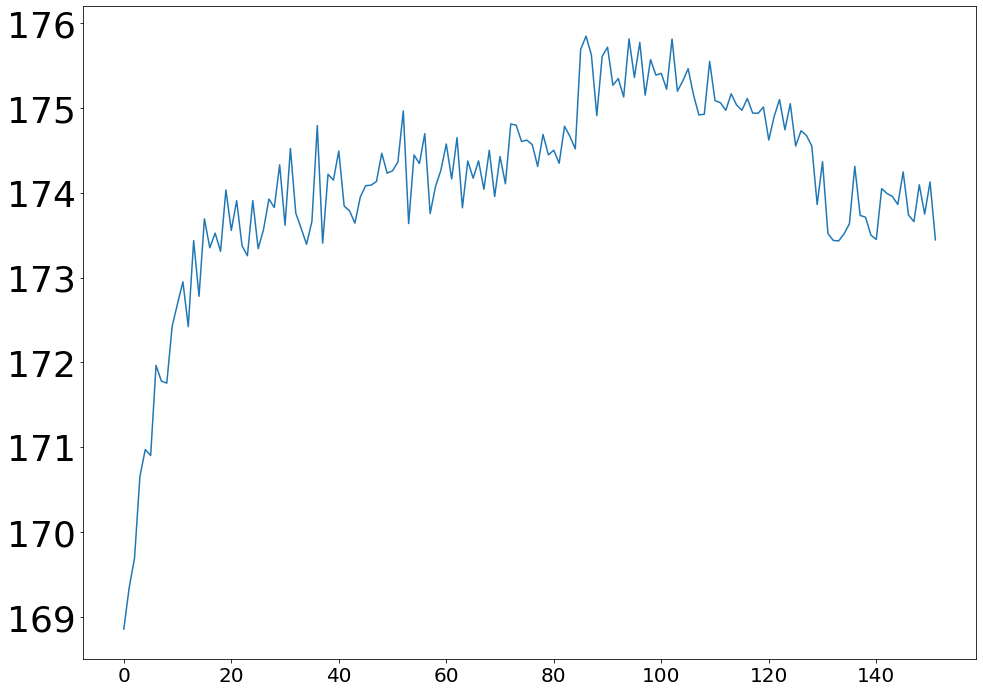

In [13]:
for s in [180]:
    print(s)
    height = [] # get the height using the shadow method
    for i in tqdm(np.arange(0,len(data),1)):
        mean, m = from_shadow_image_to_height(data[i],s,area_low_limits=[600,530],area_widths=[45,70],flb=650,fub=725,plot=False)
        height.append(pixel_to_height(mean,calibration=True,pix_size_from_calib=pixel_size_cal))
        #print(m.values["mean"])
        plt.show()
    plt.plot(height)
    plt.show()


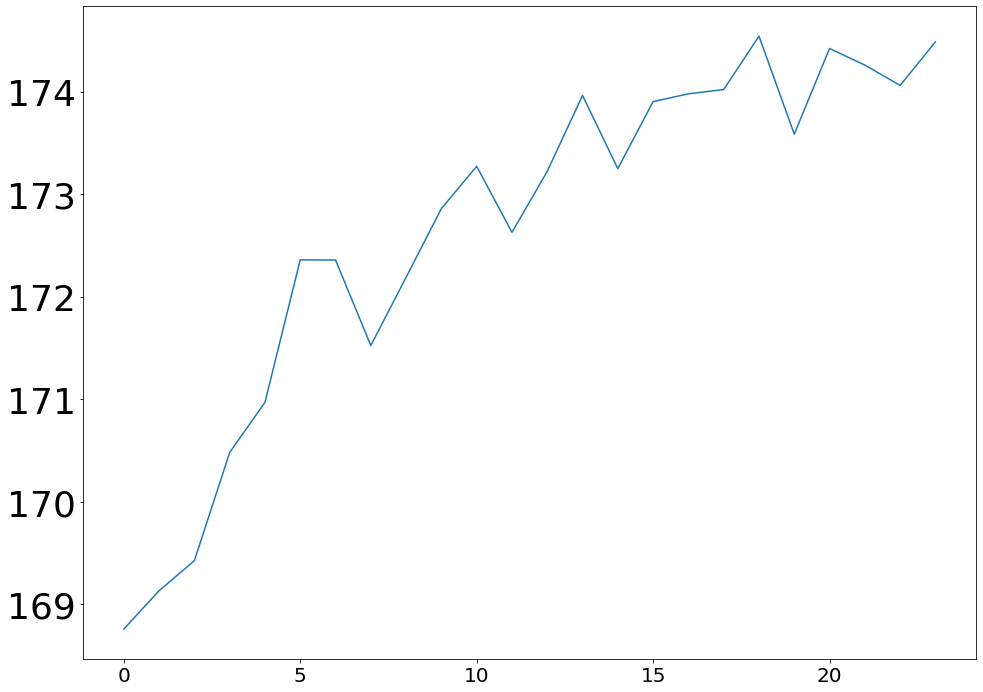

In [88]:
plt.plot(height)